# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from src.lightgbm_wrapper.feature_engineer import add_time_features, add_lag_features, add_rolling_features
from src.lightgbm_wrapper.plot import plot_1_data, plot_2_data
from src.lightgbm_wrapper.model import build_supervised_for_horizon, train_test_validation_split, train_lgbm_for_horizon, plot_timeseries_example

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/joined_left_CMAQ.csv"
STATION_IDS = [211, 212, 213, 214, 215, 216]

BASE_FEATURE_COLS = [
    "NO2_cmaq",
    "NO_cmaq",
    "O3_cmaq",
]

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24]
ROLL_WINDOWS = [3, 6, 12, 24]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

# Directory to save the results and meta data
LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/{datetime.now(timezone('Asia/Saigon')).strftime('%Y_%m_%d-%H_%M_%S')}"
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)
with open(os.path.join(LIGHTGBM_DIR, "CONFIGURATIONS.txt"), "w") as f:
    f.write(f"BASE_FEATURE_COLS: {BASE_FEATURE_COLS}\n")
    f.write(f"LAG_STEPS: {LAG_STEPS}\n")
    f.write(f"ROLL_WINDOWS: {ROLL_WINDOWS}\n")
    f.write(f"HORIZONS: {HORIZONS}\n")

/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/2025_12_17-20_05_15


# Load dataset

In [2]:
# Load dataset
df_all = pd.read_csv("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/joined_left_CMAQ.csv")

# Rename columns
df_all = df_all.rename({"Datetime": "date", "Station": "station_id"}, axis=1)
df_all = df_all.rename({c: c + "_cmaq" for c in df_all.columns if c not in ["date", "station_id"]}, axis=1)

# Set datetime
df_all["date"] = pd.to_datetime(df_all["date"])

# Sort data by station then date
df_all = df_all.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_all = df_all.loc[:, ["date"] + BASE_FEATURE_COLS + ["station_id"]]

print(df_all.shape)
print(df_all.columns)
print(df_all.dtypes)
df_all

(52332, 5)
Index(['date', 'NO2_cmaq', 'NO_cmaq', 'O3_cmaq', 'station_id'], dtype='object')
date          datetime64[ns]
NO2_cmaq             float64
NO_cmaq              float64
O3_cmaq              float64
station_id             int64
dtype: object


date  NO2_cmaq   NO_cmaq   O3_cmaq  station_id
0     2022-01-01 07:00:00  0.001115       NaN  0.098301         201
1     2022-01-01 08:00:00  0.001141       NaN  0.078072         201
2     2022-01-01 09:00:00  0.000941       NaN  0.061198         201
3     2022-01-01 10:00:00  0.000761       NaN  0.050983         201
4     2022-01-01 11:00:00  0.000600       NaN  0.042117         201
...                   ...       ...       ...       ...         ...
52327 2022-12-31 01:00:00  0.002276  0.000013  0.026421         216
52328 2022-12-31 02:00:00  0.002208  0.000013  0.026171         216
52329 2022-12-31 03:00:00  0.002249  0.000013  0.026087         216
52330 2022-12-31 04:00:00  0.002680  0.000013  0.026347         216
52331 2022-12-31 05:00:00  0.002590  0.000013  0.026102         216

[52332 rows x 5 columns]

In [3]:
df_all.isnull().sum()

date             0
NO2_cmaq         0
NO_cmaq       7637
O3_cmaq          0
station_id       0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [4]:
df_dropped = df_all.dropna().reset_index(drop=True)
df_dropped

date  NO2_cmaq   NO_cmaq   O3_cmaq  station_id
0     2022-01-02 00:00:00  0.006081  0.000046  0.026999         201
1     2022-01-02 01:00:00  0.005674  0.000046  0.026982         201
2     2022-01-02 02:00:00  0.005318  0.000046  0.027042         201
3     2022-01-02 03:00:00  0.005780  0.000046  0.026666         201
4     2022-01-02 04:00:00  0.006130  0.000046  0.026523         201
...                   ...       ...       ...       ...         ...
44690 2022-12-31 01:00:00  0.002276  0.000013  0.026421         216
44691 2022-12-31 02:00:00  0.002208  0.000013  0.026171         216
44692 2022-12-31 03:00:00  0.002249  0.000013  0.026087         216
44693 2022-12-31 04:00:00  0.002680  0.000013  0.026347         216
44694 2022-12-31 05:00:00  0.002590  0.000013  0.026102         216

[44695 rows x 5 columns]

## Update the STATION_IDS after dropping missing

In [5]:
STATION_IDS = list(df_dropped["station_id"].unique())
STATION_IDS

[201, 211, 212, 213, 214, 215, 216]

## Visualization

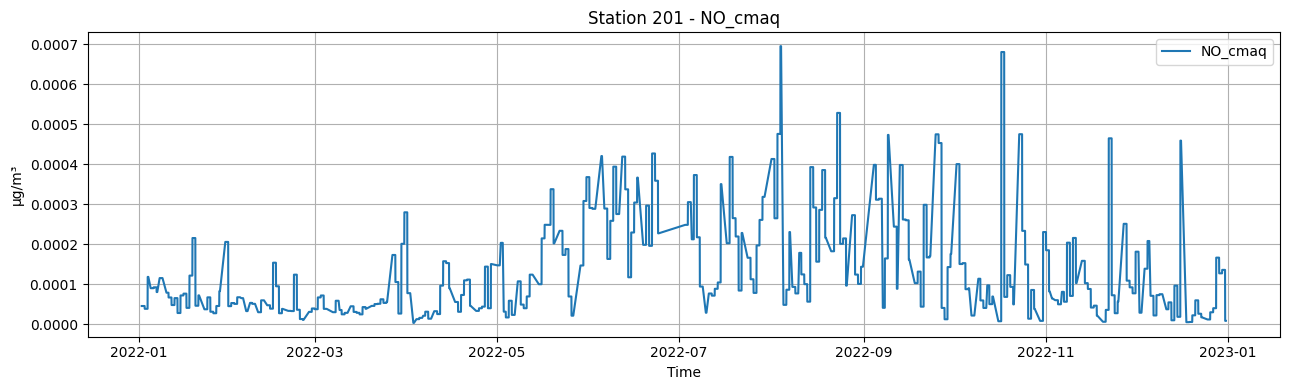

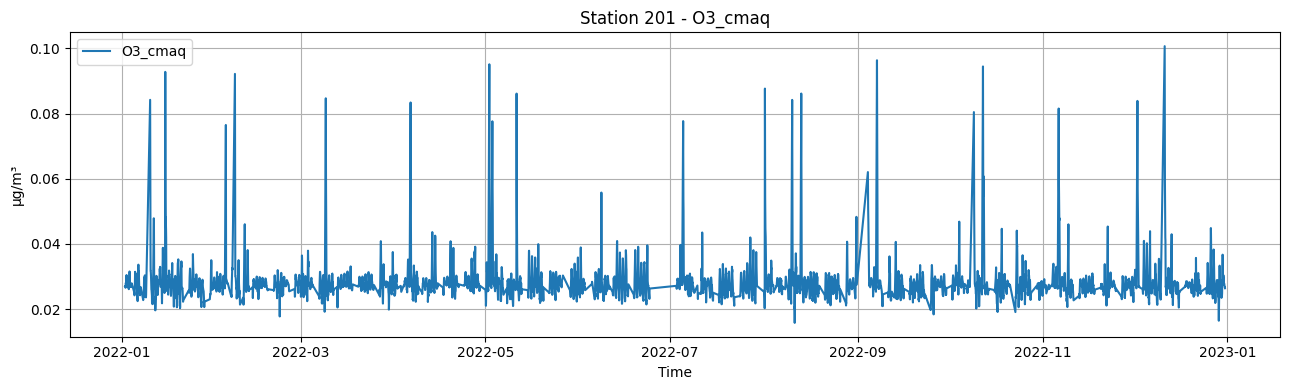

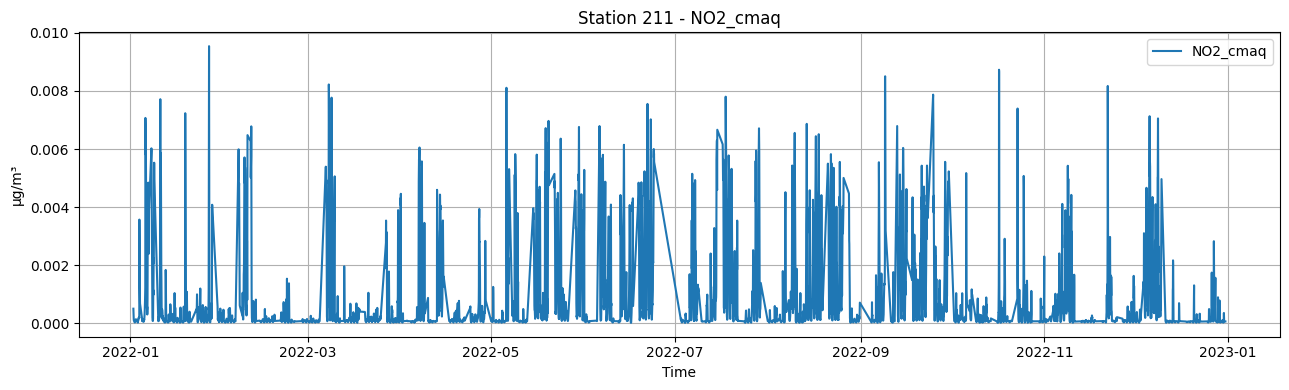

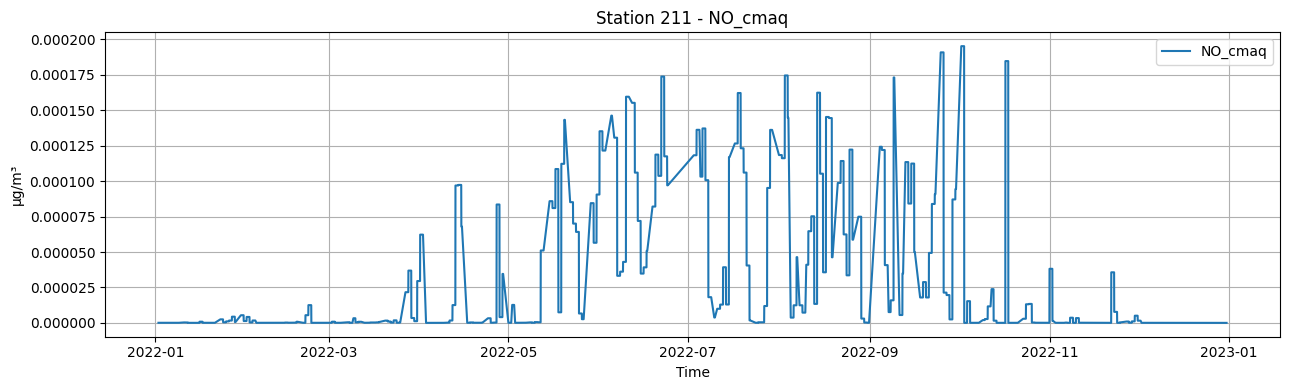

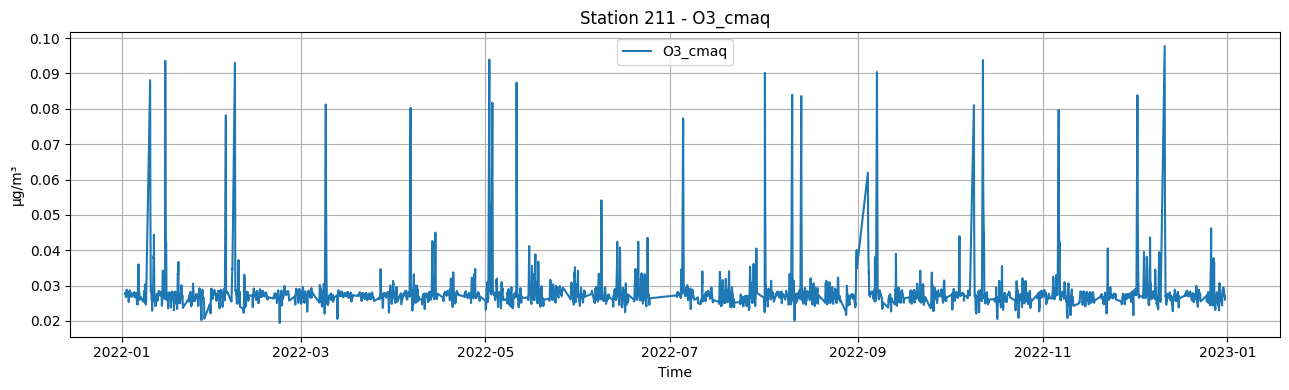

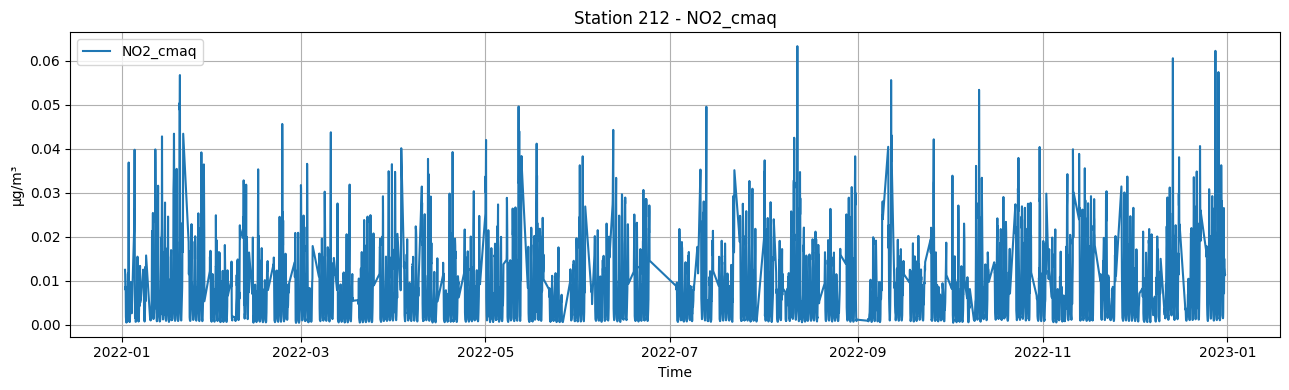

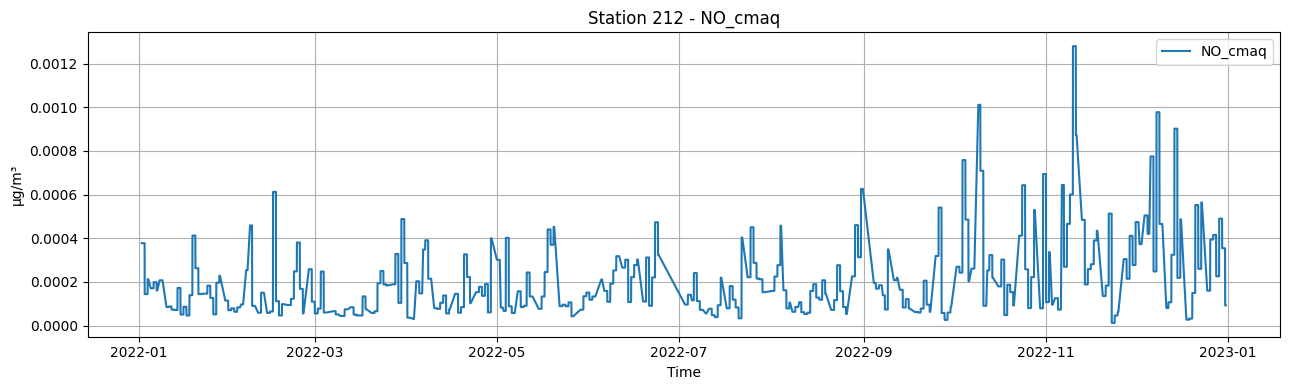

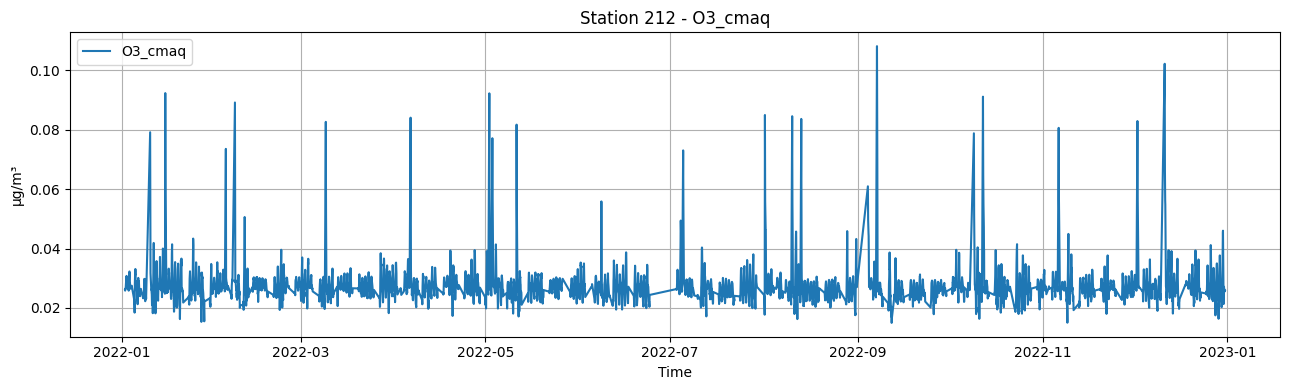

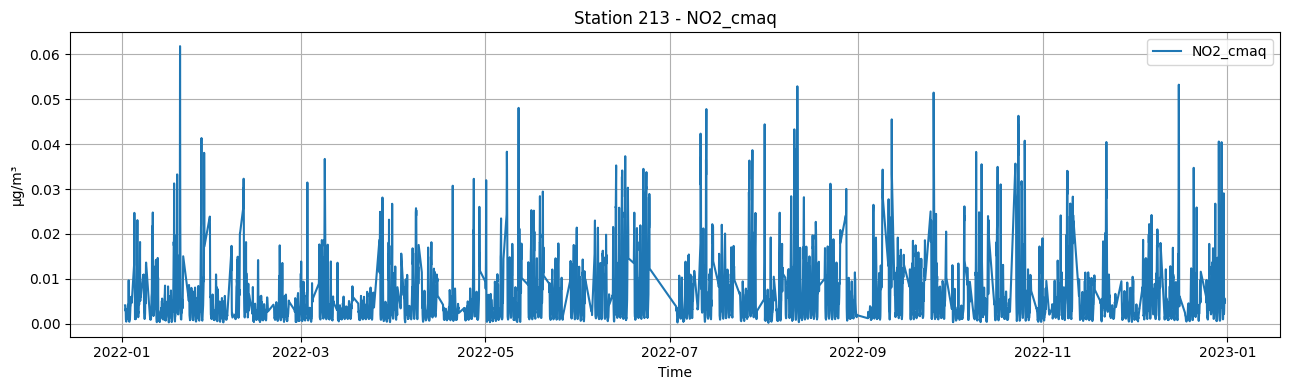

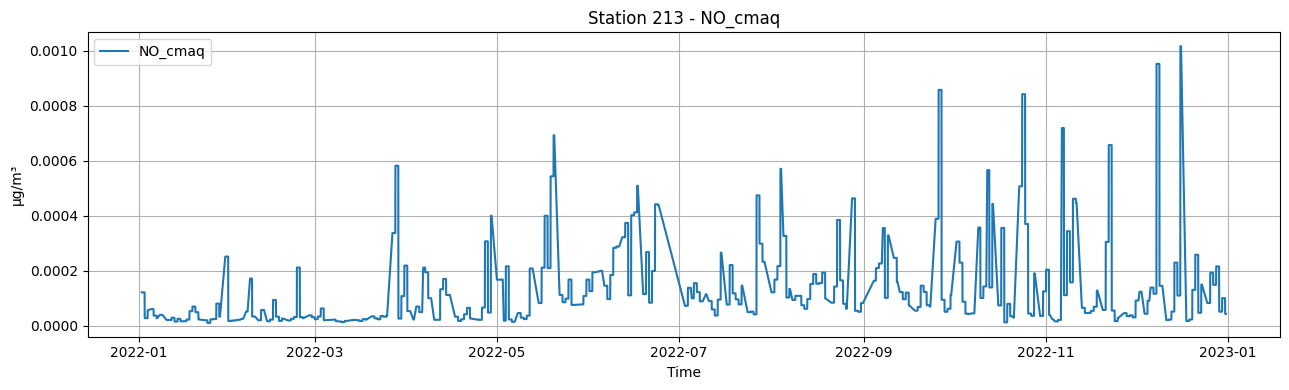

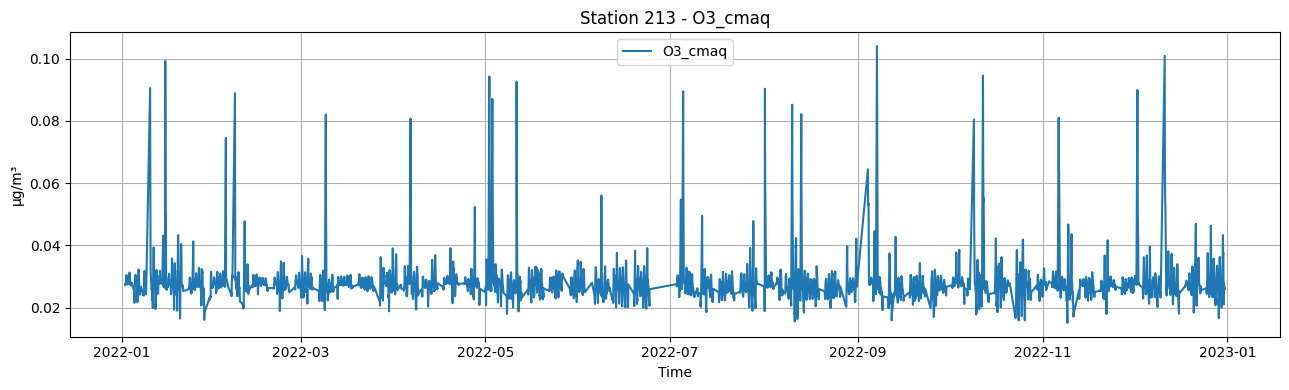

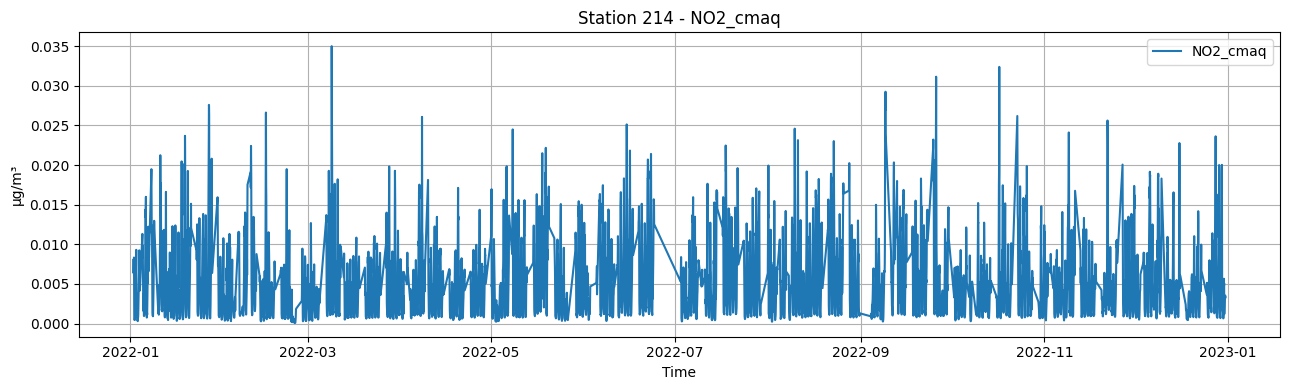

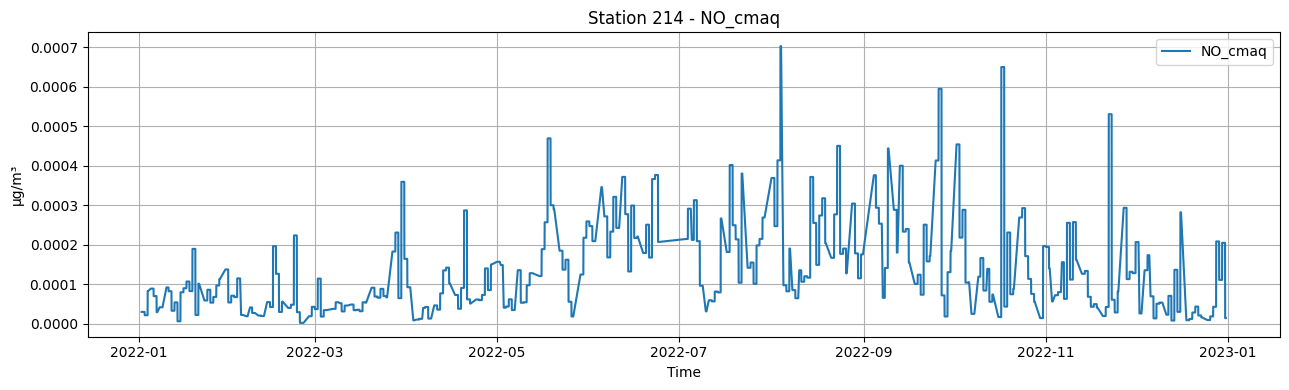

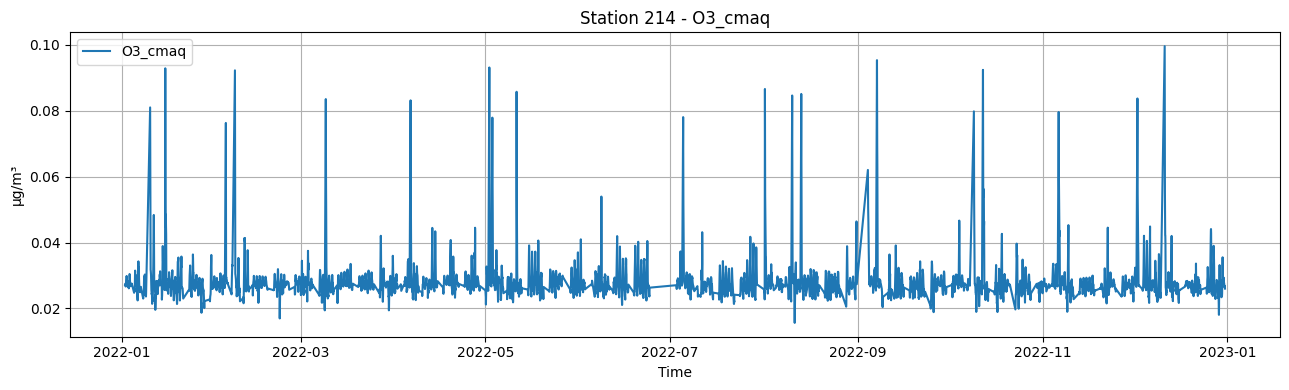

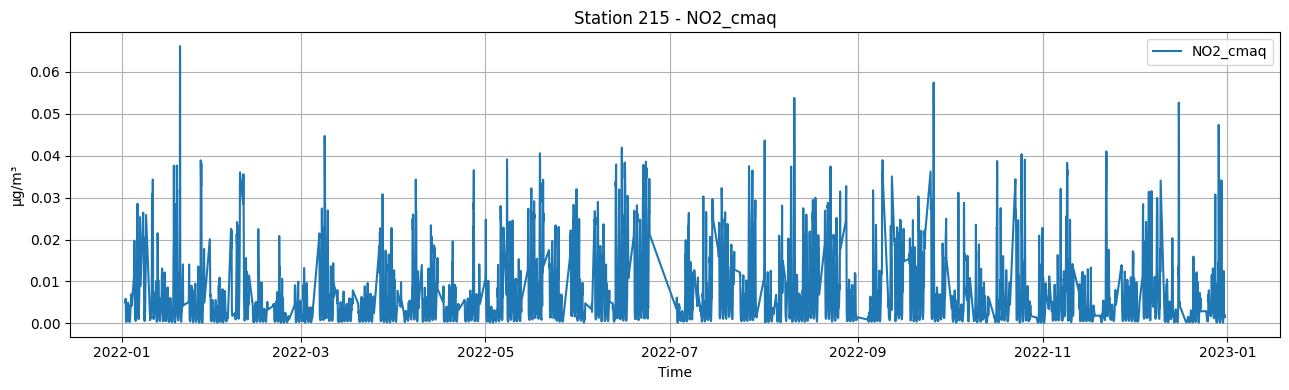

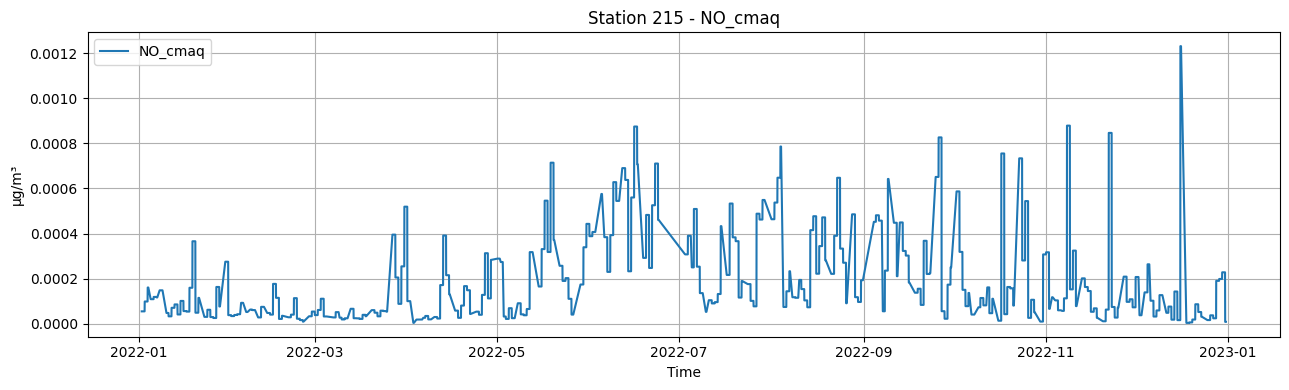

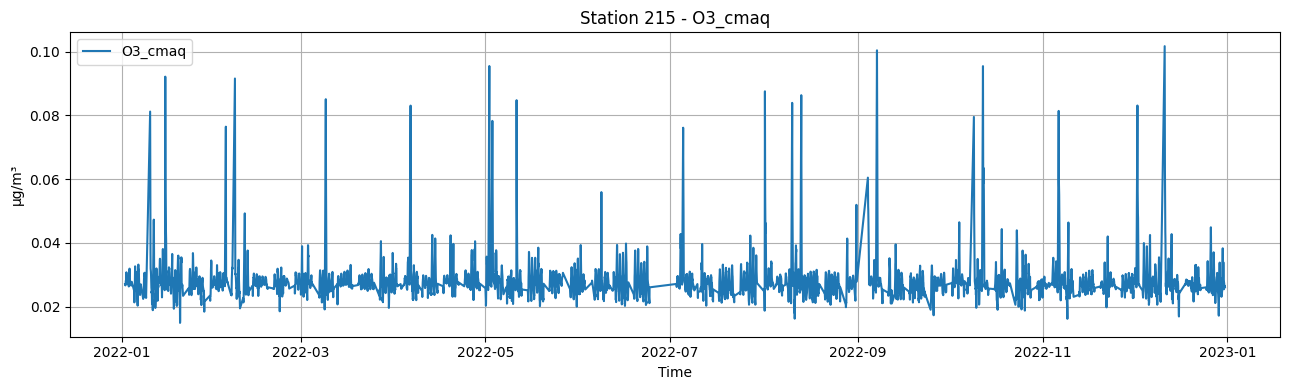

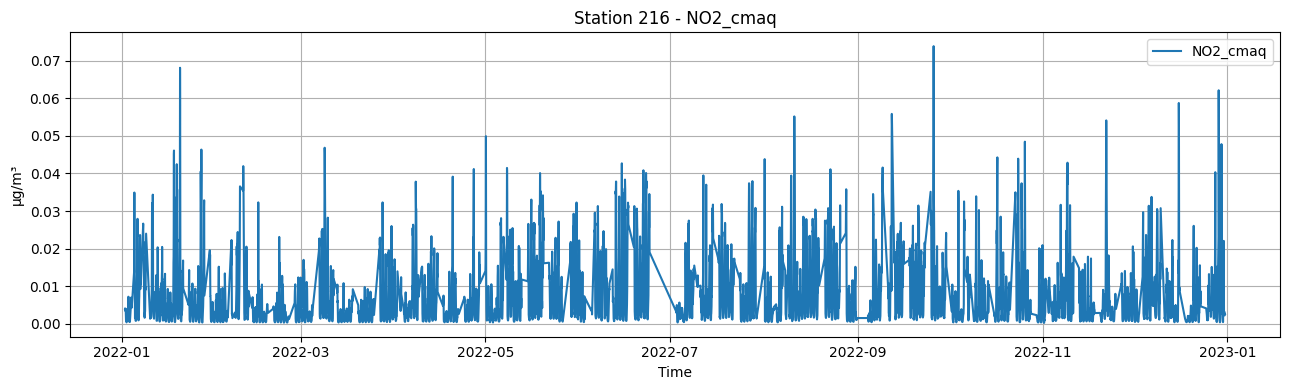

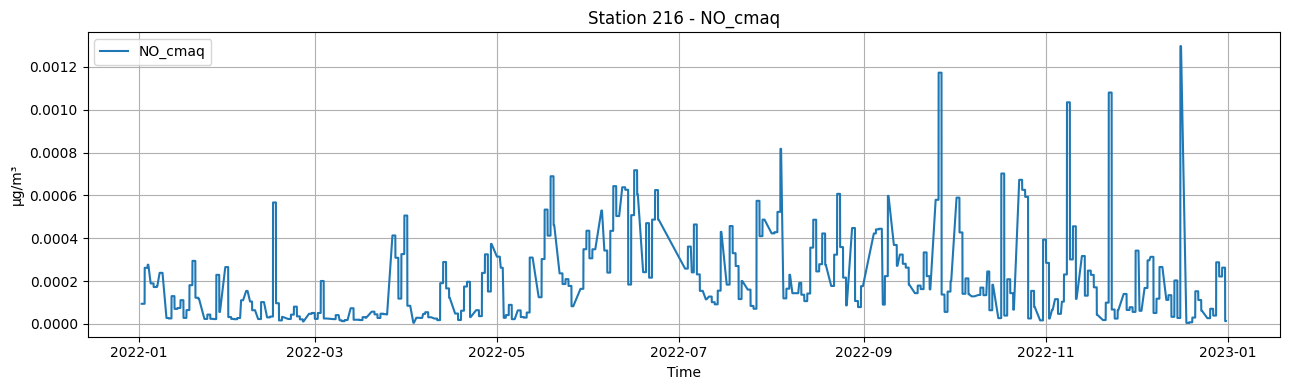

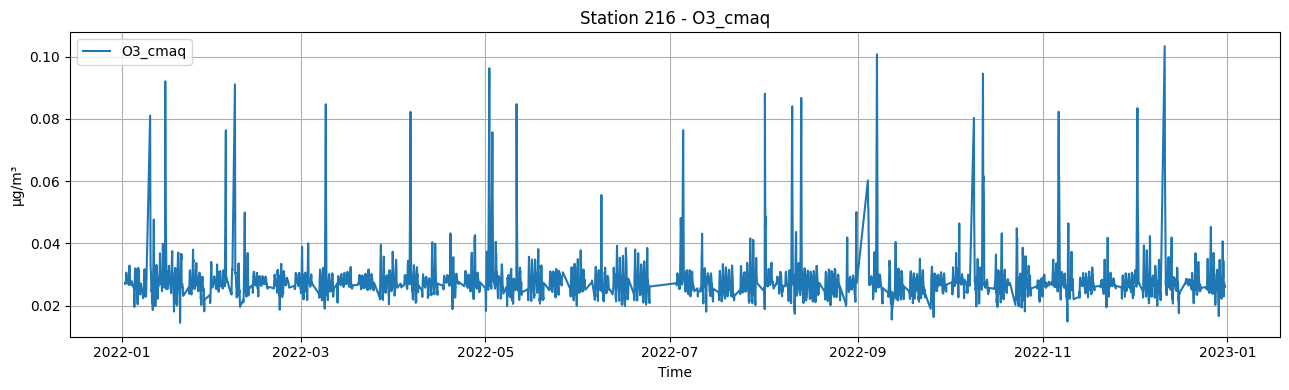

In [6]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [7]:
df_converted = copy.deepcopy(df_dropped)
df_converted.loc[:, "NO2_cmaq"] = df_converted.loc[:, "NO2_cmaq"].apply(lambda x: x * 1883.2)
df_converted.loc[:, "O3_cmaq"] = df_converted.loc[:, "O3_cmaq"].apply(lambda x: x * 1963)
df_converted.loc[:, "NO_cmaq"] = df_converted.loc[:, "NO_cmaq"].apply(lambda x: x * 1228)
df_converted

date   NO2_cmaq   NO_cmaq    O3_cmaq  station_id
0     2022-01-02 00:00:00  11.451346  0.056415  52.999082         201
1     2022-01-02 01:00:00  10.684879  0.056415  52.966078         201
2     2022-01-02 02:00:00  10.015549  0.056415  53.082975         201
3     2022-01-02 03:00:00  10.884442  0.056415  52.346179         201
4     2022-01-02 04:00:00  11.543206  0.056415  52.063844         201
...                   ...        ...       ...        ...         ...
44690 2022-12-31 01:00:00   4.285888  0.016275  51.864199         216
44691 2022-12-31 02:00:00   4.157322  0.016275  51.373838         216
44692 2022-12-31 03:00:00   4.235773  0.016275  51.208808         216
44693 2022-12-31 04:00:00   5.047855  0.016275  51.719656         216
44694 2022-12-31 05:00:00   4.876919  0.016275  51.238619         216

[44695 rows x 5 columns]

## Visualization after converting unit

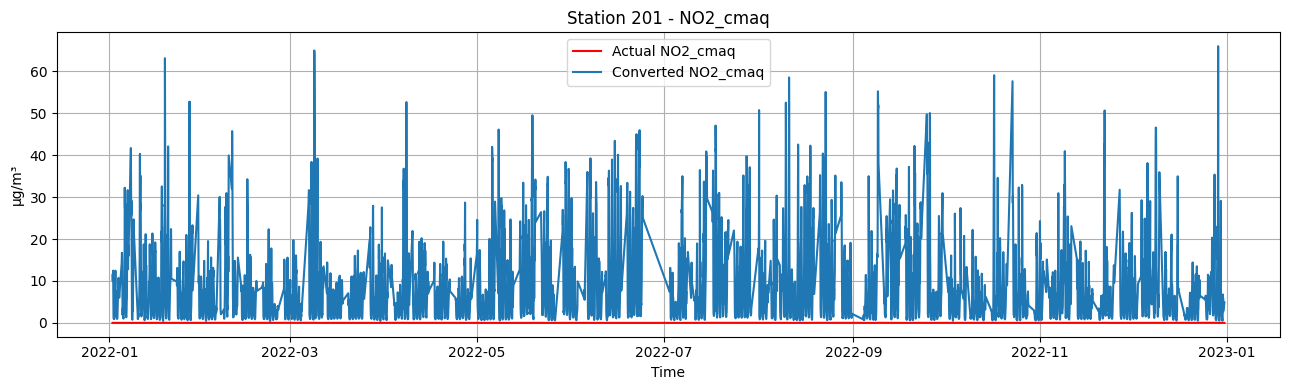

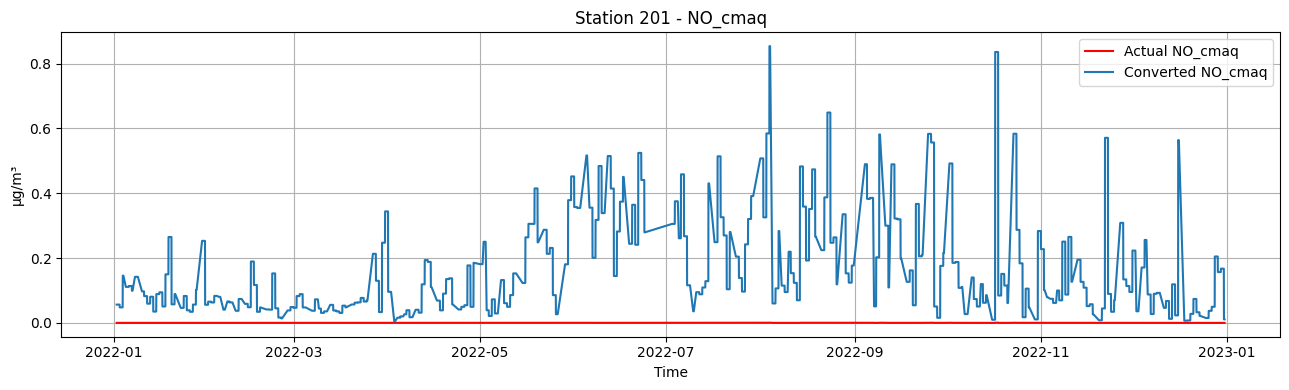

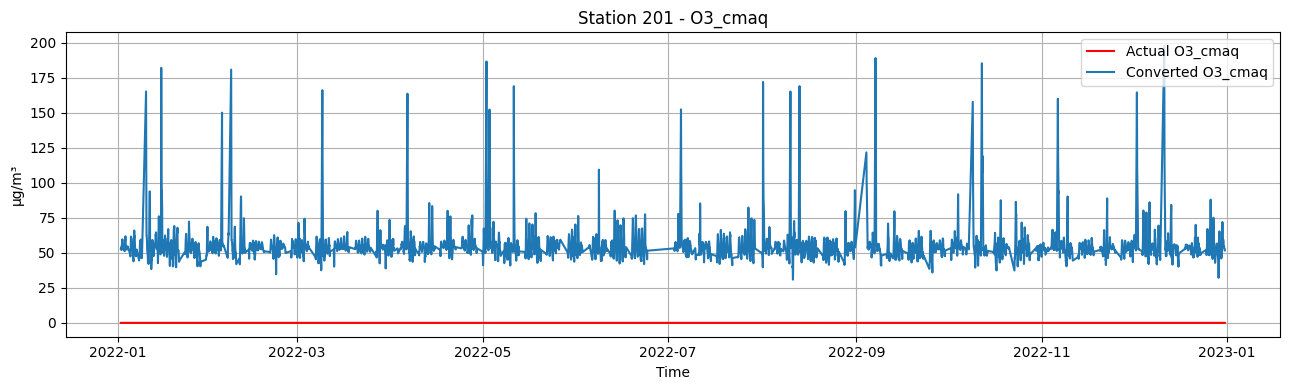

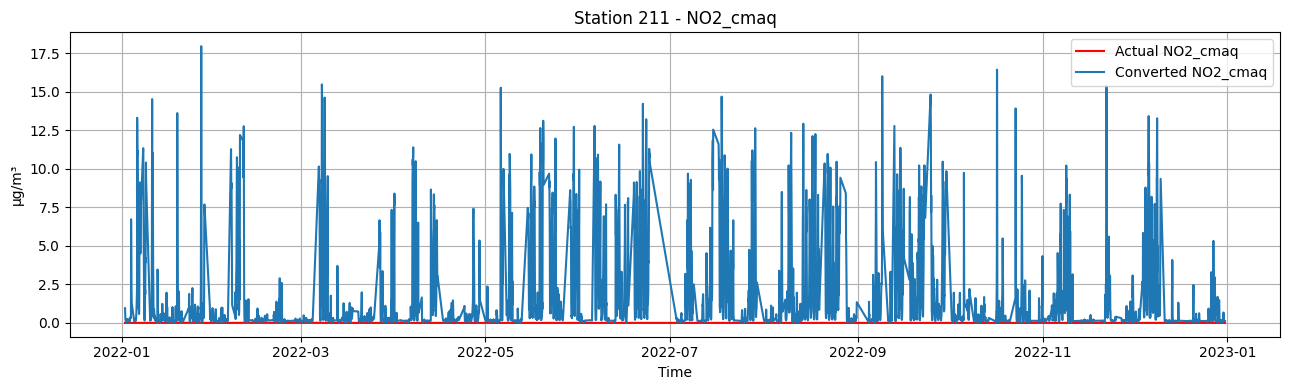

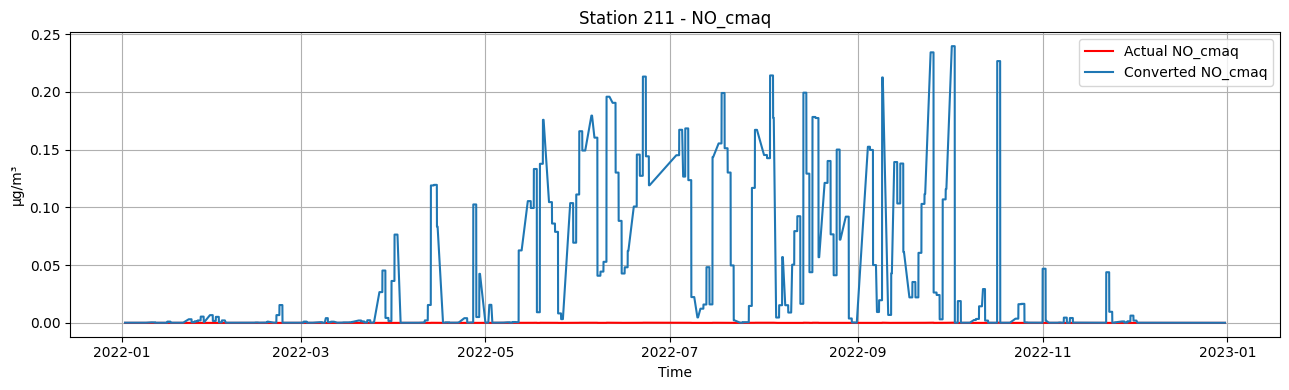

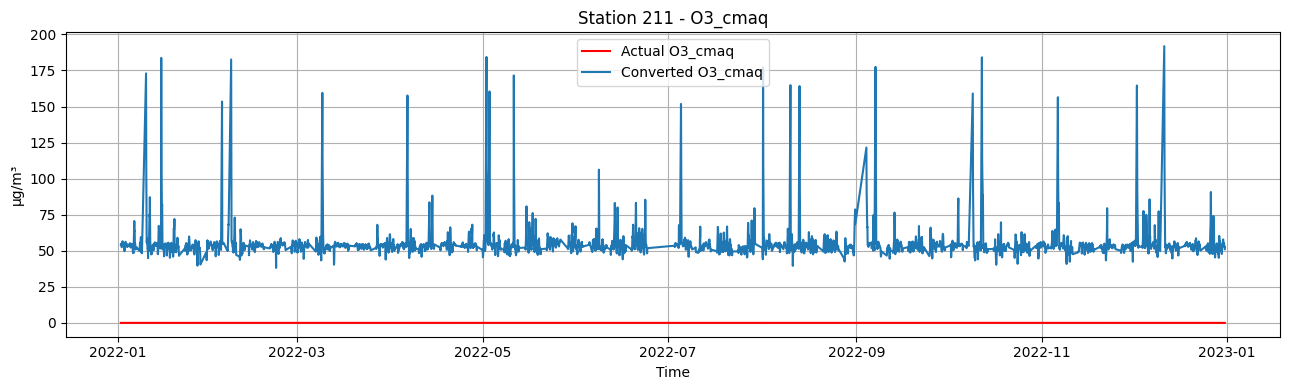

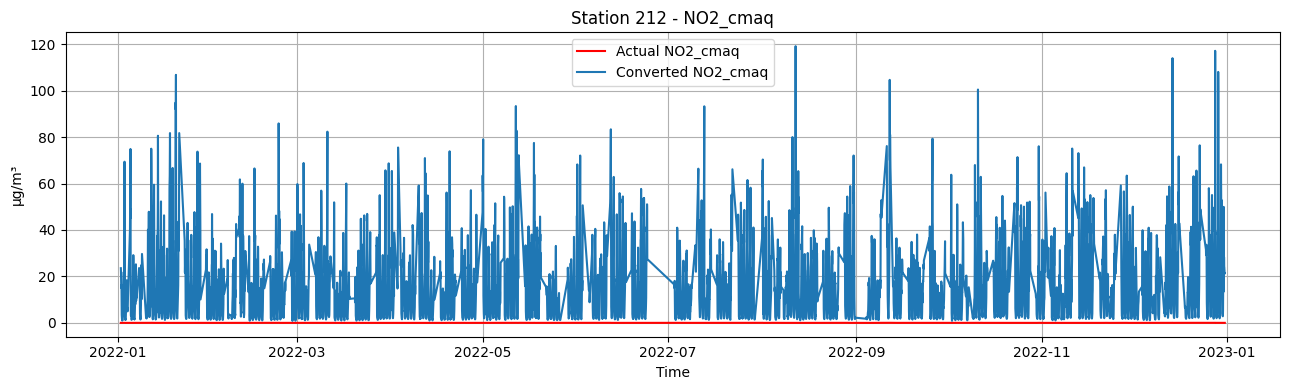

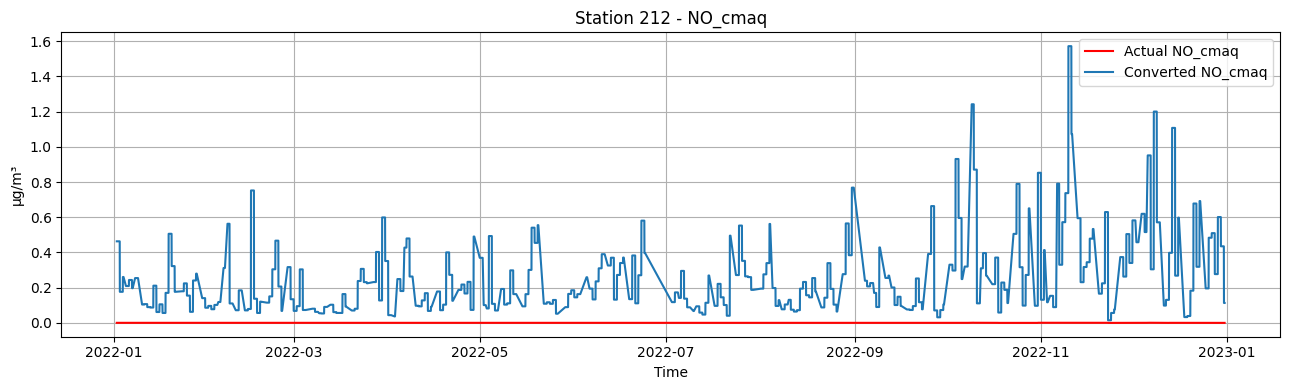

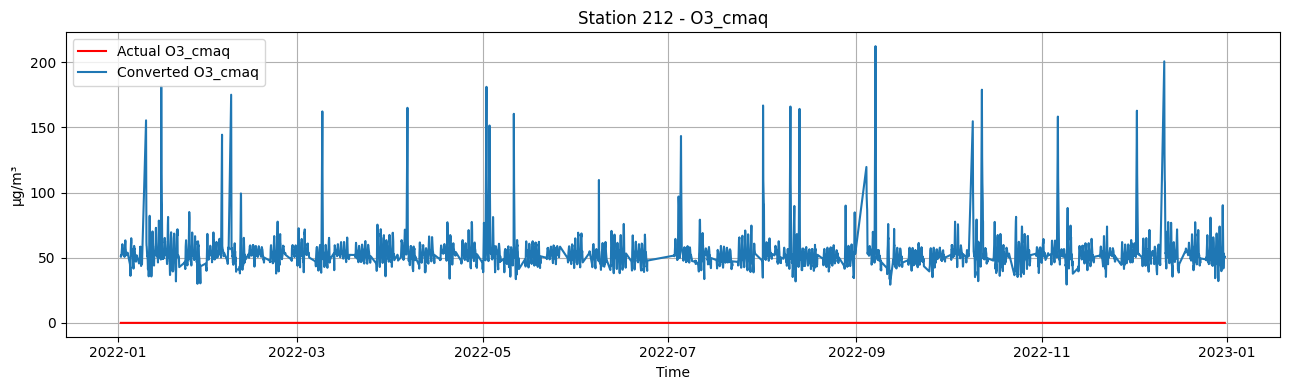

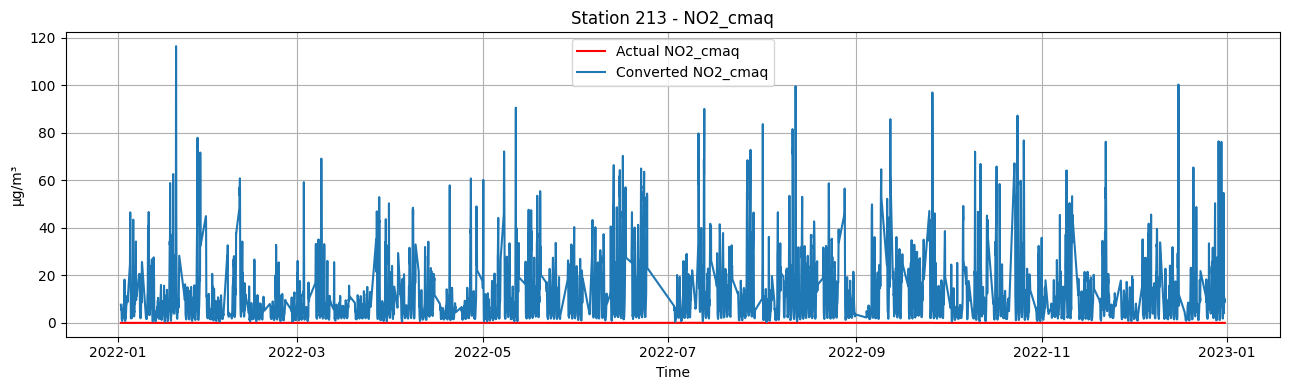

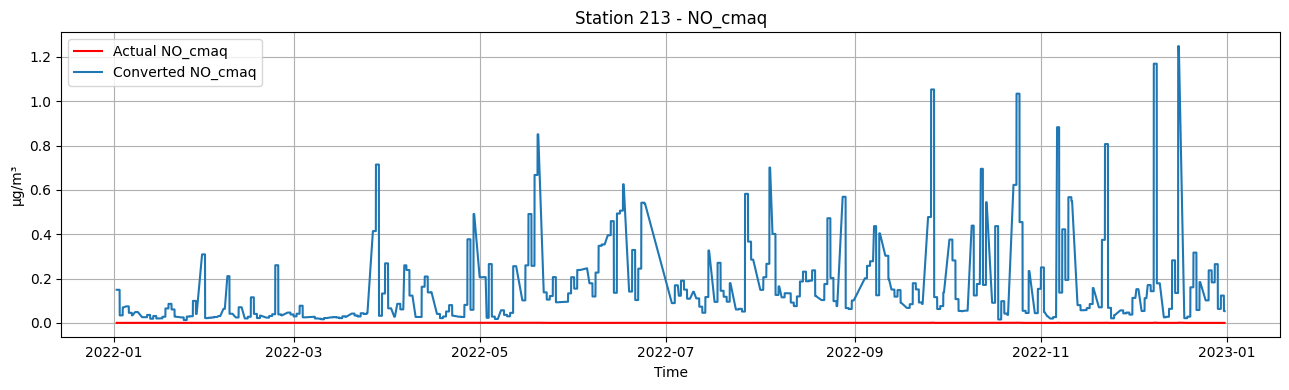

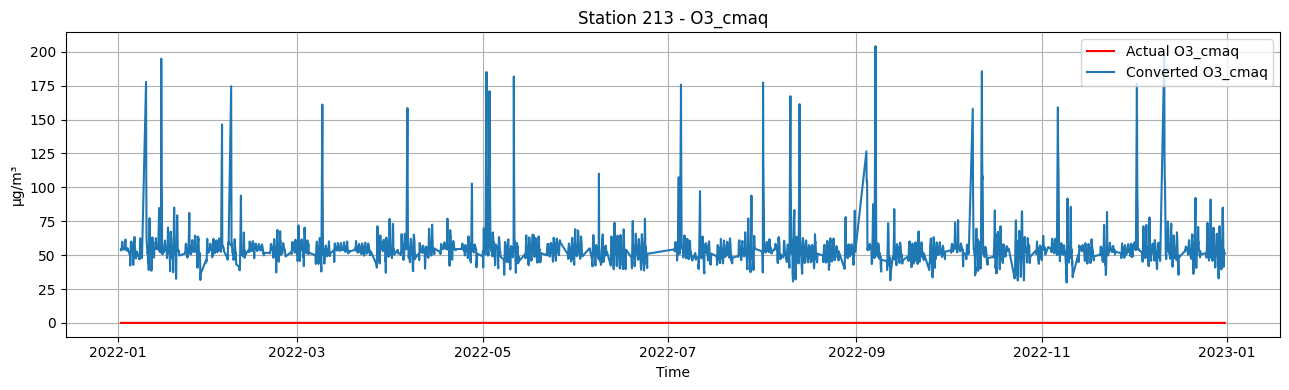

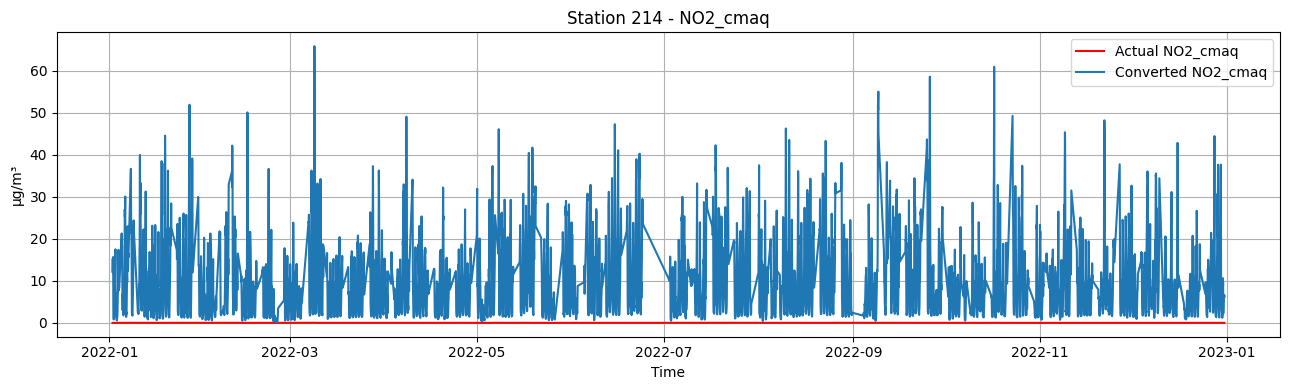

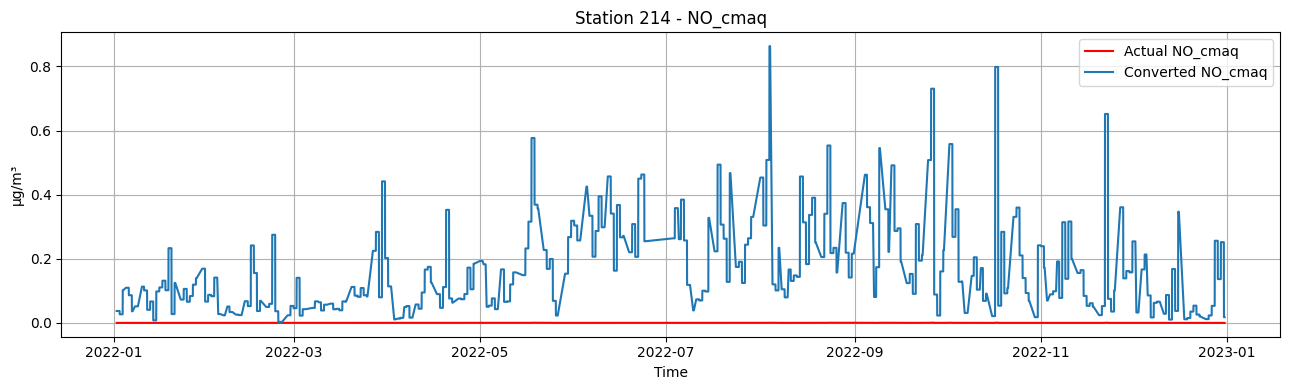

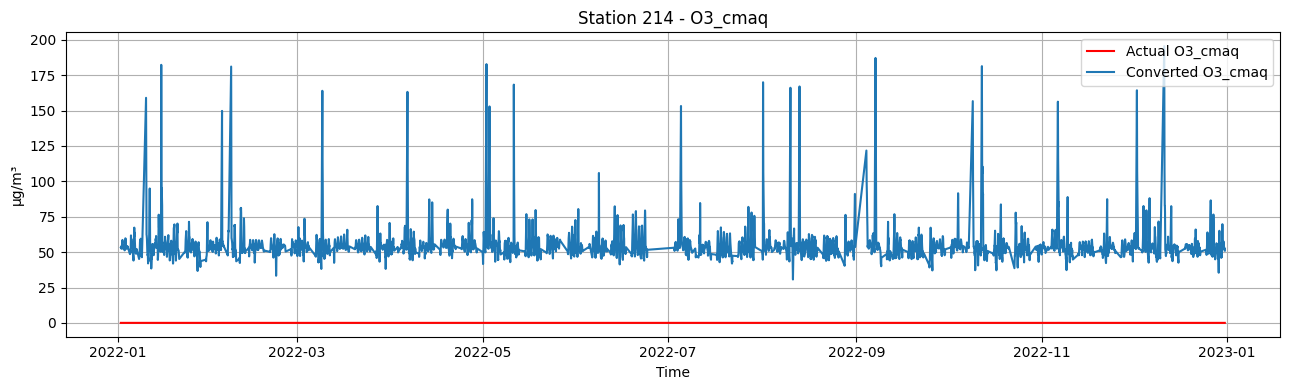

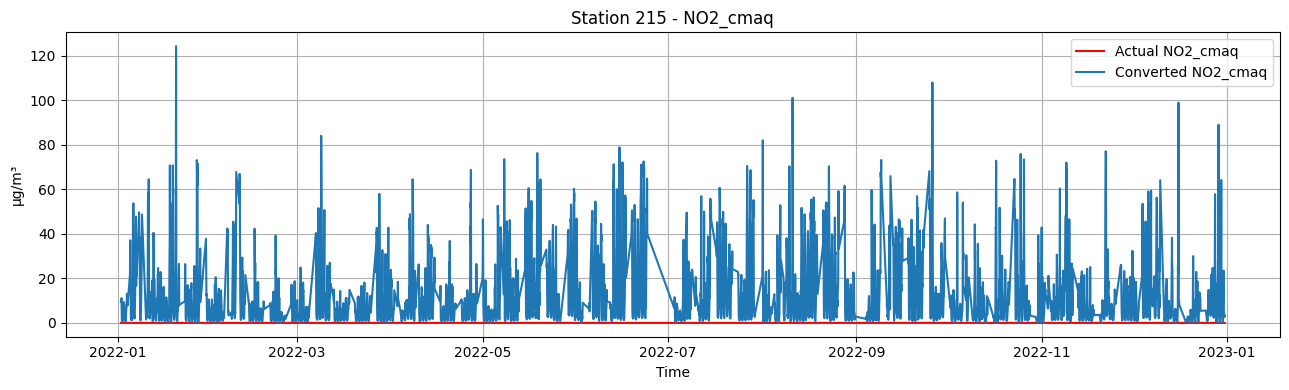

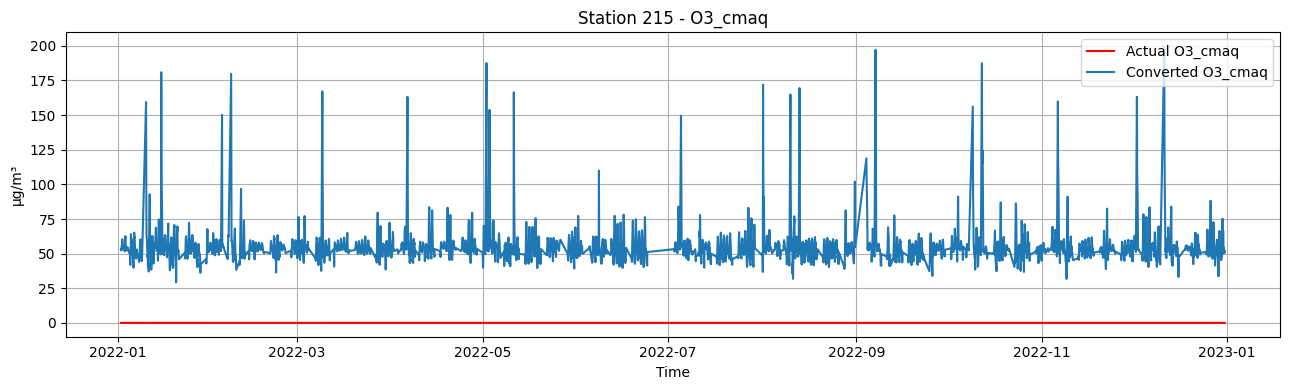

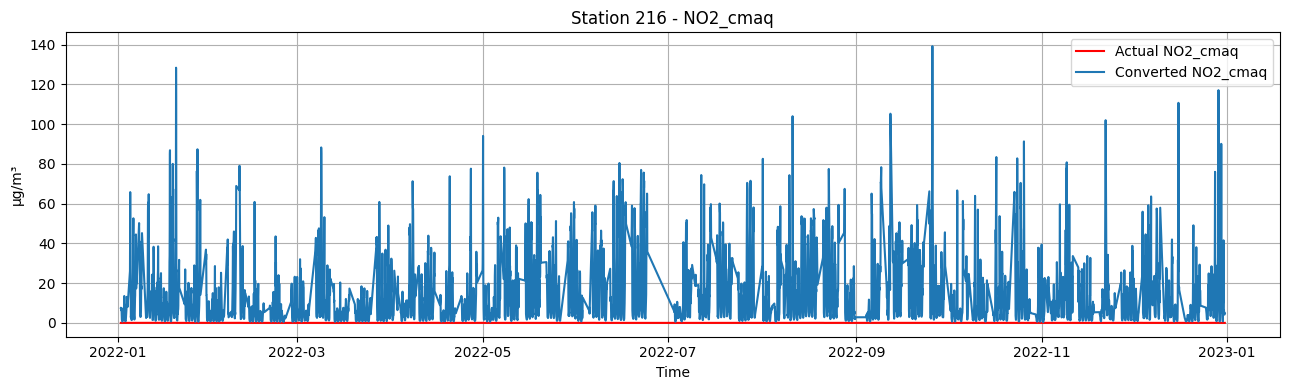

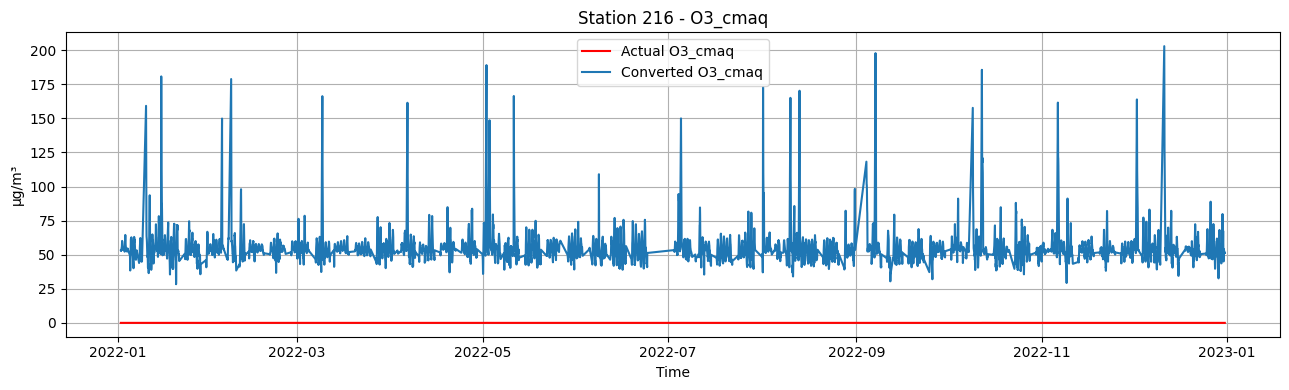

In [8]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [9]:
'''
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# 212 CO quantrac
test212 = test[test["station_id"] == 212]
test = test.drop(index=test212[test212["CO_quantrac"] > 4000].index)

# 213 CO quantrac
test213 = test[test["station_id"] == 213]
test = test.drop(index=test213[test213["CO_quantrac"] > 4000].index)

# 214 CO quantrac
test214 = test[test["station_id"] == 214]
test = test.drop(index=test214[test214["CO_quantrac"] > 4000].index)

# 215 NO2 quantrac
# 215 CO quantrac
test215 = test[test["station_id"] == 215]
test = test.drop(index=test215[test215["NO2_quantrac"] > 140].index)
test = test.drop(index=test215[test215["CO_quantrac"] > 2500].index)

# 216 CO quantrac
test216 = test[test["station_id"] == 216]
test = test.drop(index=test216[test216["CO_quantrac"] > 10000].index)

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)
'''

'\ntest = copy.deepcopy(df_converted)\n\nlenbefore = len(test)\nprint(f"Before: {lenbefore} records")\n\n# 212 CO quantrac\ntest212 = test[test["station_id"] == 212]\ntest = test.drop(index=test212[test212["CO_quantrac"] > 4000].index)\n\n# 213 CO quantrac\ntest213 = test[test["station_id"] == 213]\ntest = test.drop(index=test213[test213["CO_quantrac"] > 4000].index)\n\n# 214 CO quantrac\ntest214 = test[test["station_id"] == 214]\ntest = test.drop(index=test214[test214["CO_quantrac"] > 4000].index)\n\n# 215 NO2 quantrac\n# 215 CO quantrac\ntest215 = test[test["station_id"] == 215]\ntest = test.drop(index=test215[test215["NO2_quantrac"] > 140].index)\ntest = test.drop(index=test215[test215["CO_quantrac"] > 2500].index)\n\n# 216 CO quantrac\ntest216 = test[test["station_id"] == 216]\ntest = test.drop(index=test216[test216["CO_quantrac"] > 10000].index)\n\nlenafter = len(test)\nprint(f"After: {lenafter} records")\nprint(f"Removed {lenbefore - lenafter} records")\n\ndf_converted = test.res

## Visualization after removing outliers

In [10]:
'''
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")
'''

'\nfor station in STATION_IDS:\n    df_station = df_converted[df_converted["station_id"] == station]\n    for target_col in df_station.columns:\n        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:\n            plot_1_data(df_station, target_col, f"Actual {target_col}",\n                        df_station["date"], f"Station {station} - {target_col}")\n                        #df_station.index, f"Station {station} - {target_col}")\n    print("\n" + "=" * 150 + "\n")\n'

## Feature engineering

In [11]:
# Add time features and lag feature for all gases
dftestno2 = add_time_features(df_converted)
dftestno2 = add_lag_features(df_converted, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=[3, 6, 12, 24])
dftestno2 = add_rolling_features(df_converted, group_col="station_id", target_cols=["NO_cmaq"], windows=[3, 6, 12, 24])
print(dftestno2.shape)
print(dftestno2.columns)
dftestno2

(44695, 13)
Index(['date', 'NO2_cmaq', 'NO_cmaq', 'O3_cmaq', 'station_id',
       'NO_cmaq_roll3_mean', 'NO_cmaq_roll3_std', 'NO_cmaq_roll6_mean',
       'NO_cmaq_roll6_std', 'NO_cmaq_roll12_mean', 'NO_cmaq_roll12_std',
       'NO_cmaq_roll24_mean', 'NO_cmaq_roll24_std'],
      dtype='object')


date   NO2_cmaq   NO_cmaq    O3_cmaq  station_id  \
0     2022-01-02 00:00:00  11.451346  0.056415  52.999082         201   
1     2022-01-02 01:00:00  10.684879  0.056415  52.966078         201   
2     2022-01-02 02:00:00  10.015549  0.056415  53.082975         201   
3     2022-01-02 03:00:00  10.884442  0.056415  52.346179         201   
4     2022-01-02 04:00:00  11.543206  0.056415  52.063844         201   
...                   ...        ...       ...        ...         ...   
44690 2022-12-31 01:00:00   4.285888  0.016275  51.864199         216   
44691 2022-12-31 02:00:00   4.157322  0.016275  51.373838         216   
44692 2022-12-31 03:00:00   4.235773  0.016275  51.208808         216   
44693 2022-12-31 04:00:00   5.047855  0.016275  51.719656         216   
44694 2022-12-31 05:00:00   4.876919  0.016275  51.238619         216   

       NO_cmaq_roll3_mean  NO_cmaq_roll3_std  NO_cmaq_roll6_mean  \
0                     NaN                NaN                 NaN   
1                0.056415                NaN            0.056415   
2                0.056415           0.000000            0.056415   
3                0.056415           0.000000            0.056415   
4                0.056415           0.000000            0.056415   
...                   ...                ...                 ...   
44690            0.220592           0.176943            0.271671   
44691            0.118433           0.176943            0.220592   
44692            0.016275           0.000000            0.169513   
44693            0.016275           0.000000            0.118433   
44694            0.016275           0.000000            0.067354   

       NO_cmaq_roll6_std  NO_cmaq_roll12_mean  NO_cmaq_roll12_std  \
0                    NaN                  NaN                 NaN   
1                    NaN             0.056415                 NaN   
2               0.000000             0.056415            0.000000   
3               0.000000             0.056415            0.000000   
4               0.000000             0.056415            0.000000   
...                  ...                  ...                 ...   
44690           0.125118             0.297210            0.088472   
44691           0.158263             0.271671            0.119295   
44692           0.167863             0.246131            0.138609   
44693           0.158263             0.220592            0.150898   
44694           0.125118             0.195052            0.157813   

       NO_cmaq_roll24_mean  NO_cmaq_roll24_std  
0                      NaN                 NaN  
1                 0.056415                 NaN  
2                 0.056415            0.000000  
3                 0.056415            0.000000  
4                 0.056415            0.000000  
...                    ...                 ...  
44690             0.309980            0.062559  
44691             0.297210            0.086527  
44692             0.284441            0.103537  
44693             0.271671            0.116673  
44694             0.258901            0.127142  

[44695 rows x 13 columns]

## Build supervised from time-series

In [12]:
# Example
Xdummy, ydummy = build_supervised_for_horizon(dftestno2, horizon_h=72, target_col="NO2_cmaq")
print("Horizon 1h:", Xdummy.shape, ydummy.shape)
print(Xdummy.columns)
print(ydummy.columns)
display(Xdummy)
display(ydummy)

Horizon 1h: (44189, 12) (44189, 3)
Index(['date', 'station_id', 'NO_cmaq', 'O3_cmaq', 'NO_cmaq_roll3_mean',
       'NO_cmaq_roll3_std', 'NO_cmaq_roll6_mean', 'NO_cmaq_roll6_std',
       'NO_cmaq_roll12_mean', 'NO_cmaq_roll12_std', 'NO_cmaq_roll24_mean',
       'NO_cmaq_roll24_std'],
      dtype='object')
Index(['date', 'station_id', 'NO2_cmaq_t_plus_72h'], dtype='object')


date  station_id   NO_cmaq    O3_cmaq  \
0     2022-01-02 02:00:00         201  0.056415  53.082975   
1     2022-01-02 03:00:00         201  0.056415  52.346179   
2     2022-01-02 04:00:00         201  0.056415  52.063844   
3     2022-01-02 05:00:00         201  0.056415  52.315318   
4     2022-01-02 06:00:00         201  0.056415  54.936436   
...                   ...         ...       ...        ...   
44184 2022-12-28 01:00:00         216  0.353378  41.230542   
44185 2022-12-28 02:00:00         216  0.353378  44.223159   
44186 2022-12-28 03:00:00         216  0.353378  47.612098   
44187 2022-12-28 04:00:00         216  0.353378  49.633424   
44188 2022-12-28 05:00:00         216  0.353378  50.390053   

       NO_cmaq_roll3_mean  NO_cmaq_roll3_std  NO_cmaq_roll6_mean  \
0                0.056415           0.000000            0.056415   
1                0.056415           0.000000            0.056415   
2                0.056415           0.000000            0.056415   
3                0.056415           0.000000            0.056415   
4                0.056415           0.000000            0.056415   
...                   ...                ...                 ...   
44184            0.149740           0.176356            0.098831   
44185            0.251559           0.176356            0.149740   
44186            0.353378           0.000000            0.200650   
44187            0.353378           0.000000            0.251559   
44188            0.353378           0.000000            0.302469   

       NO_cmaq_roll6_std  NO_cmaq_roll12_mean  NO_cmaq_roll12_std  \
0               0.000000             0.056415            0.000000   
1               0.000000             0.056415            0.000000   
2               0.000000             0.056415            0.000000   
3               0.000000             0.056415            0.000000   
4               0.000000             0.056415            0.000000   
...                  ...                  ...                 ...   
44184           0.124702             0.073376            0.088178   
44185           0.157738             0.098831            0.118899   
44186           0.167306             0.124285            0.138148   
44187           0.157738             0.149740            0.150397   
44188           0.124702             0.175195            0.157289   

       NO_cmaq_roll24_mean  NO_cmaq_roll24_std  
0                 0.056415            0.000000  
1                 0.056415            0.000000  
2                 0.056415            0.000000  
3                 0.056415            0.000000  
4                 0.056415            0.000000  
...                    ...                 ...  
44184             0.060648            0.062351  
44185             0.073376            0.086240  
44186             0.086103            0.103193  
44187             0.098831            0.116286  
44188             0.111558            0.126719  

[44189 rows x 12 columns]

date  station_id  NO2_cmaq_t_plus_72h
0     2022-01-02 02:00:00         201             5.230298
1     2022-01-02 03:00:00         201             6.475460
2     2022-01-02 04:00:00         201            11.666098
3     2022-01-02 05:00:00         201            18.261170
4     2022-01-02 06:00:00         201            32.261256
...                   ...         ...                  ...
44184 2022-12-28 01:00:00         216             4.285888
44185 2022-12-28 02:00:00         216             4.157322
44186 2022-12-28 03:00:00         216             4.235773
44187 2022-12-28 04:00:00         216             5.047855
44188 2022-12-28 05:00:00         216             4.876919

[44189 rows x 3 columns]

## Split train/validation/test for each station

In [13]:
# Example
(X_train_dummy, y_train_dummy, meta_train_dummy,
 X_val_dummy, y_val_dummy, meta_val_dummy,
 X_test_dummy, y_test_dummy, meta_test_dummy) = train_test_validation_split(Xdummy, ydummy)
display(X_test_dummy)

NO_cmaq    O3_cmaq  NO_cmaq_roll3_mean  NO_cmaq_roll3_std  \
5364   0.069571  52.445905            0.079672           0.017496   
5365   0.069571  52.831744            0.069571           0.000000   
5366   0.069571  53.134533            0.069571           0.000000   
5367   0.069571  53.502095            0.069571           0.000000   
5368   0.069571  53.751659            0.069571           0.000000   
...         ...        ...                 ...                ...   
44184  0.353378  41.230542            0.149740           0.176356   
44185  0.353378  44.223159            0.251559           0.176356   
44186  0.353378  47.612098            0.353378           0.000000   
44187  0.353378  49.633424            0.353378           0.000000   
44188  0.353378  50.390053            0.353378           0.000000   

       NO_cmaq_roll6_mean  NO_cmaq_roll6_std  NO_cmaq_roll12_mean  \
5364             0.089773           0.015649             0.094824   
5365             0.084723           0.016598             0.092298   
5366             0.079672           0.015649             0.089773   
5367             0.074621           0.012371             0.087248   
5368             0.069571           0.000000             0.084723   
...                   ...                ...                  ...   
44184            0.098831           0.124702             0.073376   
44185            0.149740           0.157738             0.098831   
44186            0.200650           0.167306             0.124285   
44187            0.251559           0.157738             0.149740   
44188            0.302469           0.124702             0.175195   

       NO_cmaq_roll12_std  NO_cmaq_roll24_mean  NO_cmaq_roll24_std  
5364             0.011796             0.089394            0.016799  
5365             0.013705             0.089722            0.016303  
5366             0.014920             0.090051            0.015785  
5367             0.015604             0.090379            0.015243  
5368             0.015825             0.090707            0.014672  
...                   ...                  ...                 ...  
44184            0.088178             0.060648            0.062351  
44185            0.118899             0.073376            0.086240  
44186            0.138148             0.086103            0.103193  
44187            0.150397             0.098831            0.116286  
44188            0.157289             0.111558            0.126719  

[6629 rows x 10 columns]

# LightGBM model

## Add time and lags features

In [14]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_converted)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

## Training for NO_cmaq

In [15]:
label = "NO_cmaq"

# Add rolling features for LABEL
df_no = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)

# Start running model
no_all_metrics = []
no_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_no, horizon_h=h, target_col=label)
    no_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    no_all_metrics.append(metrics_by_station)

# Metrics table
no_df_metrics_all = pd.concat(no_all_metrics, ignore_index=True)
no_df_metrics_all = no_df_metrics_all.sort_values(["station", "horizon_h"]).reset_index(drop=True)
no_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"), index=False)
no_df_metrics_all


===== Training LightGBM for horizon = 1h, target_col = NO_cmaq =====

X.shape = (44520, 27)
y.shape = (44520, 3)

Number of features: 27

Features:
date
station_id
NO2_cmaq
O3_cmaq
hour
dayofweek
month
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
NO_cmaq_lag3
NO_cmaq_lag6
NO_cmaq_lag12
NO_cmaq_lag24
O3_cmaq_lag3
O3_cmaq_lag6
O3_cmaq_lag12
O3_cmaq_lag24
NO_cmaq_roll3_mean
NO_cmaq_roll3_std
NO_cmaq_roll6_mean
NO_cmaq_roll6_std
NO_cmaq_roll12_mean
NO_cmaq_roll12_std
NO_cmaq_roll24_mean
NO_cmaq_roll24_std

Label:
date
station_id
NO_cmaq_t_plus_1h

X_train.shape: (31164, 25)
y_train.shape: (31164, 1)
X_val.shape: (6678, 25)
y_val.shape: (6678, 1)
X_test.shape: (6678, 25)
y_test.shape: (6678, 1)
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.0268164	val's rmse: 0.0948343
[200]	train's rmse: 0.0196634	val's rmse: 0.0942585
[300]	train's rmse: 0.0161044	val's rmse: 0.0945523
Early stopping, best iteration is:
[222]	train's rmse: 0.0187339	val'

date    target
0   2022-11-10  0.259499
1   2022-11-13  0.192160
2   2022-11-14  0.125887
3   2022-11-15  0.106333
4   2022-11-16  0.051974
5   2022-11-17  0.056185
6   2022-11-20  0.009585
7   2022-11-21  0.066456
8   2022-11-22  0.550896
9   2022-11-23  0.087045
10  2022-11-24  0.035800
11  2022-11-27  0.301343
12  2022-11-28  0.133356
13  2022-11-29  0.112955
14  2022-11-30  0.100722
15  2022-12-01  0.215297
16  2022-12-02  0.043769
17  2022-12-04  0.174389
18  2022-12-05  0.244673
19  2022-12-06  0.085182
20  2022-12-07  0.030047
21  2022-12-08  0.089885
22  2022-12-09  0.090710
23  2022-12-11  0.047654
24  2022-12-12  0.065268
25  2022-12-13  0.017061
26  2022-12-14  0.114934
27  2022-12-15  0.045794
28  2022-12-18  0.006851
29  2022-12-19  0.008294
30  2022-12-20  0.029732
31  2022-12-21  0.072107
32  2022-12-22  0.032245
33  2022-12-25  0.016020
34  2022-12-26  0.037714
35  2022-12-27  0.056156
36  2022-12-28  0.202838
37  2022-12-29  0.157148
38  2022-12-30  0.160762

date    target
0   2022-11-10  0.256079
1   2022-11-13  0.188678
2   2022-11-14  0.131376
3   2022-11-15  0.111972
4   2022-11-16  0.060963
5   2022-11-17  0.058765
6   2022-11-20  0.017439
7   2022-11-21  0.056163
8   2022-11-22  0.560350
9   2022-11-23  0.100541
10  2022-11-24  0.040051
11  2022-11-27  0.307819
12  2022-11-28  0.137744
13  2022-11-29  0.114506
14  2022-11-30  0.108076
15  2022-12-01  0.215987
16  2022-12-02  0.059440
17  2022-12-04  0.175911
18  2022-12-05  0.240170
19  2022-12-06  0.119183
20  2022-12-07  0.039009
21  2022-12-08  0.100867
22  2022-12-09  0.101904
23  2022-12-11  0.065995
24  2022-12-12  0.071894
25  2022-12-13  0.024973
26  2022-12-14  0.118713
27  2022-12-15  0.037084
28  2022-12-18  0.035092
29  2022-12-19  0.011219
30  2022-12-20  0.034597
31  2022-12-21  0.075444
32  2022-12-22  0.038305
33  2022-12-25  0.022449
34  2022-12-26  0.044174
35  2022-12-27  0.058756
36  2022-12-28  0.209359
37  2022-12-29  0.156784
38  2022-12-30  0.163255

sid = 211, grp =                      date  station_id    y_true    y_pred
11766 2022-11-09 18:00:00         211  0.000127  0.002880
11767 2022-11-09 19:00:00         211  0.000127  0.003788
11768 2022-11-09 20:00:00         211  0.000127  0.002017
11769 2022-11-09 21:00:00         211  0.000127  0.001674
11770 2022-11-09 22:00:00         211  0.000127  0.005848
...                   ...         ...       ...       ...
12715 2022-12-31 00:00:00         211  0.000095  0.011188
12716 2022-12-31 01:00:00         211  0.000095  0.000900
12717 2022-12-31 02:00:00         211  0.000095  0.000937
12718 2022-12-31 03:00:00         211  0.000095  0.000876
12719 2022-12-31 04:00:00         211  0.000095 -0.003032

[954 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 11, 17), datetime.date(2022,

date    target
0   2022-11-10  0.004057
1   2022-11-13  0.000175
2   2022-11-14  0.000195
3   2022-11-15  0.000181
4   2022-11-16  0.000156
5   2022-11-17  0.000147
6   2022-11-20  0.000141
7   2022-11-21  0.001950
8   2022-11-22  0.042408
9   2022-11-23  0.009215
10  2022-11-24  0.000186
11  2022-11-27  0.001217
12  2022-11-28  0.000282
13  2022-11-29  0.001591
14  2022-11-30  0.006117
15  2022-12-01  0.001908
16  2022-12-02  0.000148
17  2022-12-04  0.000163
18  2022-12-05  0.000161
19  2022-12-06  0.000225
20  2022-12-07  0.000165
21  2022-12-08  0.000203
22  2022-12-09  0.000208
23  2022-12-11  0.000136
24  2022-12-12  0.000135
25  2022-12-13  0.000115
26  2022-12-14  0.000210
27  2022-12-15  0.000128
28  2022-12-18  0.000095
29  2022-12-19  0.000081
30  2022-12-20  0.000120
31  2022-12-21  0.000156
32  2022-12-22  0.000158
33  2022-12-25  0.000101
34  2022-12-26  0.000099
35  2022-12-27  0.000102
36  2022-12-28  0.000221
37  2022-12-29  0.000126
38  2022-12-30  0.000183

date    target
0   2022-11-10  0.006550
1   2022-11-13  0.003935
2   2022-11-14  0.001960
3   2022-11-15  0.002269
4   2022-11-16  0.001760
5   2022-11-17  0.001834
6   2022-11-20  0.003882
7   2022-11-21  0.003591
8   2022-11-22  0.047476
9   2022-11-23  0.018136
10  2022-11-24  0.004644
11  2022-11-27  0.002996
12  2022-11-28  0.003031
13  2022-11-29  0.001764
14  2022-11-30  0.008581
15  2022-12-01  0.004194
16  2022-12-02  0.004088
17  2022-12-04  0.005698
18  2022-12-05  0.001980
19  2022-12-06  0.009078
20  2022-12-07  0.001781
21  2022-12-08  0.004648
22  2022-12-09  0.005002
23  2022-12-11  0.005875
24  2022-12-12  0.002222
25  2022-12-13  0.002904
26  2022-12-14  0.002700
27  2022-12-15  0.001705
28  2022-12-18  0.003684
29  2022-12-19  0.001318
30  2022-12-20  0.001736
31  2022-12-21  0.001978
32  2022-12-22  0.000731
33  2022-12-25  0.003409
34  2022-12-26  0.003724
35  2022-12-27  0.003672
36  2022-12-28  0.004336
37  2022-12-29  0.002117
38  2022-12-30  0.002139

sid = 212, grp =                      date  station_id    y_true    y_pred
18126 2022-11-09 18:00:00         212  0.737093  0.693673
18127 2022-11-09 19:00:00         212  0.737093  0.686338
18128 2022-11-09 20:00:00         212  0.737093  0.721348
18129 2022-11-09 21:00:00         212  0.737093  0.730471
18130 2022-11-09 22:00:00         212  0.737093  0.715610
...                   ...         ...       ...       ...
19075 2022-12-31 00:00:00         212  0.113139  0.182449
19076 2022-12-31 01:00:00         212  0.113139  0.131231
19077 2022-12-31 02:00:00         212  0.113139  0.112120
19078 2022-12-31 03:00:00         212  0.113139  0.130556
19079 2022-12-31 04:00:00         212  0.113139  0.121317

[954 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 11, 17), datetime.date(2022,

date    target
0   2022-11-10  1.551047
1   2022-11-13  0.579599
2   2022-11-14  0.234792
3   2022-11-15  0.318514
4   2022-11-16  0.350167
5   2022-11-17  0.480883
6   2022-11-20  0.168481
7   2022-11-21  0.241603
8   2022-11-22  0.603968
9   2022-11-23  0.016542
10  2022-11-24  0.057303
11  2022-11-27  0.369167
12  2022-11-28  0.273113
13  2022-11-29  0.497520
14  2022-11-30  0.350485
15  2022-12-01  0.577077
16  2022-12-02  0.467623
17  2022-12-04  0.615217
18  2022-12-05  0.544917
19  2022-12-06  0.924396
20  2022-12-07  0.341674
21  2022-12-08  1.174179
22  2022-12-09  0.551606
23  2022-12-11  0.100225
24  2022-12-12  0.141910
25  2022-12-13  0.427530
26  2022-12-14  1.072642
27  2022-12-15  0.282108
28  2022-12-18  0.033246
29  2022-12-19  0.045125
30  2022-12-20  0.203590
31  2022-12-21  0.663016
32  2022-12-22  0.334268
33  2022-12-25  0.208018
34  2022-12-26  0.484804
35  2022-12-27  0.500075
36  2022-12-28  0.290591
37  2022-12-29  0.594328
38  2022-12-30  0.421616

date    target
0   2022-11-10  0.855648
1   2022-11-13  0.543830
2   2022-11-14  0.250572
3   2022-11-15  0.326131
4   2022-11-16  0.358354
5   2022-11-17  0.467150
6   2022-11-20  0.169413
7   2022-11-21  0.232986
8   2022-11-22  0.611180
9   2022-11-23  0.043741
10  2022-11-24  0.060806
11  2022-11-27  0.377764
12  2022-11-28  0.297545
13  2022-11-29  0.508311
14  2022-11-30  0.352771
15  2022-12-01  0.552167
16  2022-12-02  0.431779
17  2022-12-04  0.591658
18  2022-12-05  0.516057
19  2022-12-06  0.807124
20  2022-12-07  0.313112
21  2022-12-08  0.818133
22  2022-12-09  0.534433
23  2022-12-11  0.140458
24  2022-12-12  0.142205
25  2022-12-13  0.406767
26  2022-12-14  0.831220
27  2022-12-15  0.302937
28  2022-12-18  0.059445
29  2022-12-19  0.046905
30  2022-12-20  0.192612
31  2022-12-21  0.669268
32  2022-12-22  0.345493
33  2022-12-25  0.214193
34  2022-12-26  0.486312
35  2022-12-27  0.516609
36  2022-12-28  0.302431
37  2022-12-29  0.625837
38  2022-12-30  0.418133

sid = 213, grp =                      date  station_id   y_true    y_pred
24486 2022-11-09 18:00:00         213  0.19398  0.193144
24487 2022-11-09 19:00:00         213  0.19398  0.193503
24488 2022-11-09 20:00:00         213  0.19398  0.193923
24489 2022-11-09 21:00:00         213  0.19398  0.195793
24490 2022-11-09 22:00:00         213  0.19398  0.195039
...                   ...         ...      ...       ...
25435 2022-12-31 00:00:00         213  0.05312  0.069090
25436 2022-12-31 01:00:00         213  0.05312  0.086983
25437 2022-12-31 02:00:00         213  0.05312  0.059584
25438 2022-12-31 03:00:00         213  0.05312  0.055342
25439 2022-12-31 04:00:00         213  0.05312  0.055536

[954 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 11, 17), datetime.date(2022, 11, 18), da

date    target
0   2022-11-10  0.566501
1   2022-11-13  0.079169
2   2022-11-14  0.057083
3   2022-11-15  0.057985
4   2022-11-16  0.067374
5   2022-11-17  0.088080
6   2022-11-20  0.083073
7   2022-11-21  0.392667
8   2022-11-22  0.776084
9   2022-11-23  0.066011
10  2022-11-24  0.021306
11  2022-11-27  0.055853
12  2022-11-28  0.043170
13  2022-11-29  0.046180
14  2022-11-30  0.040601
15  2022-12-01  0.114397
16  2022-12-02  0.146359
17  2022-12-04  0.056099
18  2022-12-05  0.115471
19  2022-12-06  0.169511
20  2022-12-07  0.185820
21  2022-12-08  1.128193
22  2022-12-09  0.172107
23  2022-12-11  0.025355
24  2022-12-12  0.029013
25  2022-12-13  0.072557
26  2022-12-14  0.276069
27  2022-12-15  0.181404
28  2022-12-18  0.021593
29  2022-12-19  0.033728
30  2022-12-20  0.167033
31  2022-12-21  0.306372
32  2022-12-22  0.063460
33  2022-12-25  0.107176
34  2022-12-26  0.234669
35  2022-12-27  0.186255
36  2022-12-28  0.256623
37  2022-12-29  0.065684
38  2022-12-30  0.120308

date    target
0   2022-11-10  0.544631
1   2022-11-13  0.091571
2   2022-11-14  0.061042
3   2022-11-15  0.058654
4   2022-11-16  0.071873
5   2022-11-17  0.085792
6   2022-11-20  0.083450
7   2022-11-21  0.389234
8   2022-11-22  0.770036
9   2022-11-23  0.091318
10  2022-11-24  0.027832
11  2022-11-27  0.062657
12  2022-11-28  0.050796
13  2022-11-29  0.052651
14  2022-11-30  0.045490
15  2022-12-01  0.112975
16  2022-12-02  0.153827
17  2022-12-04  0.072047
18  2022-12-05  0.120907
19  2022-12-06  0.182056
20  2022-12-07  0.145311
21  2022-12-08  0.804525
22  2022-12-09  0.199402
23  2022-12-11  0.052205
24  2022-12-12  0.034950
25  2022-12-13  0.071703
26  2022-12-14  0.279153
27  2022-12-15  0.140027
28  2022-12-18  0.059033
29  2022-12-19  0.034672
30  2022-12-20  0.160235
31  2022-12-21  0.305133
32  2022-12-22  0.075339
33  2022-12-25  0.108274
34  2022-12-26  0.240311
35  2022-12-27  0.190604
36  2022-12-28  0.262640
37  2022-12-29  0.084713
38  2022-12-30  0.123771

sid = 214, grp =                      date  station_id    y_true    y_pred
30846 2022-11-09 18:00:00         214  0.137553  0.134409
30847 2022-11-09 19:00:00         214  0.137553  0.134160
30848 2022-11-09 20:00:00         214  0.137553  0.134559
30849 2022-11-09 21:00:00         214  0.137553  0.134545
30850 2022-11-09 22:00:00         214  0.137553  0.134635
...                   ...         ...       ...       ...
31795 2022-12-31 00:00:00         214  0.017784  0.151873
31796 2022-12-31 01:00:00         214  0.017784  0.070389
31797 2022-12-31 02:00:00         214  0.017784  0.048823
31798 2022-12-31 03:00:00         214  0.017784  0.027018
31799 2022-12-31 04:00:00         214  0.017784  0.024454

[954 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 11, 17), datetime.date(2022,

date    target
0   2022-11-10  0.311378
1   2022-11-13  0.156059
2   2022-11-14  0.161139
3   2022-11-15  0.082842
4   2022-11-16  0.053456
5   2022-11-17  0.060826
6   2022-11-20  0.025418
7   2022-11-21  0.077391
8   2022-11-22  0.627654
9   2022-11-23  0.073304
10  2022-11-24  0.038125
11  2022-11-27  0.351373
12  2022-11-28  0.139932
13  2022-11-29  0.161641
14  2022-11-30  0.161596
15  2022-12-01  0.245020
16  2022-12-02  0.040292
17  2022-12-04  0.168645
18  2022-12-05  0.204884
19  2022-12-06  0.082784
20  2022-12-07  0.018984
21  2022-12-08  0.062750
22  2022-12-09  0.064525
23  2022-12-11  0.031843
24  2022-12-12  0.083779
25  2022-12-13  0.016916
26  2022-12-14  0.162601
27  2022-12-15  0.050232
28  2022-12-18  0.011517
29  2022-12-19  0.016144
30  2022-12-20  0.035979
31  2022-12-21  0.052589
32  2022-12-22  0.025705
33  2022-12-25  0.012247
34  2022-12-26  0.024405
35  2022-12-27  0.061614
36  2022-12-28  0.251192
37  2022-12-29  0.141394
38  2022-12-30  0.242129

date    target
0   2022-11-10  0.305428
1   2022-11-13  0.158645
2   2022-11-14  0.162380
3   2022-11-15  0.088609
4   2022-11-16  0.060409
5   2022-11-17  0.066035
6   2022-11-20  0.030906
7   2022-11-21  0.063177
8   2022-11-22  0.633679
9   2022-11-23  0.096855
10  2022-11-24  0.040872
11  2022-11-27  0.353004
12  2022-11-28  0.141721
13  2022-11-29  0.163515
14  2022-11-30  0.166906
15  2022-12-01  0.237516
16  2022-12-02  0.058050
17  2022-12-04  0.165833
18  2022-12-05  0.206764
19  2022-12-06  0.108988
20  2022-12-07  0.028174
21  2022-12-08  0.070688
22  2022-12-09  0.076245
23  2022-12-11  0.047487
24  2022-12-12  0.090251
25  2022-12-13  0.023284
26  2022-12-14  0.160538
27  2022-12-15  0.051397
28  2022-12-18  0.035409
29  2022-12-19  0.019705
30  2022-12-20  0.040459
31  2022-12-21  0.058396
32  2022-12-22  0.032429
33  2022-12-25  0.022067
34  2022-12-26  0.031832
35  2022-12-27  0.066139
36  2022-12-28  0.245062
37  2022-12-29  0.146352
38  2022-12-30  0.243926

sid = 215, grp =                      date  station_id    y_true    y_pred
37206 2022-11-09 18:00:00         215  0.186835  0.181530
37207 2022-11-09 19:00:00         215  0.186835  0.183525
37208 2022-11-09 20:00:00         215  0.186835  0.184273
37209 2022-11-09 21:00:00         215  0.186835  0.190550
37210 2022-11-09 22:00:00         215  0.186835  0.191345
...                   ...         ...       ...       ...
38155 2022-12-31 00:00:00         215  0.009513  0.244609
38156 2022-12-31 01:00:00         215  0.009513  0.055866
38157 2022-12-31 02:00:00         215  0.009513  0.035814
38158 2022-12-31 03:00:00         215  0.009513  0.021159
38159 2022-12-31 04:00:00         215  0.009513  0.019728

[954 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 11, 17), datetime.date(2022,

date    target
0   2022-11-10  0.385466
1   2022-11-13  0.244822
2   2022-11-14  0.198691
3   2022-11-15  0.173035
4   2022-11-16  0.065378
5   2022-11-17  0.081098
6   2022-11-20  0.015481
7   2022-11-21  0.116618
8   2022-11-22  1.000336
9   2022-11-23  0.088335
10  2022-11-24  0.035209
11  2022-11-27  0.250408
12  2022-11-28  0.119320
13  2022-11-29  0.130903
14  2022-11-30  0.095755
15  2022-12-01  0.245458
16  2022-12-02  0.052988
17  2022-12-04  0.176722
18  2022-12-05  0.310178
19  2022-12-06  0.121282
20  2022-12-07  0.040050
21  2022-12-08  0.075321
22  2022-12-09  0.151307
23  2022-12-11  0.060986
24  2022-12-12  0.089946
25  2022-12-13  0.028073
26  2022-12-14  0.168529
27  2022-12-15  0.081286
28  2022-12-18  0.004110
29  2022-12-19  0.007230
30  2022-12-20  0.025685
31  2022-12-21  0.103768
32  2022-12-22  0.062165
33  2022-12-25  0.020418
34  2022-12-26  0.044497
35  2022-12-27  0.037529
36  2022-12-28  0.233658
37  2022-12-29  0.244995
38  2022-12-30  0.268472

date    target
0   2022-11-10  0.383961
1   2022-11-13  0.235903
2   2022-11-14  0.202070
3   2022-11-15  0.177127
4   2022-11-16  0.073754
5   2022-11-17  0.081623
6   2022-11-20  0.021837
7   2022-11-21  0.085181
8   2022-11-22  0.829398
9   2022-11-23  0.117771
10  2022-11-24  0.040111
11  2022-11-27  0.248124
12  2022-11-28  0.126293
13  2022-11-29  0.130533
14  2022-11-30  0.102540
15  2022-12-01  0.239081
16  2022-12-02  0.070282
17  2022-12-04  0.190400
18  2022-12-05  0.314083
19  2022-12-06  0.161045
20  2022-12-07  0.050301
21  2022-12-08  0.074300
22  2022-12-09  0.158513
23  2022-12-11  0.078342
24  2022-12-12  0.093442
25  2022-12-13  0.033813
26  2022-12-14  0.173308
27  2022-12-15  0.033847
28  2022-12-18  0.048137
29  2022-12-19  0.007519
30  2022-12-20  0.029913
31  2022-12-21  0.108425
32  2022-12-22  0.068203
33  2022-12-25  0.027247
34  2022-12-26  0.052440
35  2022-12-27  0.038709
36  2022-12-28  0.232705
37  2022-12-29  0.241203
38  2022-12-30  0.280215

sid = 216, grp =                      date  station_id    y_true    y_pred
43566 2022-11-09 18:00:00         216  0.369978  0.356406
43567 2022-11-09 19:00:00         216  0.369978  0.360995
43568 2022-11-09 20:00:00         216  0.369978  0.359723
43569 2022-11-09 21:00:00         216  0.369978  0.350501
43570 2022-11-09 22:00:00         216  0.369978  0.347444
...                   ...         ...       ...       ...
44515 2022-12-31 00:00:00         216  0.016275  0.208404
44516 2022-12-31 01:00:00         216  0.016275  0.058367
44517 2022-12-31 02:00:00         216  0.016275  0.045638
44518 2022-12-31 03:00:00         216  0.016275  0.023034
44519 2022-12-31 04:00:00         216  0.016275  0.024814

[954 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 11, 17), datetime.date(2022,

date    target
0   2022-11-10  0.542533
1   2022-11-13  0.379953
2   2022-11-14  0.168089
3   2022-11-15  0.304692
4   2022-11-16  0.278407
5   2022-11-17  0.203439
6   2022-11-20  0.026390
7   2022-11-21  0.172235
8   2022-11-22  1.275203
9   2022-11-23  0.080443
10  2022-11-24  0.032796
11  2022-11-27  0.168129
12  2022-11-28  0.080615
13  2022-11-29  0.094552
14  2022-11-30  0.083613
15  2022-12-01  0.406036
16  2022-12-02  0.082943
17  2022-12-04  0.212810
18  2022-12-05  0.365712
19  2022-12-06  0.371404
20  2022-12-07  0.066238
21  2022-12-08  0.152354
22  2022-12-09  0.318771
23  2022-12-11  0.139348
24  2022-12-12  0.159633
25  2022-12-13  0.049553
26  2022-12-14  0.240346
27  2022-12-15  0.099020
28  2022-12-18  0.006104
29  2022-12-19  0.010473
30  2022-12-20  0.042696
31  2022-12-21  0.185276
32  2022-12-22  0.134567
33  2022-12-25  0.035250
34  2022-12-26  0.085307
35  2022-12-27  0.060648
36  2022-12-28  0.349992
37  2022-12-29  0.274203
38  2022-12-30  0.309980

date    target
0   2022-11-10  0.531780
1   2022-11-13  0.371576
2   2022-11-14  0.174529
3   2022-11-15  0.308703
4   2022-11-16  0.279035
5   2022-11-17  0.207218
6   2022-11-20  0.032004
7   2022-11-21  0.123502
8   2022-11-22  0.843025
9   2022-11-23  0.124643
10  2022-11-24  0.037370
11  2022-11-27  0.174577
12  2022-11-28  0.088702
13  2022-11-29  0.096159
14  2022-11-30  0.088066
15  2022-12-01  0.396172
16  2022-12-02  0.100356
17  2022-12-04  0.217753
18  2022-12-05  0.354141
19  2022-12-06  0.406143
20  2022-12-07  0.076584
21  2022-12-08  0.148894
22  2022-12-09  0.318349
23  2022-12-11  0.149078
24  2022-12-12  0.165481
25  2022-12-13  0.057230
26  2022-12-14  0.239239
27  2022-12-15  0.046423
28  2022-12-18  0.051070
29  2022-12-19  0.014103
30  2022-12-20  0.044035
31  2022-12-21  0.182508
32  2022-12-22  0.139357
33  2022-12-25  0.041672
34  2022-12-26  0.092365
35  2022-12-27  0.060374
36  2022-12-28  0.347415
37  2022-12-29  0.274474
38  2022-12-30  0.321290

Overall test metrics: {'rmse': 0.1, 'mae': 0.03, 'mape': 320.05, 'mnbe': -273.68, 'r': 0.92, 'n_samples': 6678}

===== Training LightGBM for horizon = 24h, target_col = NO_cmaq =====

X.shape = (44359, 27)
y.shape = (44359, 3)

Number of features: 27

Features:
date
station_id
NO2_cmaq
O3_cmaq
hour
dayofweek
month
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
NO_cmaq_lag3
NO_cmaq_lag6
NO_cmaq_lag12
NO_cmaq_lag24
O3_cmaq_lag3
O3_cmaq_lag6
O3_cmaq_lag12
O3_cmaq_lag24
NO_cmaq_roll3_mean
NO_cmaq_roll3_std
NO_cmaq_roll6_mean
NO_cmaq_roll6_std
NO_cmaq_roll12_mean
NO_cmaq_roll12_std
NO_cmaq_roll24_mean
NO_cmaq_roll24_std

Label:
date
station_id
NO_cmaq_t_plus_24h

X_train.shape: (31045, 25)
y_train.shape: (31045, 1)
X_val.shape: (6657, 25)
y_val.shape: (6657, 1)
X_test.shape: (6657, 25)
y_test.shape: (6657, 1)
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.0656068	val's rmse: 0.26098
Early stopping, best iteration is:
[25]	train's rmse: 0.10602

date    target
0   2022-11-09  0.265267
1   2022-11-10  0.177966
2   2022-11-13  0.126634
3   2022-11-14  0.108707
4   2022-11-15  0.051734
5   2022-11-16  0.057478
6   2022-11-17  0.012658
7   2022-11-20  0.044521
8   2022-11-21  0.570964
9   2022-11-22  0.089337
10  2022-11-23  0.034326
11  2022-11-24  0.248882
12  2022-11-27  0.134210
13  2022-11-28  0.113718
14  2022-11-29  0.095401
15  2022-11-30  0.223100
16  2022-12-01  0.075207
17  2022-12-02  0.170845
18  2022-12-04  0.192813
19  2022-12-05  0.087692
20  2022-12-06  0.027451
21  2022-12-07  0.089765
22  2022-12-08  0.092637
23  2022-12-09  0.052578
24  2022-12-11  0.067556
25  2022-12-12  0.012633
26  2022-12-13  0.118919
27  2022-12-14  0.023268
28  2022-12-15  0.146094
29  2022-12-18  0.007445
30  2022-12-19  0.027816
31  2022-12-20  0.073820
32  2022-12-21  0.032705
33  2022-12-22  0.016745
34  2022-12-25  0.037194
35  2022-12-26  0.049691
36  2022-12-27  0.204844
37  2022-12-28  0.156708
38  2022-12-29  0.167280

date    target
0   2022-11-09  0.210474
1   2022-11-10  0.282598
2   2022-11-13  0.186754
3   2022-11-14  0.149805
4   2022-11-15  0.193496
5   2022-11-16  0.146407
6   2022-11-17  0.144234
7   2022-11-20  0.091195
8   2022-11-21  0.103493
9   2022-11-22  0.234754
10  2022-11-23  0.196644
11  2022-11-24  0.108871
12  2022-11-27  0.269769
13  2022-11-28  0.162063
14  2022-11-29  0.197023
15  2022-11-30  0.185502
16  2022-12-01  0.262114
17  2022-12-02  0.116860
18  2022-12-04  0.198961
19  2022-12-05  0.216334
20  2022-12-06  0.199166
21  2022-12-07  0.108957
22  2022-12-08  0.176718
23  2022-12-09  0.184469
24  2022-12-11  0.131031
25  2022-12-12  0.131225
26  2022-12-13  0.096323
27  2022-12-14  0.161217
28  2022-12-15  0.102618
29  2022-12-18  0.107860
30  2022-12-19  0.079278
31  2022-12-20  0.087171
32  2022-12-21  0.135124
33  2022-12-22  0.106887
34  2022-12-25  0.088655
35  2022-12-26  0.088293
36  2022-12-27  0.168942
37  2022-12-28  0.233469
38  2022-12-29  0.171418

sid = 211, grp =                      date  station_id    y_true   y_pred
11723 2022-11-08 22:00:00         211  0.000127  0.05734
11724 2022-11-08 23:00:00         211  0.000127  0.05734
11725 2022-11-09 00:00:00         211  0.004223  0.05734
11726 2022-11-09 01:00:00         211  0.004223  0.05734
11727 2022-11-09 02:00:00         211  0.004223  0.05734
...                   ...         ...       ...      ...
12669 2022-12-30 01:00:00         211  0.000095  0.05734
12670 2022-12-30 02:00:00         211  0.000095  0.05734
12671 2022-12-30 03:00:00         211  0.000095  0.05734
12672 2022-12-30 04:00:00         211  0.000095  0.05734
12673 2022-12-30 05:00:00         211  0.000095  0.05734

[951 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 11, 17), dat

date    target
0   2022-11-09  0.004223
1   2022-11-10  0.000188
2   2022-11-13  0.000196
3   2022-11-14  0.000182
4   2022-11-15  0.000157
5   2022-11-16  0.000146
6   2022-11-17  0.000144
7   2022-11-20  0.000129
8   2022-11-21  0.043834
9   2022-11-22  0.009608
10  2022-11-23  0.000170
11  2022-11-24  0.001083
12  2022-11-27  0.000234
13  2022-11-28  0.001386
14  2022-11-29  0.006297
15  2022-11-30  0.001985
16  2022-12-01  0.000152
17  2022-12-02  0.000163
18  2022-12-04  0.000183
19  2022-12-05  0.000228
20  2022-12-06  0.000164
21  2022-12-07  0.000203
22  2022-12-08  0.000211
23  2022-12-09  0.000136
24  2022-12-11  0.000136
25  2022-12-12  0.000110
26  2022-12-13  0.000213
27  2022-12-14  0.000127
28  2022-12-15  0.000109
29  2022-12-18  0.000080
30  2022-12-19  0.000119
31  2022-12-20  0.000156
32  2022-12-21  0.000160
33  2022-12-22  0.000107
34  2022-12-25  0.000100
35  2022-12-26  0.000096
36  2022-12-27  0.000226
37  2022-12-28  0.000123
38  2022-12-29  0.000187

date    target
0   2022-11-09  0.057340
1   2022-11-10  0.057340
2   2022-11-13  0.057340
3   2022-11-14  0.057340
4   2022-11-15  0.057340
5   2022-11-16  0.057340
6   2022-11-17  0.057340
7   2022-11-20  0.057340
8   2022-11-21  0.057340
9   2022-11-22  0.108475
10  2022-11-23  0.094623
11  2022-11-24  0.058704
12  2022-11-27  0.057340
13  2022-11-28  0.057340
14  2022-11-29  0.057340
15  2022-11-30  0.057340
16  2022-12-01  0.057340
17  2022-12-02  0.057340
18  2022-12-04  0.057340
19  2022-12-05  0.057340
20  2022-12-06  0.057340
21  2022-12-07  0.057340
22  2022-12-08  0.057340
23  2022-12-09  0.057340
24  2022-12-11  0.057340
25  2022-12-12  0.057340
26  2022-12-13  0.057340
27  2022-12-14  0.057340
28  2022-12-15  0.057340
29  2022-12-18  0.057340
30  2022-12-19  0.057340
31  2022-12-20  0.057340
32  2022-12-21  0.057340
33  2022-12-22  0.057340
34  2022-12-25  0.057340
35  2022-12-26  0.057340
36  2022-12-27  0.057340
37  2022-12-28  0.057340
38  2022-12-29  0.057340

sid = 212, grp =                      date  station_id    y_true    y_pred
18060 2022-11-08 22:00:00         212  0.737093  0.245738
18061 2022-11-08 23:00:00         212  0.737093  0.240681
18062 2022-11-09 00:00:00         212  1.571852  0.249593
18063 2022-11-09 01:00:00         212  1.571852  0.407271
18064 2022-11-09 02:00:00         212  1.571852  0.401058
...                   ...         ...       ...       ...
19006 2022-12-30 01:00:00         212  0.113139  0.344075
19007 2022-12-30 02:00:00         212  0.113139  0.344628
19008 2022-12-30 03:00:00         212  0.113139  0.307536
19009 2022-12-30 04:00:00         212  0.113139  0.295881
19010 2022-12-30 05:00:00         212  0.113139  0.295881

[951 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 

date    target
0   2022-11-09  1.571852
1   2022-11-10  0.714196
2   2022-11-13  0.231202
3   2022-11-14  0.317380
4   2022-11-15  0.344583
5   2022-11-16  0.478603
6   2022-11-17  0.257859
7   2022-11-20  0.224734
8   2022-11-21  0.629584
9   2022-11-22  0.014804
10  2022-11-23  0.056500
11  2022-11-24  0.299281
12  2022-11-27  0.263059
13  2022-11-28  0.504350
14  2022-11-29  0.340409
15  2022-11-30  0.582249
16  2022-12-01  0.505205
17  2022-12-02  0.619535
18  2022-12-04  0.679187
19  2022-12-05  0.951355
20  2022-12-06  0.304339
21  2022-12-07  1.200390
22  2022-12-08  0.571314
23  2022-12-09  0.107784
24  2022-12-11  0.130777
25  2022-12-12  0.397962
26  2022-12-13  1.107610
27  2022-12-14  0.268377
28  2022-12-15  0.174222
29  2022-12-18  0.039132
30  2022-12-19  0.182964
31  2022-12-20  0.677985
32  2022-12-21  0.318712
33  2022-12-22  0.320036
34  2022-12-25  0.483718
35  2022-12-26  0.509770
36  2022-12-27  0.277084
37  2022-12-28  0.601254
38  2022-12-29  0.435029

date    target
0   2022-11-09  0.315667
1   2022-11-10  0.228324
2   2022-11-13  0.384497
3   2022-11-14  0.330672
4   2022-11-15  0.302393
5   2022-11-16  0.225913
6   2022-11-17  0.277850
7   2022-11-20  0.211726
8   2022-11-21  0.201348
9   2022-11-22  0.356650
10  2022-11-23  0.118547
11  2022-11-24  0.120547
12  2022-11-27  0.264155
13  2022-11-28  0.260363
14  2022-11-29  0.294352
15  2022-11-30  0.302934
16  2022-12-01  0.253274
17  2022-12-02  0.288854
18  2022-12-04  0.294749
19  2022-12-05  0.421553
20  2022-12-06  0.266473
21  2022-12-07  0.293474
22  2022-12-08  0.292970
23  2022-12-09  0.366306
24  2022-12-11  0.205817
25  2022-12-12  0.157685
26  2022-12-13  0.282021
27  2022-12-14  0.254555
28  2022-12-15  0.294018
29  2022-12-18  0.119188
30  2022-12-19  0.119407
31  2022-12-20  0.221429
32  2022-12-21  0.352370
33  2022-12-22  0.285300
34  2022-12-25  0.220590
35  2022-12-26  0.351191
36  2022-12-27  0.299815
37  2022-12-28  0.326496
38  2022-12-29  0.338117

sid = 213, grp =                      date  station_id    y_true    y_pred
24397 2022-11-08 22:00:00         213  0.193980  0.282562
24398 2022-11-08 23:00:00         213  0.193980  0.275694
24399 2022-11-09 00:00:00         213  0.567229  0.251414
24400 2022-11-09 01:00:00         213  0.567229  0.291818
24401 2022-11-09 02:00:00         213  0.567229  0.291248
...                   ...         ...       ...       ...
25343 2022-12-30 01:00:00         213  0.053120  0.192329
25344 2022-12-30 02:00:00         213  0.053120  0.198271
25345 2022-12-30 03:00:00         213  0.053120  0.202824
25346 2022-12-30 04:00:00         213  0.053120  0.176447
25347 2022-12-30 05:00:00         213  0.053120  0.176447

[951 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 

date    target
0   2022-11-09  0.567229
1   2022-11-10  0.197542
2   2022-11-13  0.057060
3   2022-11-14  0.057610
4   2022-11-15  0.066604
5   2022-11-16  0.085071
6   2022-11-17  0.092113
7   2022-11-20  0.374658
8   2022-11-21  0.806871
9   2022-11-22  0.067980
10  2022-11-23  0.020711
11  2022-11-24  0.051057
12  2022-11-27  0.043023
13  2022-11-28  0.046559
14  2022-11-29  0.037463
15  2022-11-30  0.112755
16  2022-12-01  0.123433
17  2022-12-02  0.053689
18  2022-12-04  0.133703
19  2022-12-05  0.170661
20  2022-12-06  0.143052
21  2022-12-07  1.169484
22  2022-12-08  0.178494
23  2022-12-09  0.025890
24  2022-12-11  0.027516
25  2022-12-12  0.063442
26  2022-12-13  0.282203
27  2022-12-14  0.135002
28  2022-12-15  0.328141
29  2022-12-18  0.028216
30  2022-12-19  0.160505
31  2022-12-20  0.317162
32  2022-12-21  0.058209
33  2022-12-22  0.122205
34  2022-12-25  0.236923
35  2022-12-26  0.182830
36  2022-12-27  0.265033
37  2022-12-28  0.063182
38  2022-12-29  0.123229

date    target
0   2022-11-09  0.240977
1   2022-11-10  0.283841
2   2022-11-13  0.195109
3   2022-11-14  0.133880
4   2022-11-15  0.182452
5   2022-11-16  0.147050
6   2022-11-17  0.174551
7   2022-11-20  0.140512
8   2022-11-21  0.232329
9   2022-11-22  0.277926
10  2022-11-23  0.176670
11  2022-11-24  0.097572
12  2022-11-27  0.118286
13  2022-11-28  0.128128
14  2022-11-29  0.171428
15  2022-11-30  0.108537
16  2022-12-01  0.167829
17  2022-12-02  0.177492
18  2022-12-04  0.144012
19  2022-12-05  0.149968
20  2022-12-06  0.225899
21  2022-12-07  0.183254
22  2022-12-08  0.260937
23  2022-12-09  0.199293
24  2022-12-11  0.106498
25  2022-12-12  0.093160
26  2022-12-13  0.174964
27  2022-12-14  0.313803
28  2022-12-15  0.191375
29  2022-12-18  0.114536
30  2022-12-19  0.087807
31  2022-12-20  0.212115
32  2022-12-21  0.312545
33  2022-12-22  0.173710
34  2022-12-25  0.176653
35  2022-12-26  0.267623
36  2022-12-27  0.196989
37  2022-12-28  0.258106
38  2022-12-29  0.159683

sid = 214, grp =                      date  station_id    y_true    y_pred
30734 2022-11-08 22:00:00         214  0.137553  0.243160
30735 2022-11-08 23:00:00         214  0.137553  0.225578
30736 2022-11-09 00:00:00         214  0.316263  0.213945
30737 2022-11-09 01:00:00         214  0.316263  0.230536
30738 2022-11-09 02:00:00         214  0.316263  0.221691
...                   ...         ...       ...       ...
31680 2022-12-30 01:00:00         214  0.017784  0.223361
31681 2022-12-30 02:00:00         214  0.017784  0.220500
31682 2022-12-30 03:00:00         214  0.017784  0.217216
31683 2022-12-30 04:00:00         214  0.017784  0.215688
31684 2022-12-30 05:00:00         214  0.017784  0.250641

[951 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 

date    target
0   2022-11-09  0.316263
1   2022-11-10  0.166526
2   2022-11-13  0.164487
3   2022-11-14  0.084134
4   2022-11-15  0.053116
5   2022-11-16  0.061274
6   2022-11-17  0.030815
7   2022-11-20  0.052422
8   2022-11-21  0.651685
9   2022-11-22  0.074953
10  2022-11-23  0.035398
11  2022-11-24  0.295663
12  2022-11-27  0.138980
13  2022-11-28  0.161818
14  2022-11-29  0.157567
15  2022-11-30  0.254264
16  2022-12-01  0.071565
17  2022-12-02  0.166699
18  2022-12-04  0.165491
19  2022-12-05  0.085640
20  2022-12-06  0.017087
21  2022-12-07  0.062605
22  2022-12-08  0.066096
23  2022-12-09  0.045481
24  2022-12-11  0.086971
25  2022-12-12  0.010345
26  2022-12-13  0.168047
27  2022-12-14  0.037341
28  2022-12-15  0.095191
29  2022-12-18  0.015315
30  2022-12-19  0.035207
31  2022-12-20  0.053747
32  2022-12-21  0.025946
33  2022-12-22  0.013871
34  2022-12-25  0.023155
35  2022-12-26  0.053154
36  2022-12-27  0.256175
37  2022-12-28  0.136591
38  2022-12-29  0.251883

date    target
0   2022-11-09  0.209406
1   2022-11-10  0.233808
2   2022-11-13  0.197403
3   2022-11-14  0.165429
4   2022-11-15  0.171055
5   2022-11-16  0.146956
6   2022-11-17  0.144538
7   2022-11-20  0.095905
8   2022-11-21  0.108469
9   2022-11-22  0.298329
10  2022-11-23  0.178113
11  2022-11-24  0.106963
12  2022-11-27  0.260578
13  2022-11-28  0.177057
14  2022-11-29  0.193486
15  2022-11-30  0.181466
16  2022-12-01  0.243945
17  2022-12-02  0.118948
18  2022-12-04  0.179996
19  2022-12-05  0.185192
20  2022-12-06  0.175819
21  2022-12-07  0.100061
22  2022-12-08  0.123328
23  2022-12-09  0.154937
24  2022-12-11  0.107175
25  2022-12-12  0.161658
26  2022-12-13  0.099172
27  2022-12-14  0.167869
28  2022-12-15  0.112863
29  2022-12-18  0.112925
30  2022-12-19  0.079278
31  2022-12-20  0.088293
32  2022-12-21  0.141320
33  2022-12-22  0.097533
34  2022-12-25  0.085127
35  2022-12-26  0.079278
36  2022-12-27  0.155385
37  2022-12-28  0.253394
38  2022-12-29  0.185158

sid = 215, grp =                      date  station_id    y_true    y_pred
37071 2022-11-08 22:00:00         215  0.186835  0.272619
37072 2022-11-08 23:00:00         215  0.186835  0.268663
37073 2022-11-09 00:00:00         215  0.398072  0.307924
37074 2022-11-09 01:00:00         215  0.398072  0.197523
37075 2022-11-09 02:00:00         215  0.398072  0.282231
...                   ...         ...       ...       ...
38017 2022-12-30 01:00:00         215  0.009513  0.250493
38018 2022-12-30 02:00:00         215  0.009513  0.234702
38019 2022-12-30 03:00:00         215  0.009513  0.240174
38020 2022-12-30 04:00:00         215  0.009513  0.240174
38021 2022-12-30 05:00:00         215  0.009513  0.241870

[951 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 

date    target
0   2022-11-09  0.398072
1   2022-11-10  0.208970
2   2022-11-13  0.199602
3   2022-11-14  0.177750
4   2022-11-15  0.064600
5   2022-11-16  0.083260
6   2022-11-17  0.017463
7   2022-11-20  0.076476
8   2022-11-21  1.039883
9   2022-11-22  0.090742
10  2022-11-23  0.032968
11  2022-11-24  0.213789
12  2022-11-27  0.118737
13  2022-11-28  0.132731
14  2022-11-29  0.088868
15  2022-11-30  0.254145
16  2022-12-01  0.082021
17  2022-12-02  0.170344
18  2022-12-04  0.248962
19  2022-12-05  0.124874
20  2022-12-06  0.038667
21  2022-12-07  0.071843
22  2022-12-08  0.155321
23  2022-12-09  0.068885
24  2022-12-11  0.092914
25  2022-12-12  0.021684
26  2022-12-13  0.175029
27  2022-12-14  0.019047
28  2022-12-15  0.381200
29  2022-12-18  0.006579
30  2022-12-19  0.022213
31  2022-12-20  0.105530
32  2022-12-21  0.063237
33  2022-12-22  0.023879
34  2022-12-25  0.045169
35  2022-12-26  0.029020
36  2022-12-27  0.233231
37  2022-12-28  0.243485
38  2022-12-29  0.279731

date    target
0   2022-11-09  0.203227
1   2022-11-10  0.375042
2   2022-11-13  0.276794
3   2022-11-14  0.187168
4   2022-11-15  0.188450
5   2022-11-16  0.147714
6   2022-11-17  0.166591
7   2022-11-20  0.092745
8   2022-11-21  0.108691
9   2022-11-22  0.266659
10  2022-11-23  0.196399
11  2022-11-24  0.108847
12  2022-11-27  0.263374
13  2022-11-28  0.158376
14  2022-11-29  0.195130
15  2022-11-30  0.188774
16  2022-12-01  0.265880
17  2022-12-02  0.145905
18  2022-12-04  0.208703
19  2022-12-05  0.319288
20  2022-12-06  0.237804
21  2022-12-07  0.111549
22  2022-12-08  0.145687
23  2022-12-09  0.178817
24  2022-12-11  0.144550
25  2022-12-12  0.143450
26  2022-12-13  0.099622
27  2022-12-14  0.191948
28  2022-12-15  0.101914
29  2022-12-18  0.089124
30  2022-12-19  0.057340
31  2022-12-20  0.077914
32  2022-12-21  0.157208
33  2022-12-22  0.147362
34  2022-12-25  0.093290
35  2022-12-26  0.104616
36  2022-12-27  0.108077
37  2022-12-28  0.230281
38  2022-12-29  0.201259

sid = 216, grp =                      date  station_id    y_true    y_pred
43408 2022-11-08 22:00:00         216  0.369978  0.320073
43409 2022-11-08 23:00:00         216  0.369978  0.316117
43410 2022-11-09 00:00:00         216  0.559874  0.307924
43411 2022-11-09 01:00:00         216  0.559874  0.197523
43412 2022-11-09 02:00:00         216  0.559874  0.197523
...                   ...         ...       ...       ...
44354 2022-12-30 01:00:00         216  0.016275  0.306812
44355 2022-12-30 02:00:00         216  0.016275  0.235846
44356 2022-12-30 03:00:00         216  0.016275  0.229745
44357 2022-12-30 04:00:00         216  0.016275  0.229745
44358 2022-12-30 05:00:00         216  0.016275  0.235172

[951 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 

date    target
0   2022-11-09  0.559874
1   2022-11-10  0.327993
2   2022-11-13  0.162106
3   2022-11-14  0.305706
4   2022-11-15  0.281380
5   2022-11-16  0.210031
6   2022-11-17  0.029632
7   2022-11-20  0.122025
8   2022-11-21  1.327055
9   2022-11-22  0.082602
10  2022-11-23  0.030780
11  2022-11-24  0.148765
12  2022-11-27  0.079960
13  2022-11-28  0.095664
14  2022-11-29  0.068969
15  2022-11-30  0.420418
16  2022-12-01  0.113441
17  2022-12-02  0.206222
18  2022-12-04  0.372025
19  2022-12-05  0.384820
20  2022-12-06  0.062823
21  2022-12-07  0.144776
22  2022-12-08  0.326641
23  2022-12-09  0.145644
24  2022-12-11  0.164797
25  2022-12-12  0.040867
26  2022-12-13  0.249315
27  2022-12-14  0.034062
28  2022-12-15  0.402738
29  2022-12-18  0.009346
30  2022-12-19  0.036406
31  2022-12-20  0.187370
32  2022-12-21  0.137123
33  2022-12-22  0.043695
34  2022-12-25  0.086933
35  2022-12-26  0.047921
36  2022-12-27  0.353378
37  2022-12-28  0.272093
38  2022-12-29  0.322750

date    target
0   2022-11-09  0.291846
1   2022-11-10  0.287698
2   2022-11-13  0.297236
3   2022-11-14  0.215177
4   2022-11-15  0.311002
5   2022-11-16  0.222753
6   2022-11-17  0.195621
7   2022-11-20  0.096204
8   2022-11-21  0.144222
9   2022-11-22  0.283668
10  2022-11-23  0.192218
11  2022-11-24  0.108232
12  2022-11-27  0.204344
13  2022-11-28  0.154248
14  2022-11-29  0.184486
15  2022-11-30  0.154848
16  2022-12-01  0.299673
17  2022-12-02  0.180568
18  2022-12-04  0.253702
19  2022-12-05  0.350625
20  2022-12-06  0.267605
21  2022-12-07  0.178082
22  2022-12-08  0.192755
23  2022-12-09  0.248142
24  2022-12-11  0.208229
25  2022-12-12  0.170854
26  2022-12-13  0.138969
27  2022-12-14  0.234323
28  2022-12-15  0.114803
29  2022-12-18  0.096785
30  2022-12-19  0.077914
31  2022-12-20  0.088124
32  2022-12-21  0.185151
33  2022-12-22  0.180096
34  2022-12-25  0.104105
35  2022-12-26  0.166113
36  2022-12-27  0.134414
37  2022-12-28  0.261745
38  2022-12-29  0.248005

Overall test metrics: {'rmse': 0.22, 'mae': 0.14, 'mape': 4998.26, 'mnbe': -4973.43, 'r': 0.4, 'n_samples': 6657}

===== Training LightGBM for horizon = 48h, target_col = NO_cmaq =====

X.shape = (44191, 27)
y.shape = (44191, 3)

Number of features: 27

Features:
date
station_id
NO2_cmaq
O3_cmaq
hour
dayofweek
month
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
NO_cmaq_lag3
NO_cmaq_lag6
NO_cmaq_lag12
NO_cmaq_lag24
O3_cmaq_lag3
O3_cmaq_lag6
O3_cmaq_lag12
O3_cmaq_lag24
NO_cmaq_roll3_mean
NO_cmaq_roll3_std
NO_cmaq_roll6_mean
NO_cmaq_roll6_std
NO_cmaq_roll12_mean
NO_cmaq_roll12_std
NO_cmaq_roll24_mean
NO_cmaq_roll24_std

Label:
date
station_id
NO_cmaq_t_plus_48h

X_train.shape: (30933, 25)
y_train.shape: (30933, 1)
X_val.shape: (6629, 25)
y_val.shape: (6629, 1)
X_test.shape: (6629, 25)
y_test.shape: (6629, 1)
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.0707502	val's rmse: 0.268653
Early stopping, best iteration is:
[24]	train's rmse: 0.11

date    target
0   2022-11-08  0.265267
1   2022-11-09  0.177966
2   2022-11-10  0.143728
3   2022-11-13  0.108707
4   2022-11-14  0.051734
5   2022-11-15  0.057478
6   2022-11-16  0.012658
7   2022-11-17  0.035408
8   2022-11-20  0.570964
9   2022-11-21  0.089337
10  2022-11-22  0.034326
11  2022-11-23  0.248882
12  2022-11-24  0.177810
13  2022-11-27  0.113718
14  2022-11-28  0.095401
15  2022-11-29  0.223100
16  2022-11-30  0.075207
17  2022-12-01  0.195649
18  2022-12-02  0.166842
19  2022-12-04  0.065102
20  2022-12-05  0.027451
21  2022-12-06  0.089765
22  2022-12-07  0.092637
23  2022-12-08  0.052578
24  2022-12-09  0.051537
25  2022-12-11  0.012633
26  2022-12-12  0.118919
27  2022-12-13  0.023268
28  2022-12-14  0.146094
29  2022-12-15  0.007290
30  2022-12-18  0.027816
31  2022-12-19  0.073820
32  2022-12-20  0.032705
33  2022-12-21  0.016745
34  2022-12-22  0.031670
35  2022-12-25  0.049691
36  2022-12-26  0.204844
37  2022-12-27  0.156708
38  2022-12-28  0.167280

date    target
0   2022-11-08  0.216500
1   2022-11-09  0.219614
2   2022-11-10  0.230594
3   2022-11-13  0.205476
4   2022-11-14  0.237251
5   2022-11-15  0.230910
6   2022-11-16  0.196172
7   2022-11-17  0.195976
8   2022-11-20  0.115445
9   2022-11-21  0.145538
10  2022-11-22  0.230865
11  2022-11-23  0.239870
12  2022-11-24  0.187552
13  2022-11-27  0.225977
14  2022-11-28  0.232012
15  2022-11-29  0.220161
16  2022-11-30  0.190474
17  2022-12-01  0.233434
18  2022-12-02  0.203162
19  2022-12-04  0.189962
20  2022-12-05  0.217918
21  2022-12-06  0.246716
22  2022-12-07  0.137121
23  2022-12-08  0.158062
24  2022-12-09  0.203337
25  2022-12-11  0.179555
26  2022-12-12  0.189317
27  2022-12-13  0.132554
28  2022-12-14  0.153230
29  2022-12-15  0.132521
30  2022-12-18  0.126643
31  2022-12-19  0.114060
32  2022-12-20  0.109617
33  2022-12-21  0.151367
34  2022-12-22  0.184361
35  2022-12-25  0.104089
36  2022-12-26  0.170571
37  2022-12-27  0.173477
38  2022-12-28  0.227195

sid = 211, grp =                      date  station_id    y_true    y_pred
11679 2022-11-08 02:00:00         211  0.004223  0.096554
11680 2022-11-08 03:00:00         211  0.004223  0.100206
11681 2022-11-08 04:00:00         211  0.004223  0.101614
11682 2022-11-08 05:00:00         211  0.004223  0.099972
11683 2022-11-08 06:00:00         211  0.004223  0.098367
...                   ...         ...       ...       ...
12621 2022-12-29 01:00:00         211  0.000095  0.092083
12622 2022-12-29 02:00:00         211  0.000095  0.093659
12623 2022-12-29 03:00:00         211  0.000095  0.097407
12624 2022-12-29 04:00:00         211  0.000095  0.095831
12625 2022-12-29 05:00:00         211  0.000095  0.095831

[947 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 

date    target
0   2022-11-08  0.004223
1   2022-11-09  0.000188
2   2022-11-10  0.000191
3   2022-11-13  0.000182
4   2022-11-14  0.000157
5   2022-11-15  0.000146
6   2022-11-16  0.000144
7   2022-11-17  0.000132
8   2022-11-20  0.043834
9   2022-11-21  0.009608
10  2022-11-22  0.000170
11  2022-11-23  0.001083
12  2022-11-24  0.000490
13  2022-11-27  0.001386
14  2022-11-28  0.006297
15  2022-11-29  0.001985
16  2022-11-30  0.000152
17  2022-12-01  0.000161
18  2022-12-02  0.000194
19  2022-12-04  0.000204
20  2022-12-05  0.000164
21  2022-12-06  0.000203
22  2022-12-07  0.000211
23  2022-12-08  0.000136
24  2022-12-09  0.000129
25  2022-12-11  0.000110
26  2022-12-12  0.000213
27  2022-12-13  0.000127
28  2022-12-14  0.000109
29  2022-12-15  0.000084
30  2022-12-18  0.000119
31  2022-12-19  0.000156
32  2022-12-20  0.000160
33  2022-12-21  0.000107
34  2022-12-22  0.000100
35  2022-12-25  0.000096
36  2022-12-26  0.000226
37  2022-12-27  0.000123
38  2022-12-28  0.000187

date    target
0   2022-11-08  0.099271
1   2022-11-09  0.097025
2   2022-11-10  0.094306
3   2022-11-13  0.093070
4   2022-11-14  0.092083
5   2022-11-15  0.092083
6   2022-11-16  0.092083
7   2022-11-17  0.092083
8   2022-11-20  0.092083
9   2022-11-21  0.092946
10  2022-11-22  0.123652
11  2022-11-23  0.118891
12  2022-11-24  0.093731
13  2022-11-27  0.092420
14  2022-11-28  0.093757
15  2022-11-29  0.092443
16  2022-11-30  0.095320
17  2022-12-01  0.093697
18  2022-12-02  0.093785
19  2022-12-04  0.096587
20  2022-12-05  0.102347
21  2022-12-06  0.098920
22  2022-12-07  0.099380
23  2022-12-08  0.098321
24  2022-12-09  0.098972
25  2022-12-11  0.092423
26  2022-12-12  0.091993
27  2022-12-13  0.092839
28  2022-12-14  0.092299
29  2022-12-15  0.092350
30  2022-12-18  0.092067
31  2022-12-19  0.092083
32  2022-12-20  0.092549
33  2022-12-21  0.092226
34  2022-12-22  0.092149
35  2022-12-25  0.092345
36  2022-12-26  0.093375
37  2022-12-27  0.095155
38  2022-12-28  0.092454

sid = 212, grp =                      date  station_id    y_true    y_pred
17992 2022-11-08 02:00:00         212  1.571852  0.240122
17993 2022-11-08 03:00:00         212  1.571852  0.239215
17994 2022-11-08 04:00:00         212  1.571852  0.239215
17995 2022-11-08 05:00:00         212  1.571852  0.245703
17996 2022-11-08 06:00:00         212  1.571852  0.251491
...                   ...         ...       ...       ...
18934 2022-12-29 01:00:00         212  0.113139  0.246661
18935 2022-12-29 02:00:00         212  0.113139  0.299138
18936 2022-12-29 03:00:00         212  0.113139  0.294672
18937 2022-12-29 04:00:00         212  0.113139  0.295174
18938 2022-12-29 05:00:00         212  0.113139  0.295174

[947 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 

date    target
0   2022-11-08  1.571852
1   2022-11-09  0.714196
2   2022-11-10  0.322088
3   2022-11-13  0.317380
4   2022-11-14  0.344583
5   2022-11-15  0.478603
6   2022-11-16  0.257859
7   2022-11-17  0.210059
8   2022-11-20  0.629584
9   2022-11-21  0.014804
10  2022-11-22  0.056500
11  2022-11-23  0.299281
12  2022-11-24  0.290740
13  2022-11-27  0.504350
14  2022-11-28  0.340409
15  2022-11-29  0.582249
16  2022-11-30  0.505205
17  2022-12-01  0.589304
18  2022-12-02  0.746429
19  2022-12-04  0.708724
20  2022-12-05  0.304339
21  2022-12-06  1.200390
22  2022-12-07  0.571314
23  2022-12-08  0.107784
24  2022-12-09  0.208706
25  2022-12-11  0.397962
26  2022-12-12  1.107610
27  2022-12-13  0.268377
28  2022-12-14  0.174222
29  2022-12-15  0.037596
30  2022-12-18  0.182964
31  2022-12-19  0.677985
32  2022-12-20  0.318712
33  2022-12-21  0.320036
34  2022-12-22  0.411796
35  2022-12-25  0.509770
36  2022-12-26  0.277084
37  2022-12-27  0.601254
38  2022-12-28  0.435029

date    target
0   2022-11-08  0.256229
1   2022-11-09  0.327428
2   2022-11-10  0.361770
3   2022-11-13  0.328708
4   2022-11-14  0.352628
5   2022-11-15  0.241082
6   2022-11-16  0.219813
7   2022-11-17  0.287178
8   2022-11-20  0.235129
9   2022-11-21  0.214257
10  2022-11-22  0.272925
11  2022-11-23  0.152121
12  2022-11-24  0.155411
13  2022-11-27  0.239122
14  2022-11-28  0.210051
15  2022-11-29  0.260849
16  2022-11-30  0.227235
17  2022-12-01  0.261360
18  2022-12-02  0.328443
19  2022-12-04  0.269424
20  2022-12-05  0.351268
21  2022-12-06  0.297913
22  2022-12-07  0.286097
23  2022-12-08  0.275052
24  2022-12-09  0.367021
25  2022-12-11  0.235224
26  2022-12-12  0.212620
27  2022-12-13  0.232131
28  2022-12-14  0.289070
29  2022-12-15  0.315719
30  2022-12-18  0.193360
31  2022-12-19  0.191047
32  2022-12-20  0.185477
33  2022-12-21  0.304983
34  2022-12-22  0.281689
35  2022-12-25  0.200899
36  2022-12-26  0.252590
37  2022-12-27  0.285752
38  2022-12-28  0.237124

sid = 213, grp =                      date  station_id    y_true    y_pred
24305 2022-11-08 02:00:00         213  0.567229  0.255195
24306 2022-11-08 03:00:00         213  0.567229  0.229485
24307 2022-11-08 04:00:00         213  0.567229  0.229813
24308 2022-11-08 05:00:00         213  0.567229  0.211473
24309 2022-11-08 06:00:00         213  0.567229  0.211473
...                   ...         ...       ...       ...
25247 2022-12-29 01:00:00         213  0.053120  0.221575
25248 2022-12-29 02:00:00         213  0.053120  0.227069
25249 2022-12-29 03:00:00         213  0.053120  0.205050
25250 2022-12-29 04:00:00         213  0.053120  0.194278
25251 2022-12-29 05:00:00         213  0.053120  0.194278

[947 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 

date    target
0   2022-11-08  0.567229
1   2022-11-09  0.197542
2   2022-11-10  0.062828
3   2022-11-13  0.057610
4   2022-11-14  0.066604
5   2022-11-15  0.085071
6   2022-11-16  0.092113
7   2022-11-17  0.298593
8   2022-11-20  0.806871
9   2022-11-21  0.067980
10  2022-11-22  0.020711
11  2022-11-23  0.051057
12  2022-11-24  0.046370
13  2022-11-27  0.046559
14  2022-11-28  0.037463
15  2022-11-29  0.112755
16  2022-11-30  0.123433
17  2022-12-01  0.070559
18  2022-12-02  0.142834
19  2022-12-04  0.160308
20  2022-12-05  0.143052
21  2022-12-06  1.169484
22  2022-12-07  0.178494
23  2022-12-08  0.025890
24  2022-12-09  0.037995
25  2022-12-11  0.063442
26  2022-12-12  0.282203
27  2022-12-13  0.135002
28  2022-12-14  0.328141
29  2022-12-15  0.026488
30  2022-12-18  0.160505
31  2022-12-19  0.317162
32  2022-12-20  0.058209
33  2022-12-21  0.122205
34  2022-12-22  0.203076
35  2022-12-25  0.182830
36  2022-12-26  0.265033
37  2022-12-27  0.063182
38  2022-12-28  0.123229

date    target
0   2022-11-08  0.209794
1   2022-11-09  0.231077
2   2022-11-10  0.270652
3   2022-11-13  0.224324
4   2022-11-14  0.195167
5   2022-11-15  0.229572
6   2022-11-16  0.198281
7   2022-11-17  0.198089
8   2022-11-20  0.198767
9   2022-11-21  0.209020
10  2022-11-22  0.256115
11  2022-11-23  0.257412
12  2022-11-24  0.133062
13  2022-11-27  0.150934
14  2022-11-28  0.188705
15  2022-11-29  0.193609
16  2022-11-30  0.202919
17  2022-12-01  0.170916
18  2022-12-02  0.226120
19  2022-12-04  0.196800
20  2022-12-05  0.185647
21  2022-12-06  0.208920
22  2022-12-07  0.210968
23  2022-12-08  0.293189
24  2022-12-09  0.215139
25  2022-12-11  0.142087
26  2022-12-12  0.120019
27  2022-12-13  0.159590
28  2022-12-14  0.249894
29  2022-12-15  0.212132
30  2022-12-18  0.152316
31  2022-12-19  0.119564
32  2022-12-20  0.190217
33  2022-12-21  0.231743
34  2022-12-22  0.208726
35  2022-12-25  0.187999
36  2022-12-26  0.222697
37  2022-12-27  0.224814
38  2022-12-28  0.213229

sid = 214, grp =                      date  station_id    y_true    y_pred
30618 2022-11-08 02:00:00         214  0.316263  0.233402
30619 2022-11-08 03:00:00         214  0.316263  0.205121
30620 2022-11-08 04:00:00         214  0.316263  0.205416
30621 2022-11-08 05:00:00         214  0.316263  0.218884
30622 2022-11-08 06:00:00         214  0.316263  0.217400
...                   ...         ...       ...       ...
31560 2022-12-29 01:00:00         214  0.017784  0.234848
31561 2022-12-29 02:00:00         214  0.017784  0.226024
31562 2022-12-29 03:00:00         214  0.017784  0.207189
31563 2022-12-29 04:00:00         214  0.017784  0.205942
31564 2022-12-29 05:00:00         214  0.017784  0.198900

[947 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 

date    target
0   2022-11-08  0.316263
1   2022-11-09  0.166526
2   2022-11-10  0.162289
3   2022-11-13  0.084134
4   2022-11-14  0.053116
5   2022-11-15  0.061274
6   2022-11-16  0.030815
7   2022-11-17  0.045377
8   2022-11-20  0.651685
9   2022-11-21  0.074953
10  2022-11-22  0.035398
11  2022-11-23  0.295663
12  2022-11-24  0.194387
13  2022-11-27  0.161818
14  2022-11-28  0.157567
15  2022-11-29  0.254264
16  2022-11-30  0.071565
17  2022-12-01  0.180321
18  2022-12-02  0.145763
19  2022-12-04  0.059933
20  2022-12-05  0.017087
21  2022-12-06  0.062605
22  2022-12-07  0.066096
23  2022-12-08  0.045481
24  2022-12-09  0.064622
25  2022-12-11  0.010345
26  2022-12-12  0.168047
27  2022-12-13  0.037341
28  2022-12-14  0.095191
29  2022-12-15  0.014325
30  2022-12-18  0.035207
31  2022-12-19  0.053747
32  2022-12-20  0.025946
33  2022-12-21  0.013871
34  2022-12-22  0.020309
35  2022-12-25  0.053154
36  2022-12-26  0.256175
37  2022-12-27  0.136591
38  2022-12-28  0.251883

date    target
0   2022-11-08  0.216597
1   2022-11-09  0.229555
2   2022-11-10  0.229517
3   2022-11-13  0.226427
4   2022-11-14  0.215657
5   2022-11-15  0.223207
6   2022-11-16  0.193672
7   2022-11-17  0.195852
8   2022-11-20  0.130631
9   2022-11-21  0.153398
10  2022-11-22  0.264351
11  2022-11-23  0.245387
12  2022-11-24  0.187422
13  2022-11-27  0.228894
14  2022-11-28  0.255965
15  2022-11-29  0.215803
16  2022-11-30  0.209008
17  2022-12-01  0.214799
18  2022-12-02  0.208411
19  2022-12-04  0.187277
20  2022-12-05  0.228559
21  2022-12-06  0.231822
22  2022-12-07  0.133881
23  2022-12-08  0.158863
24  2022-12-09  0.220530
25  2022-12-11  0.139351
26  2022-12-12  0.188670
27  2022-12-13  0.134572
28  2022-12-14  0.167555
29  2022-12-15  0.205185
30  2022-12-18  0.134760
31  2022-12-19  0.117739
32  2022-12-20  0.162932
33  2022-12-21  0.159935
34  2022-12-22  0.133298
35  2022-12-25  0.106878
36  2022-12-26  0.109973
37  2022-12-27  0.155386
38  2022-12-28  0.231924

sid = 215, grp =                      date  station_id    y_true    y_pred
36931 2022-11-08 02:00:00         215  0.398072  0.272810
36932 2022-11-08 03:00:00         215  0.398072  0.229812
36933 2022-11-08 04:00:00         215  0.398072  0.228546
36934 2022-11-08 05:00:00         215  0.398072  0.235035
36935 2022-11-08 06:00:00         215  0.398072  0.234461
...                   ...         ...       ...       ...
37873 2022-12-29 01:00:00         215  0.009513  0.216591
37874 2022-12-29 02:00:00         215  0.009513  0.221682
37875 2022-12-29 03:00:00         215  0.009513  0.233372
37876 2022-12-29 04:00:00         215  0.009513  0.231528
37877 2022-12-29 05:00:00         215  0.009513  0.226756

[947 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 

date    target
0   2022-11-08  0.398072
1   2022-11-09  0.208970
2   2022-11-10  0.211398
3   2022-11-13  0.177750
4   2022-11-14  0.064600
5   2022-11-15  0.083260
6   2022-11-16  0.017463
7   2022-11-17  0.060565
8   2022-11-20  1.039883
9   2022-11-21  0.090742
10  2022-11-22  0.032968
11  2022-11-23  0.213789
12  2022-11-24  0.153086
13  2022-11-27  0.132731
14  2022-11-28  0.088868
15  2022-11-29  0.254145
16  2022-11-30  0.082021
17  2022-12-01  0.214989
18  2022-12-02  0.218305
19  2022-12-04  0.092547
20  2022-12-05  0.038667
21  2022-12-06  0.071843
22  2022-12-07  0.155321
23  2022-12-08  0.068885
24  2022-12-09  0.072139
25  2022-12-11  0.021684
26  2022-12-12  0.175029
27  2022-12-13  0.019047
28  2022-12-14  0.381200
29  2022-12-15  0.005935
30  2022-12-18  0.022213
31  2022-12-19  0.105530
32  2022-12-20  0.063237
33  2022-12-21  0.023879
34  2022-12-22  0.038713
35  2022-12-25  0.029020
36  2022-12-26  0.233231
37  2022-12-27  0.243485
38  2022-12-28  0.279731

date    target
0   2022-11-08  0.232884
1   2022-11-09  0.236072
2   2022-11-10  0.228393
3   2022-11-13  0.257869
4   2022-11-14  0.217108
5   2022-11-15  0.217299
6   2022-11-16  0.212020
7   2022-11-17  0.202474
8   2022-11-20  0.117516
9   2022-11-21  0.148124
10  2022-11-22  0.259754
11  2022-11-23  0.236625
12  2022-11-24  0.187621
13  2022-11-27  0.211229
14  2022-11-28  0.238632
15  2022-11-29  0.199741
16  2022-11-30  0.210073
17  2022-12-01  0.230838
18  2022-12-02  0.203510
19  2022-12-04  0.194769
20  2022-12-05  0.215855
21  2022-12-06  0.250148
22  2022-12-07  0.215739
23  2022-12-08  0.186411
24  2022-12-09  0.193981
25  2022-12-11  0.195651
26  2022-12-12  0.184509
27  2022-12-13  0.129473
28  2022-12-14  0.157948
29  2022-12-15  0.123203
30  2022-12-18  0.144539
31  2022-12-19  0.101396
32  2022-12-20  0.104700
33  2022-12-21  0.148962
34  2022-12-22  0.188392
35  2022-12-25  0.124853
36  2022-12-26  0.146319
37  2022-12-27  0.135692
38  2022-12-28  0.207981

sid = 216, grp =                      date  station_id    y_true    y_pred
43244 2022-11-08 02:00:00         216  0.559874  0.277022
43245 2022-11-08 03:00:00         216  0.559874  0.262395
43246 2022-11-08 04:00:00         216  0.559874  0.266621
43247 2022-11-08 05:00:00         216  0.559874  0.262395
43248 2022-11-08 06:00:00         216  0.559874  0.259850
...                   ...         ...       ...       ...
44186 2022-12-29 01:00:00         216  0.016275  0.226247
44187 2022-12-29 02:00:00         216  0.016275  0.224172
44188 2022-12-29 03:00:00         216  0.016275  0.221772
44189 2022-12-29 04:00:00         216  0.016275  0.218062
44190 2022-12-29 05:00:00         216  0.016275  0.220462

[947 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 

date    target
0   2022-11-08  0.559874
1   2022-11-09  0.327993
2   2022-11-10  0.218936
3   2022-11-13  0.305706
4   2022-11-14  0.281380
5   2022-11-15  0.210031
6   2022-11-16  0.029632
7   2022-11-17  0.097077
8   2022-11-20  1.327055
9   2022-11-21  0.082602
10  2022-11-22  0.030780
11  2022-11-23  0.148765
12  2022-11-24  0.102961
13  2022-11-27  0.095664
14  2022-11-28  0.068969
15  2022-11-29  0.420418
16  2022-11-30  0.113441
17  2022-12-01  0.252342
18  2022-12-02  0.375186
19  2022-12-04  0.264072
20  2022-12-05  0.062823
21  2022-12-06  0.144776
22  2022-12-07  0.326641
23  2022-12-08  0.145644
24  2022-12-09  0.128651
25  2022-12-11  0.040867
26  2022-12-12  0.249315
27  2022-12-13  0.034062
28  2022-12-14  0.402738
29  2022-12-15  0.008500
30  2022-12-18  0.036406
31  2022-12-19  0.187370
32  2022-12-20  0.137123
33  2022-12-21  0.043695
34  2022-12-22  0.073450
35  2022-12-25  0.047921
36  2022-12-26  0.353378
37  2022-12-27  0.272093
38  2022-12-28  0.322750

date    target
0   2022-11-08  0.254901
1   2022-11-09  0.290695
2   2022-11-10  0.272406
3   2022-11-13  0.281703
4   2022-11-14  0.255382
5   2022-11-15  0.213116
6   2022-11-16  0.213553
7   2022-11-17  0.236698
8   2022-11-20  0.125345
9   2022-11-21  0.154108
10  2022-11-22  0.257307
11  2022-11-23  0.247641
12  2022-11-24  0.186824
13  2022-11-27  0.176684
14  2022-11-28  0.224444
15  2022-11-29  0.185726
16  2022-11-30  0.202251
17  2022-12-01  0.250825
18  2022-12-02  0.235786
19  2022-12-04  0.261237
20  2022-12-05  0.238677
21  2022-12-06  0.248915
22  2022-12-07  0.242379
23  2022-12-08  0.189830
24  2022-12-09  0.218199
25  2022-12-11  0.227194
26  2022-12-12  0.232417
27  2022-12-13  0.182947
28  2022-12-14  0.226271
29  2022-12-15  0.194439
30  2022-12-18  0.151766
31  2022-12-19  0.114586
32  2022-12-20  0.170937
33  2022-12-21  0.183333
34  2022-12-22  0.218996
35  2022-12-25  0.176439
36  2022-12-26  0.185309
37  2022-12-27  0.184772
38  2022-12-28  0.244174

Overall test metrics: {'rmse': 0.23, 'mae': 0.15, 'mape': 8062.65, 'mnbe': -8040.83, 'r': 0.31, 'n_samples': 6629}

===== Training LightGBM for horizon = 72h, target_col = NO_cmaq =====

X.shape = (44023, 27)
y.shape = (44023, 3)

Number of features: 27

Features:
date
station_id
NO2_cmaq
O3_cmaq
hour
dayofweek
month
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
NO_cmaq_lag3
NO_cmaq_lag6
NO_cmaq_lag12
NO_cmaq_lag24
O3_cmaq_lag3
O3_cmaq_lag6
O3_cmaq_lag12
O3_cmaq_lag24
NO_cmaq_roll3_mean
NO_cmaq_roll3_std
NO_cmaq_roll6_mean
NO_cmaq_roll6_std
NO_cmaq_roll12_mean
NO_cmaq_roll12_std
NO_cmaq_roll24_mean
NO_cmaq_roll24_std

Label:
date
station_id
NO_cmaq_t_plus_72h

X_train.shape: (30814, 25)
y_train.shape: (30814, 1)
X_val.shape: (6601, 25)
y_val.shape: (6601, 1)
X_test.shape: (6608, 25)
y_test.shape: (6608, 1)
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.0744396	val's rmse: 0.274834
Early stopping, best iteration is:
[18]	train's rmse: 0.1

date    target
0   2022-11-07  0.265267
1   2022-11-08  0.177966
2   2022-11-09  0.143728
3   2022-11-10  0.113188
4   2022-11-13  0.051734
5   2022-11-14  0.057478
6   2022-11-15  0.012658
7   2022-11-16  0.035408
8   2022-11-17  0.439354
9   2022-11-20  0.089337
10  2022-11-21  0.034326
11  2022-11-22  0.248882
12  2022-11-23  0.177810
13  2022-11-24  0.118841
14  2022-11-27  0.095401
15  2022-11-28  0.223100
16  2022-11-29  0.075207
17  2022-11-30  0.195649
18  2022-12-01  0.143757
19  2022-12-02  0.055800
20  2022-12-04  0.050819
21  2022-12-05  0.089765
22  2022-12-06  0.092637
23  2022-12-07  0.052578
24  2022-12-08  0.051537
25  2022-12-09  0.043633
26  2022-12-11  0.118919
27  2022-12-12  0.023268
28  2022-12-13  0.146094
29  2022-12-14  0.007290
30  2022-12-15  0.022723
31  2022-12-18  0.073820
32  2022-12-19  0.032705
33  2022-12-20  0.016745
34  2022-12-21  0.031670
35  2022-12-22  0.046567
36  2022-12-25  0.204844
37  2022-12-26  0.156708
38  2022-12-27  0.167280

date    target
0   2022-11-07  0.199269
1   2022-11-08  0.221242
2   2022-11-09  0.228525
3   2022-11-10  0.224035
4   2022-11-13  0.216232
5   2022-11-14  0.229345
6   2022-11-15  0.232260
7   2022-11-16  0.203545
8   2022-11-17  0.188051
9   2022-11-20  0.134310
10  2022-11-21  0.155068
11  2022-11-22  0.235223
12  2022-11-23  0.255689
13  2022-11-24  0.151733
14  2022-11-27  0.223277
15  2022-11-28  0.224634
16  2022-11-29  0.238574
17  2022-11-30  0.212740
18  2022-12-01  0.237269
19  2022-12-02  0.150800
20  2022-12-04  0.180298
21  2022-12-05  0.222807
22  2022-12-06  0.222918
23  2022-12-07  0.149902
24  2022-12-08  0.150616
25  2022-12-09  0.179218
26  2022-12-11  0.201415
27  2022-12-12  0.195621
28  2022-12-13  0.145190
29  2022-12-14  0.156285
30  2022-12-15  0.149681
31  2022-12-18  0.142722
32  2022-12-19  0.126115
33  2022-12-20  0.126063
34  2022-12-21  0.158504
35  2022-12-22  0.150040
36  2022-12-25  0.128252
37  2022-12-26  0.136137
38  2022-12-27  0.188513

sid = 211, grp =                      date  station_id    y_true    y_pred
11634 2022-11-07 05:00:00         211  0.004223  0.120799
11635 2022-11-07 06:00:00         211  0.004223  0.121202
11636 2022-11-07 07:00:00         211  0.004223  0.117773
11637 2022-11-07 08:00:00         211  0.004223  0.116765
11638 2022-11-07 09:00:00         211  0.004223  0.116765
...                   ...         ...       ...       ...
12573 2022-12-28 01:00:00         211  0.000095  0.116311
12574 2022-12-28 02:00:00         211  0.000095  0.115739
12575 2022-12-28 03:00:00         211  0.000095  0.115739
12576 2022-12-28 04:00:00         211  0.000095  0.115739
12577 2022-12-28 05:00:00         211  0.000095  0.110722

[944 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 7), datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 1

date    target
0   2022-11-07  0.004223
1   2022-11-08  0.000188
2   2022-11-09  0.000191
3   2022-11-10  0.000186
4   2022-11-13  0.000157
5   2022-11-14  0.000146
6   2022-11-15  0.000144
7   2022-11-16  0.000132
8   2022-11-17  0.032908
9   2022-11-20  0.009608
10  2022-11-21  0.000170
11  2022-11-22  0.001083
12  2022-11-23  0.000490
13  2022-11-24  0.001098
14  2022-11-27  0.006297
15  2022-11-28  0.001985
16  2022-11-29  0.000152
17  2022-11-30  0.000161
18  2022-12-01  0.000204
19  2022-12-02  0.000194
20  2022-12-04  0.000178
21  2022-12-05  0.000203
22  2022-12-06  0.000211
23  2022-12-07  0.000136
24  2022-12-08  0.000129
25  2022-12-09  0.000140
26  2022-12-11  0.000213
27  2022-12-12  0.000127
28  2022-12-13  0.000109
29  2022-12-14  0.000084
30  2022-12-15  0.000109
31  2022-12-18  0.000156
32  2022-12-19  0.000160
33  2022-12-20  0.000107
34  2022-12-21  0.000100
35  2022-12-22  0.000097
36  2022-12-25  0.000226
37  2022-12-26  0.000123
38  2022-12-27  0.000187

date    target
0   2022-11-07  0.116670
1   2022-11-08  0.121885
2   2022-11-09  0.118292
3   2022-11-10  0.117761
4   2022-11-13  0.110414
5   2022-11-14  0.109881
6   2022-11-15  0.109881
7   2022-11-16  0.109881
8   2022-11-17  0.109881
9   2022-11-20  0.109881
10  2022-11-21  0.110502
11  2022-11-22  0.129827
12  2022-11-23  0.133303
13  2022-11-24  0.111867
14  2022-11-27  0.109881
15  2022-11-28  0.110468
16  2022-11-29  0.111061
17  2022-11-30  0.114954
18  2022-12-01  0.113746
19  2022-12-02  0.110417
20  2022-12-04  0.114655
21  2022-12-05  0.119601
22  2022-12-06  0.118875
23  2022-12-07  0.120737
24  2022-12-08  0.119581
25  2022-12-09  0.117855
26  2022-12-11  0.114270
27  2022-12-12  0.110881
28  2022-12-13  0.110519
29  2022-12-14  0.111860
30  2022-12-15  0.110082
31  2022-12-18  0.110237
32  2022-12-19  0.109881
33  2022-12-20  0.110376
34  2022-12-21  0.110973
35  2022-12-22  0.110075
36  2022-12-25  0.110117
37  2022-12-26  0.112100
38  2022-12-27  0.114911

sid = 212, grp =                      date  station_id    y_true    y_pred
17923 2022-11-07 05:00:00         212  1.571852  0.386410
17924 2022-11-07 06:00:00         212  1.571852  0.289291
17925 2022-11-07 07:00:00         212  1.571852  0.262771
17926 2022-11-07 08:00:00         212  1.571852  0.262771
17927 2022-11-07 09:00:00         212  1.571852  0.262771
...                   ...         ...       ...       ...
18862 2022-12-28 01:00:00         212  0.113139  0.235229
18863 2022-12-28 02:00:00         212  0.113139  0.220470
18864 2022-12-28 03:00:00         212  0.113139  0.227957
18865 2022-12-28 04:00:00         212  0.113139  0.227957
18866 2022-12-28 05:00:00         212  0.113139  0.227957

[944 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 7), datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 1

date    target
0   2022-11-07  1.571852
1   2022-11-08  0.714196
2   2022-11-09  0.322088
3   2022-11-10  0.295836
4   2022-11-13  0.344583
5   2022-11-14  0.478603
6   2022-11-15  0.257859
7   2022-11-16  0.210059
8   2022-11-17  0.528371
9   2022-11-20  0.014804
10  2022-11-21  0.056500
11  2022-11-22  0.299281
12  2022-11-23  0.290740
13  2022-11-24  0.444028
14  2022-11-27  0.340409
15  2022-11-28  0.582249
16  2022-11-29  0.505205
17  2022-11-30  0.589304
18  2022-12-01  0.806199
19  2022-12-02  0.608817
20  2022-12-04  0.640358
21  2022-12-05  1.200390
22  2022-12-06  0.571314
23  2022-12-07  0.107784
24  2022-12-08  0.208706
25  2022-12-09  0.604942
26  2022-12-11  1.107610
27  2022-12-12  0.268377
28  2022-12-13  0.174222
29  2022-12-14  0.037596
30  2022-12-15  0.147006
31  2022-12-18  0.677985
32  2022-12-19  0.318712
33  2022-12-20  0.320036
34  2022-12-21  0.411796
35  2022-12-22  0.503257
36  2022-12-25  0.277084
37  2022-12-26  0.601254
38  2022-12-27  0.435029

date    target
0   2022-11-07  0.256253
1   2022-11-08  0.231742
2   2022-11-09  0.324683
3   2022-11-10  0.278638
4   2022-11-13  0.356445
5   2022-11-14  0.249935
6   2022-11-15  0.222369
7   2022-11-16  0.228775
8   2022-11-17  0.351083
9   2022-11-20  0.227050
10  2022-11-21  0.226552
11  2022-11-22  0.254244
12  2022-11-23  0.170724
13  2022-11-24  0.146548
14  2022-11-27  0.239234
15  2022-11-28  0.224394
16  2022-11-29  0.231711
17  2022-11-30  0.219135
18  2022-12-01  0.269480
19  2022-12-02  0.288948
20  2022-12-04  0.309086
21  2022-12-05  0.284323
22  2022-12-06  0.278650
23  2022-12-07  0.232970
24  2022-12-08  0.250342
25  2022-12-09  0.348347
26  2022-12-11  0.212702
27  2022-12-12  0.214646
28  2022-12-13  0.221235
29  2022-12-14  0.305567
30  2022-12-15  0.247595
31  2022-12-18  0.148708
32  2022-12-19  0.141553
33  2022-12-20  0.178850
34  2022-12-21  0.276598
35  2022-12-22  0.285437
36  2022-12-25  0.248961
37  2022-12-26  0.234160
38  2022-12-27  0.225606

sid = 213, grp =                      date  station_id    y_true    y_pred
24212 2022-11-07 05:00:00         213  0.567229  0.190925
24213 2022-11-07 06:00:00         213  0.567229  0.198934
24214 2022-11-07 07:00:00         213  0.567229  0.274505
24215 2022-11-07 08:00:00         213  0.567229  0.274505
24216 2022-11-07 09:00:00         213  0.567229  0.274505
...                   ...         ...       ...       ...
25151 2022-12-28 01:00:00         213  0.053120  0.205318
25152 2022-12-28 02:00:00         213  0.053120  0.216819
25153 2022-12-28 03:00:00         213  0.053120  0.214543
25154 2022-12-28 04:00:00         213  0.053120  0.215762
25155 2022-12-28 05:00:00         213  0.053120  0.215762

[944 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 7), datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 1

date    target
0   2022-11-07  0.567229
1   2022-11-08  0.197542
2   2022-11-09  0.062828
3   2022-11-10  0.057472
4   2022-11-13  0.066604
5   2022-11-14  0.085071
6   2022-11-15  0.092113
7   2022-11-16  0.298593
8   2022-11-17  0.698818
9   2022-11-20  0.067980
10  2022-11-21  0.020711
11  2022-11-22  0.051057
12  2022-11-23  0.046370
13  2022-11-24  0.045675
14  2022-11-27  0.037463
15  2022-11-28  0.112755
16  2022-11-29  0.123433
17  2022-11-30  0.070559
18  2022-12-01  0.150950
19  2022-12-02  0.156044
20  2022-12-04  0.527964
21  2022-12-05  1.169484
22  2022-12-06  0.178494
23  2022-12-07  0.025890
24  2022-12-08  0.037995
25  2022-12-09  0.127247
26  2022-12-11  0.282203
27  2022-12-12  0.135002
28  2022-12-13  0.328141
29  2022-12-14  0.026488
30  2022-12-15  0.127433
31  2022-12-18  0.317162
32  2022-12-19  0.058209
33  2022-12-20  0.122205
34  2022-12-21  0.203076
35  2022-12-22  0.196353
36  2022-12-25  0.265033
37  2022-12-26  0.063182
38  2022-12-27  0.123229

date    target
0   2022-11-07  0.262030
1   2022-11-08  0.223477
2   2022-11-09  0.226434
3   2022-11-10  0.256845
4   2022-11-13  0.215052
5   2022-11-14  0.201053
6   2022-11-15  0.195254
7   2022-11-16  0.195633
8   2022-11-17  0.209621
9   2022-11-20  0.197295
10  2022-11-21  0.227577
11  2022-11-22  0.292557
12  2022-11-23  0.261623
13  2022-11-24  0.149095
14  2022-11-27  0.148234
15  2022-11-28  0.191273
16  2022-11-29  0.181334
17  2022-11-30  0.165441
18  2022-12-01  0.175118
19  2022-12-02  0.213935
20  2022-12-04  0.209772
21  2022-12-05  0.184737
22  2022-12-06  0.196853
23  2022-12-07  0.196783
24  2022-12-08  0.245798
25  2022-12-09  0.209418
26  2022-12-11  0.148336
27  2022-12-12  0.127786
28  2022-12-13  0.159333
29  2022-12-14  0.222679
30  2022-12-15  0.202766
31  2022-12-18  0.153835
32  2022-12-19  0.126284
33  2022-12-20  0.164166
34  2022-12-21  0.212430
35  2022-12-22  0.210445
36  2022-12-25  0.194499
37  2022-12-26  0.232604
38  2022-12-27  0.216270

sid = 214, grp =                      date  station_id    y_true    y_pred
30501 2022-11-07 05:00:00         214  0.316263  0.194111
30502 2022-11-07 06:00:00         214  0.316263  0.196787
30503 2022-11-07 07:00:00         214  0.316263  0.202921
30504 2022-11-07 08:00:00         214  0.316263  0.202921
30505 2022-11-07 09:00:00         214  0.316263  0.202921
...                   ...         ...       ...       ...
31440 2022-12-28 01:00:00         214  0.017784  0.203995
31441 2022-12-28 02:00:00         214  0.017784  0.213533
31442 2022-12-28 03:00:00         214  0.017784  0.218834
31443 2022-12-28 04:00:00         214  0.017784  0.218834
31444 2022-12-28 05:00:00         214  0.017784  0.220845

[944 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 7), datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 1

date    target
0   2022-11-07  0.316263
1   2022-11-08  0.166526
2   2022-11-09  0.162289
3   2022-11-10  0.104222
4   2022-11-13  0.053116
5   2022-11-14  0.061274
6   2022-11-15  0.030815
7   2022-11-16  0.045377
8   2022-11-17  0.501869
9   2022-11-20  0.074953
10  2022-11-21  0.035398
11  2022-11-22  0.295663
12  2022-11-23  0.194387
13  2022-11-24  0.156109
14  2022-11-27  0.157567
15  2022-11-28  0.254264
16  2022-11-29  0.071565
17  2022-11-30  0.180321
18  2022-12-01  0.128227
19  2022-12-02  0.049347
20  2022-12-04  0.034156
21  2022-12-05  0.062605
22  2022-12-06  0.066096
23  2022-12-07  0.045481
24  2022-12-08  0.064622
25  2022-12-09  0.056341
26  2022-12-11  0.168047
27  2022-12-12  0.037341
28  2022-12-13  0.095191
29  2022-12-14  0.014325
30  2022-12-15  0.030234
31  2022-12-18  0.053747
32  2022-12-19  0.025946
33  2022-12-20  0.013871
34  2022-12-21  0.020309
35  2022-12-22  0.045654
36  2022-12-25  0.256175
37  2022-12-26  0.136591
38  2022-12-27  0.251883

date    target
0   2022-11-07  0.205942
1   2022-11-08  0.229221
2   2022-11-09  0.204630
3   2022-11-10  0.242313
4   2022-11-13  0.215374
5   2022-11-14  0.204690
6   2022-11-15  0.210482
7   2022-11-16  0.205179
8   2022-11-17  0.184870
9   2022-11-20  0.144548
10  2022-11-21  0.155333
11  2022-11-22  0.236700
12  2022-11-23  0.260545
13  2022-11-24  0.150631
14  2022-11-27  0.220363
15  2022-11-28  0.220253
16  2022-11-29  0.207704
17  2022-11-30  0.204821
18  2022-12-01  0.230140
19  2022-12-02  0.143550
20  2022-12-04  0.172811
21  2022-12-05  0.221180
22  2022-12-06  0.214900
23  2022-12-07  0.149823
24  2022-12-08  0.149714
25  2022-12-09  0.177567
26  2022-12-11  0.151845
27  2022-12-12  0.164328
28  2022-12-13  0.145125
29  2022-12-14  0.165162
30  2022-12-15  0.158204
31  2022-12-18  0.150324
32  2022-12-19  0.126284
33  2022-12-20  0.126284
34  2022-12-21  0.161278
35  2022-12-22  0.143081
36  2022-12-25  0.124659
37  2022-12-26  0.126284
38  2022-12-27  0.155333

sid = 215, grp =                      date  station_id    y_true    y_pred
36790 2022-11-07 05:00:00         215  0.398072  0.193241
36791 2022-11-07 06:00:00         215  0.398072  0.193241
36792 2022-11-07 07:00:00         215  0.398072  0.200500
36793 2022-11-07 08:00:00         215  0.398072  0.194929
36794 2022-11-07 09:00:00         215  0.398072  0.194929
...                   ...         ...       ...       ...
37729 2022-12-28 01:00:00         215  0.009513  0.150484
37730 2022-12-28 02:00:00         215  0.009513  0.159153
37731 2022-12-28 03:00:00         215  0.009513  0.167054
37732 2022-12-28 04:00:00         215  0.009513  0.171365
37733 2022-12-28 05:00:00         215  0.009513  0.171365

[944 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 7), datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 1

date    target
0   2022-11-07  0.398072
1   2022-11-08  0.208970
2   2022-11-09  0.211398
3   2022-11-10  0.183213
4   2022-11-13  0.064600
5   2022-11-14  0.083260
6   2022-11-15  0.017463
7   2022-11-16  0.060565
8   2022-11-17  0.799031
9   2022-11-20  0.090742
10  2022-11-21  0.032968
11  2022-11-22  0.213789
12  2022-11-23  0.153086
13  2022-11-24  0.129232
14  2022-11-27  0.088868
15  2022-11-28  0.254145
16  2022-11-29  0.082021
17  2022-11-30  0.214989
18  2022-12-01  0.191054
19  2022-12-02  0.079235
20  2022-12-04  0.051108
21  2022-12-05  0.071843
22  2022-12-06  0.155321
23  2022-12-07  0.068885
24  2022-12-08  0.072139
25  2022-12-09  0.066409
26  2022-12-11  0.175029
27  2022-12-12  0.019047
28  2022-12-13  0.381200
29  2022-12-14  0.005935
30  2022-12-15  0.018305
31  2022-12-18  0.105530
32  2022-12-19  0.063237
33  2022-12-20  0.023879
34  2022-12-21  0.038713
35  2022-12-22  0.033057
36  2022-12-25  0.233231
37  2022-12-26  0.243485
38  2022-12-27  0.279731

date    target
0   2022-11-07  0.196039
1   2022-11-08  0.247802
2   2022-11-09  0.250335
3   2022-11-10  0.239510
4   2022-11-13  0.230078
5   2022-11-14  0.214109
6   2022-11-15  0.210586
7   2022-11-16  0.215299
8   2022-11-17  0.211373
9   2022-11-20  0.133866
10  2022-11-21  0.152861
11  2022-11-22  0.270743
12  2022-11-23  0.264161
13  2022-11-24  0.152071
14  2022-11-27  0.199772
15  2022-11-28  0.218623
16  2022-11-29  0.212535
17  2022-11-30  0.221230
18  2022-12-01  0.238896
19  2022-12-02  0.184442
20  2022-12-04  0.195392
21  2022-12-05  0.228931
22  2022-12-06  0.212184
23  2022-12-07  0.167918
24  2022-12-08  0.169647
25  2022-12-09  0.211825
26  2022-12-11  0.210242
27  2022-12-12  0.185169
28  2022-12-13  0.144472
29  2022-12-14  0.153308
30  2022-12-15  0.136372
31  2022-12-18  0.138467
32  2022-12-19  0.120943
33  2022-12-20  0.124064
34  2022-12-21  0.152510
35  2022-12-22  0.186425
36  2022-12-25  0.137444
37  2022-12-26  0.154531
38  2022-12-27  0.144659

sid = 216, grp =                      date  station_id    y_true    y_pred
43079 2022-11-07 05:00:00         216  0.559874  0.215102
43080 2022-11-07 06:00:00         216  0.559874  0.221896
43081 2022-11-07 07:00:00         216  0.559874  0.228252
43082 2022-11-07 08:00:00         216  0.559874  0.227033
43083 2022-11-07 09:00:00         216  0.559874  0.227033
...                   ...         ...       ...       ...
44018 2022-12-28 01:00:00         216  0.016275  0.211456
44019 2022-12-28 02:00:00         216  0.016275  0.243312
44020 2022-12-28 03:00:00         216  0.016275  0.226702
44021 2022-12-28 04:00:00         216  0.016275  0.228713
44022 2022-12-28 05:00:00         216  0.016275  0.245278

[944 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 7), datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 1

date    target
0   2022-11-07  0.559874
1   2022-11-08  0.327993
2   2022-11-09  0.218936
3   2022-11-10  0.269806
4   2022-11-13  0.281380
5   2022-11-14  0.210031
6   2022-11-15  0.029632
7   2022-11-16  0.097077
8   2022-11-17  1.025798
9   2022-11-20  0.082602
10  2022-11-21  0.030780
11  2022-11-22  0.148765
12  2022-11-23  0.102961
13  2022-11-24  0.091738
14  2022-11-27  0.068969
15  2022-11-28  0.420418
16  2022-11-29  0.113441
17  2022-11-30  0.252342
18  2022-12-01  0.377996
19  2022-12-02  0.214351
20  2022-12-04  0.093556
21  2022-12-05  0.144776
22  2022-12-06  0.326641
23  2022-12-07  0.145644
24  2022-12-08  0.128651
25  2022-12-09  0.101665
26  2022-12-11  0.249315
27  2022-12-12  0.034062
28  2022-12-13  0.402738
29  2022-12-14  0.008500
30  2022-12-15  0.029641
31  2022-12-18  0.187370
32  2022-12-19  0.137123
33  2022-12-20  0.043695
34  2022-12-21  0.073450
35  2022-12-22  0.057674
36  2022-12-25  0.353378
37  2022-12-26  0.272093
38  2022-12-27  0.322750

date    target
0   2022-11-07  0.230708
1   2022-11-08  0.245655
2   2022-11-09  0.227129
3   2022-11-10  0.313886
4   2022-11-13  0.240039
5   2022-11-14  0.231379
6   2022-11-15  0.216836
7   2022-11-16  0.221314
8   2022-11-17  0.211350
9   2022-11-20  0.141165
10  2022-11-21  0.155233
11  2022-11-22  0.273814
12  2022-11-23  0.264946
13  2022-11-24  0.151711
14  2022-11-27  0.172971
15  2022-11-28  0.207659
16  2022-11-29  0.201266
17  2022-11-30  0.210705
18  2022-12-01  0.252069
19  2022-12-02  0.192341
20  2022-12-04  0.212230
21  2022-12-05  0.225155
22  2022-12-06  0.222262
23  2022-12-07  0.239642
24  2022-12-08  0.208239
25  2022-12-09  0.238543
26  2022-12-11  0.211864
27  2022-12-12  0.208774
28  2022-12-13  0.204877
29  2022-12-14  0.219040
30  2022-12-15  0.145798
31  2022-12-18  0.146136
32  2022-12-19  0.126174
33  2022-12-20  0.136393
34  2022-12-21  0.181807
35  2022-12-22  0.208055
36  2022-12-25  0.143032
37  2022-12-26  0.160696
38  2022-12-27  0.196268

Overall test metrics: {'rmse': 0.22, 'mae': 0.15, 'mape': 9611.6, 'mnbe': -9589.37, 'r': 0.38, 'n_samples': 6608}


station  horizon_h  rmse   mae      mape      mnbe     r  n_samples  \
0       201          1  0.04  0.01     42.91    -39.73  0.93        954   
1       201         24  0.13  0.10    301.35   -287.16  0.08        951   
2       201         48  0.14  0.11    388.91   -380.36  0.04        947   
3       201         72  0.14  0.12    393.94   -384.26  0.17        944   
4       211          1  0.01  0.00   1996.40  -1706.81  0.67        954   
5       211         24  0.06  0.06  33581.31 -33581.31  0.11        951   
6       211         48  0.09  0.09  54662.69 -54662.69 -0.07        947   
7       211         72  0.11  0.11  65592.92 -65592.92 -0.12        944   
8       212          1  0.16  0.07     21.32    -10.79  0.90        954   
9       212         24  0.37  0.26    132.89    -70.37  0.18        951   
10      212         48  0.38  0.27    128.71    -62.23 -0.03        947   
11      212         72  0.37  0.26    120.47    -53.00  0.12        944   
12      213          1  0.10  0.03     24.89    -19.31  0.91        954   
13      213         24  0.24  0.15    176.85   -151.68  0.15        951   
14      213         48  0.25  0.17    234.58   -210.93 -0.08        947   
15      213         72  0.25  0.16    216.57   -194.87 -0.06        944   
16      214          1  0.04  0.01     32.35    -29.30  0.95        954   
17      214         24  0.14  0.11    253.26   -234.70  0.08        951   
18      214         48  0.15  0.12    337.18   -324.82  0.04        947   
19      214         72  0.14  0.12    310.17   -296.02  0.20        944   
20      215          1  0.10  0.03     71.70    -65.39  0.88        954   
21      215         24  0.22  0.13    316.59   -294.44  0.00        951   
22      215         48  0.22  0.14    384.91   -368.49 -0.11        947   
23      215         72  0.21  0.13    366.43   -350.96  0.14        944   
24      216          1  0.13  0.04     50.77    -44.44  0.88        954   
25      216         24  0.26  0.15    225.59   -194.36  0.07        951   
26      216         48  0.26  0.15    301.54   -276.27 -0.07        947   
27      216         72  0.25  0.15    280.69   -253.58  0.15        944   

    avg_mnbe  
0     -23.09  
1    -205.45  
2    -280.96  
3    -262.83  
4   -1622.62  
5  -33091.42  
6  -53304.38  
7  -63205.47  
8      -4.67  
9     -47.99  
10    -39.23  
11    -33.17  
12    -12.60  
13   -123.03  
14   -170.76  
15   -157.63  
16    -18.57  
17   -186.14  
18   -268.51  
19   -205.71  
20    -34.11  
21   -174.84  
22   -232.68  
23   -226.79  
24    -22.32  
25   -111.52  
26   -162.09  
27   -145.93

station_id = 201
hour = 1


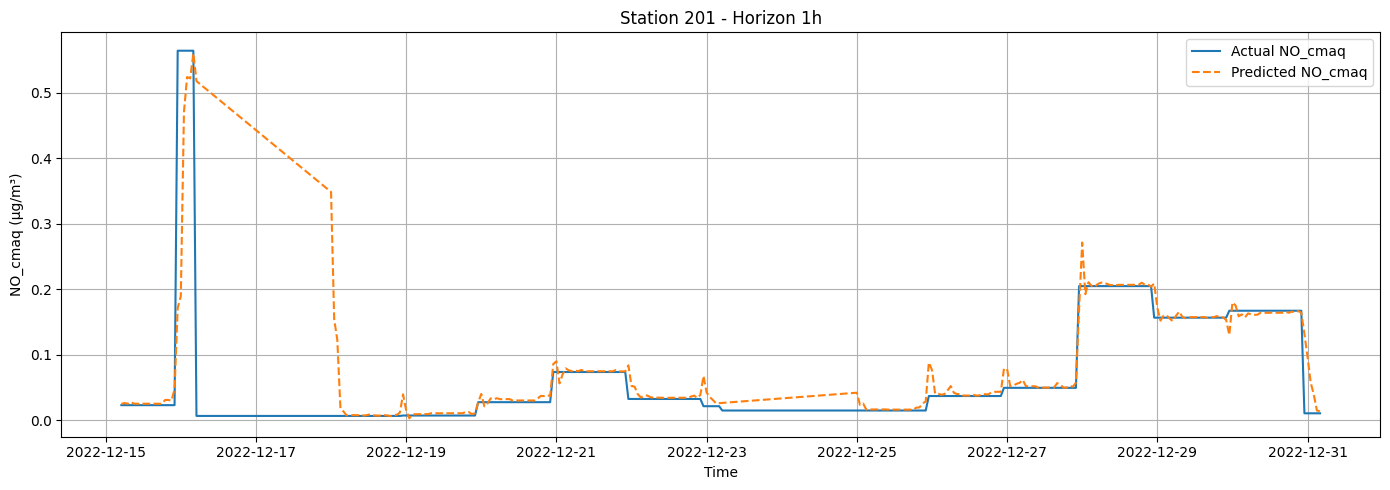

hour = 24


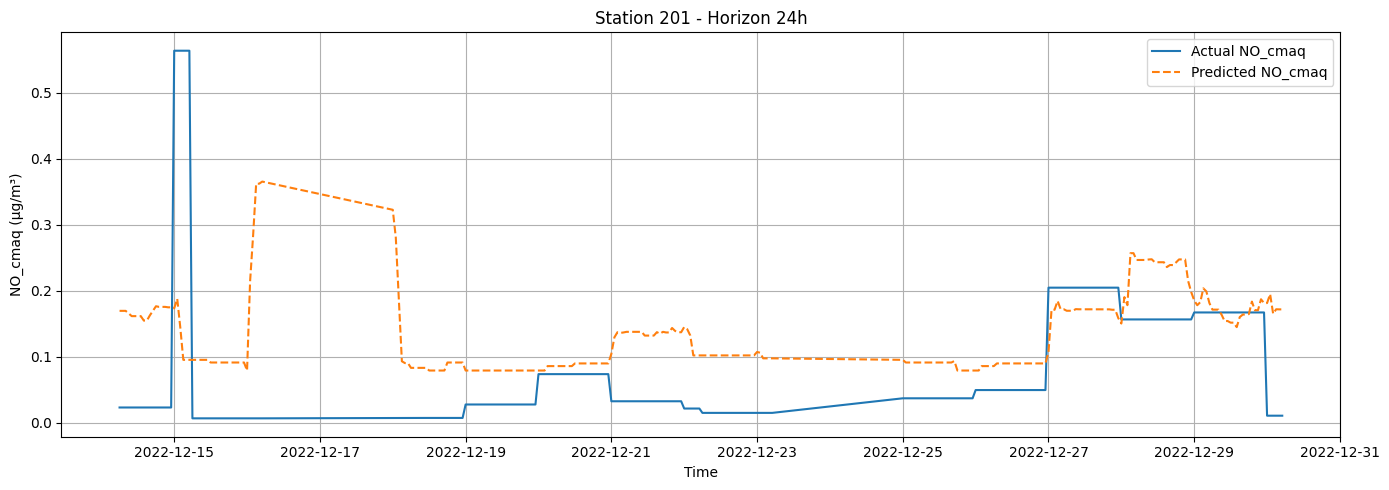

hour = 48


hour = 72


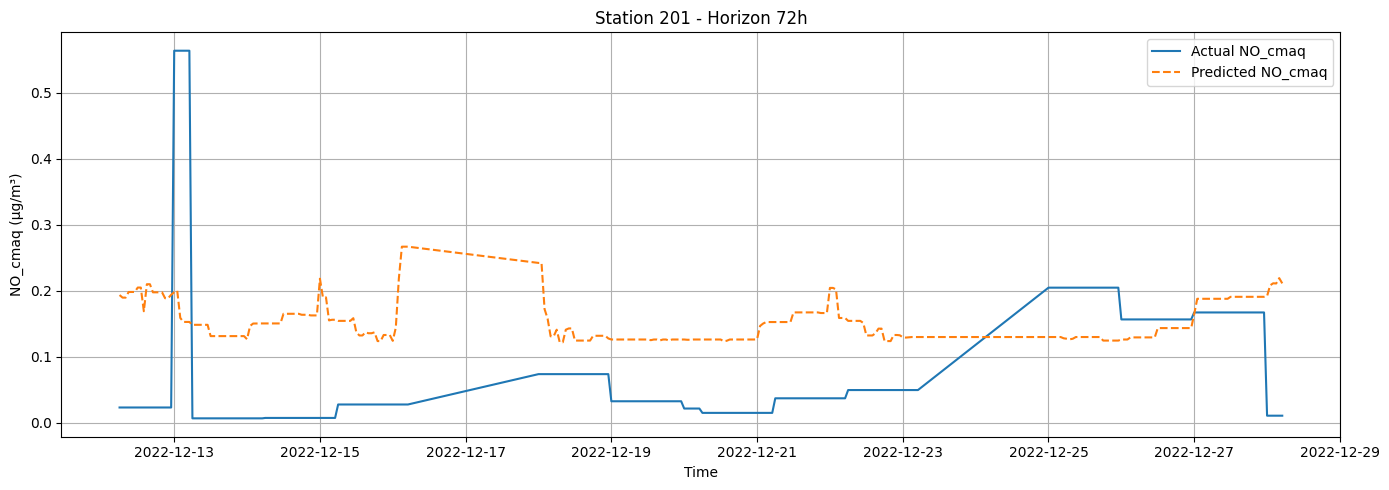

station_id = 211
hour = 1


hour = 24


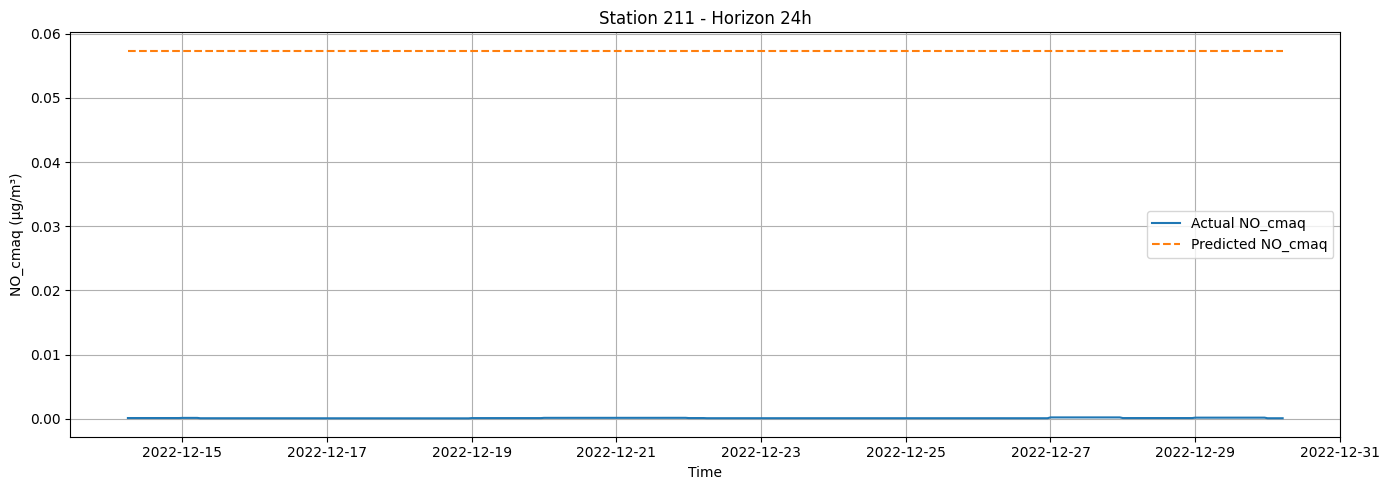

hour = 48


hour = 72


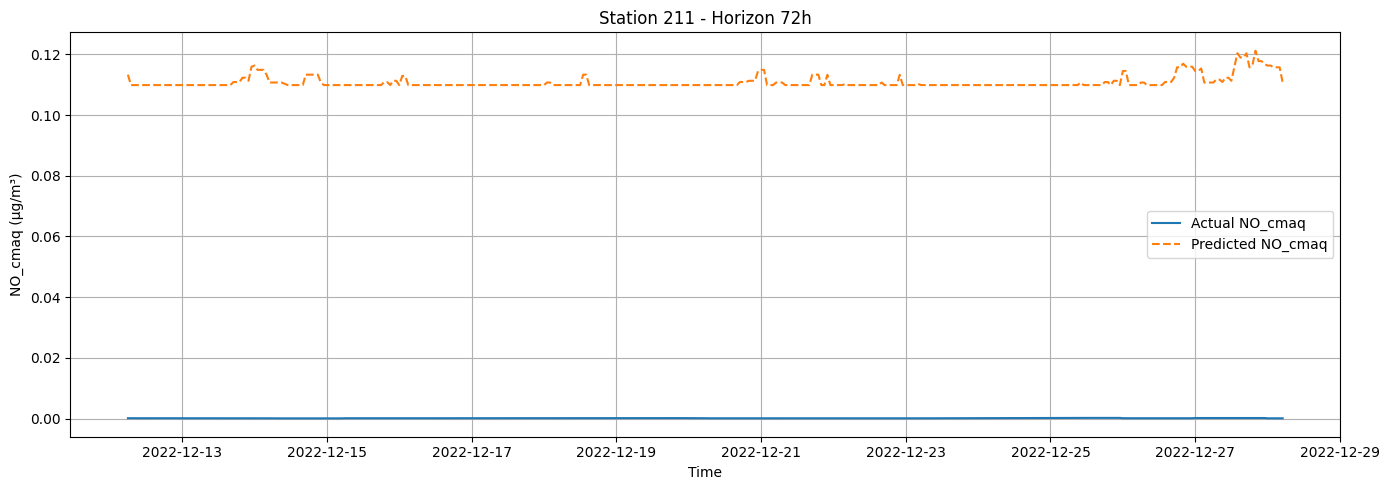

station_id = 212
hour = 1


hour = 24


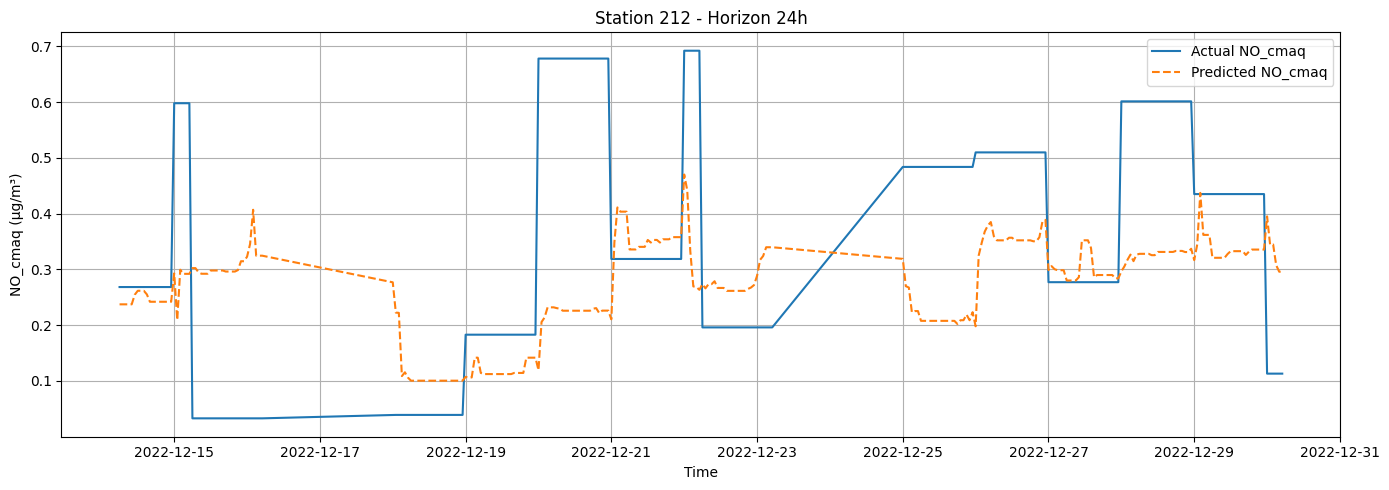

hour = 48


hour = 72


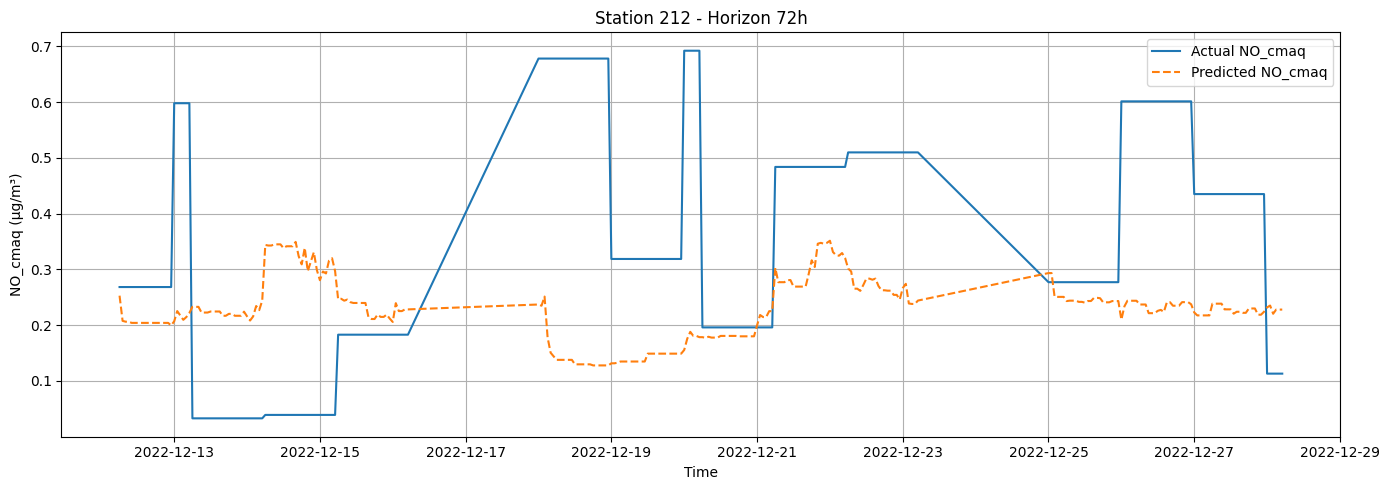

station_id = 213
hour = 1


hour = 24


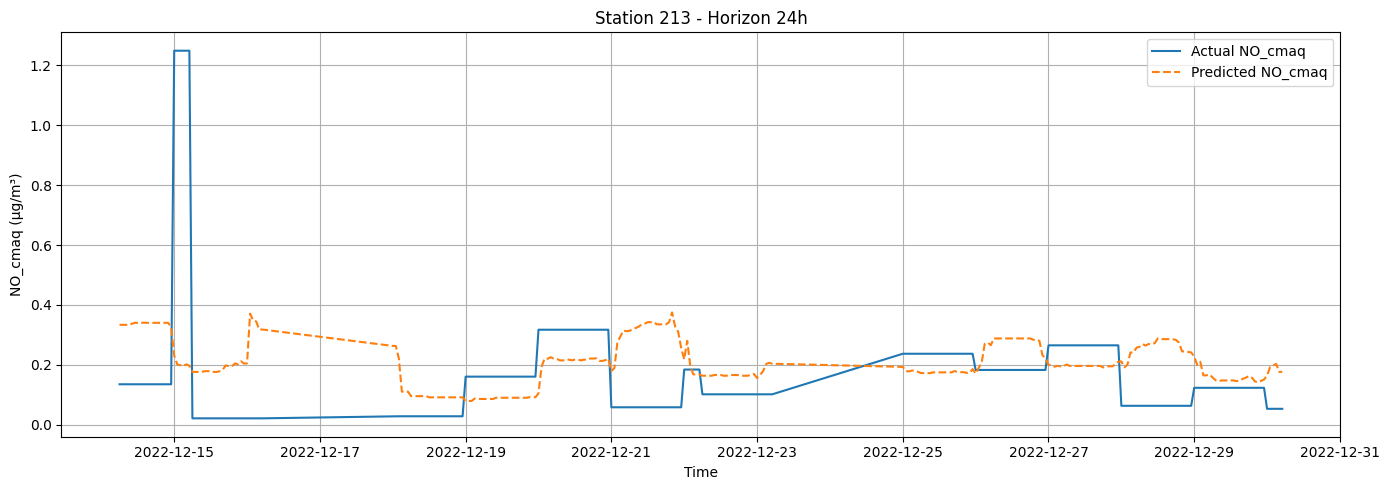

hour = 48


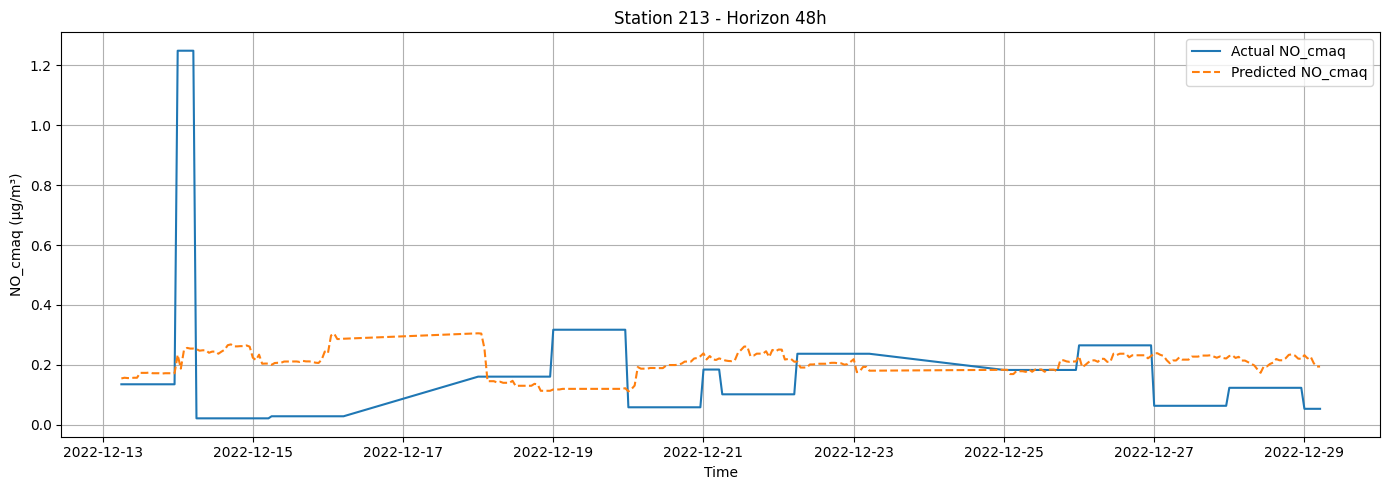

hour = 72


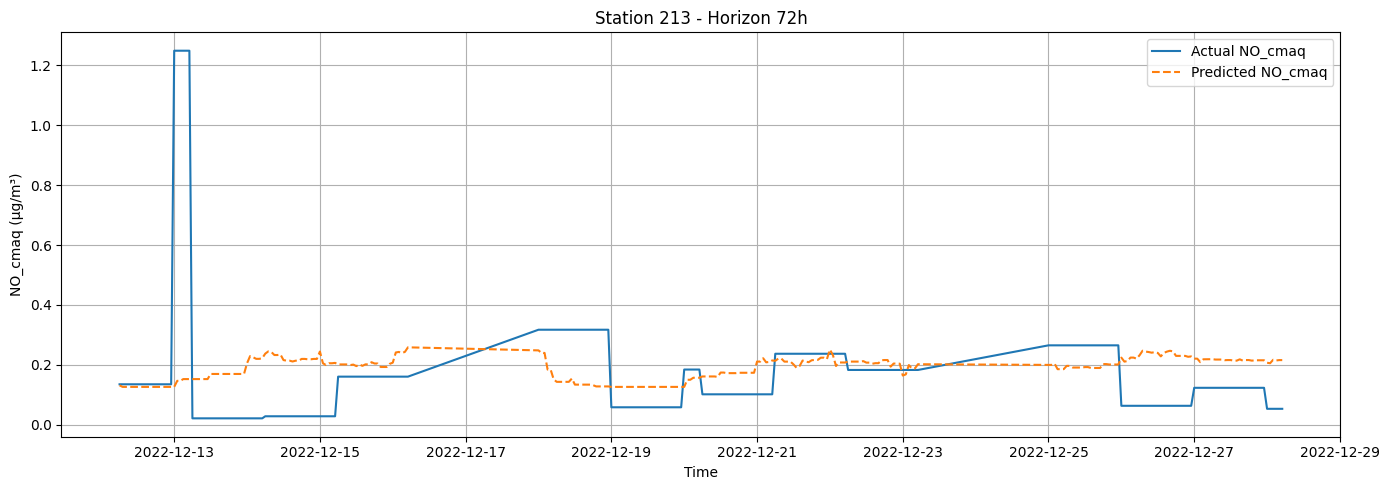

station_id = 214
hour = 1


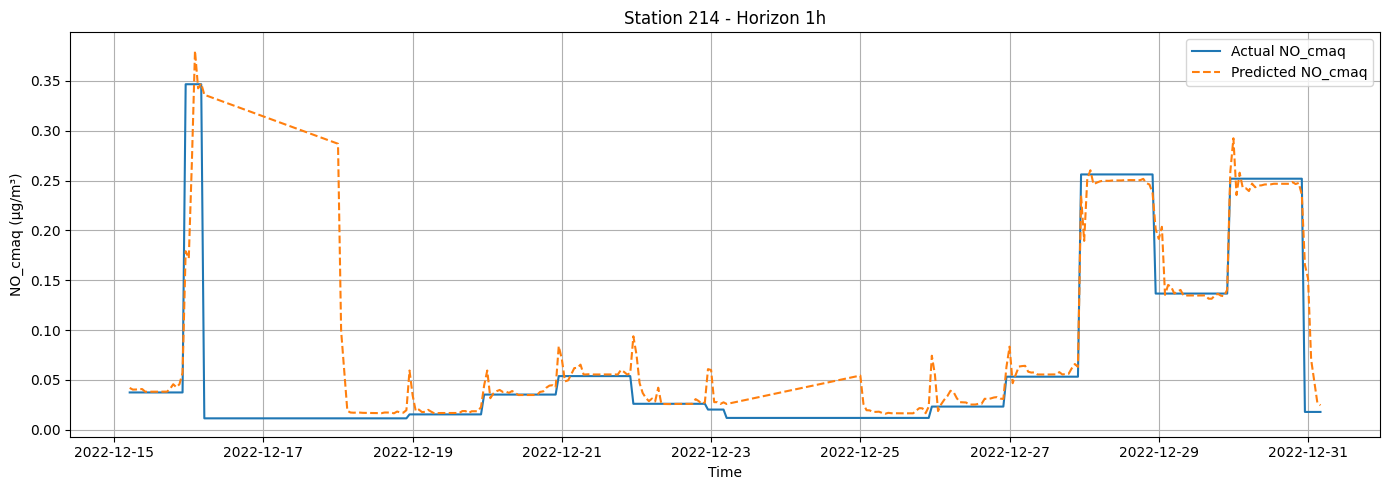

hour = 24


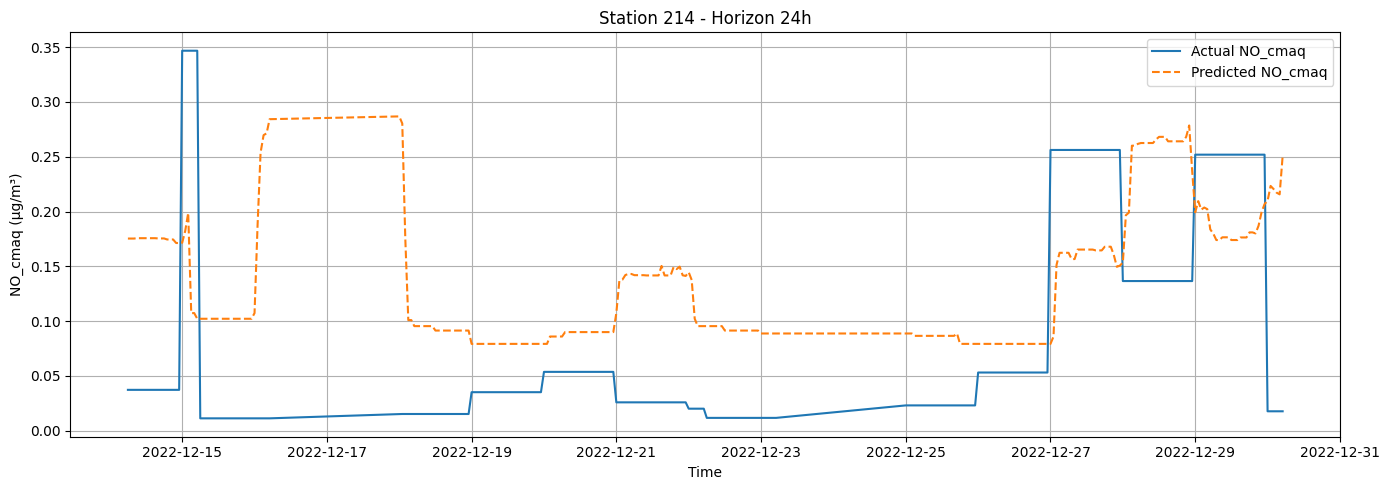

hour = 48


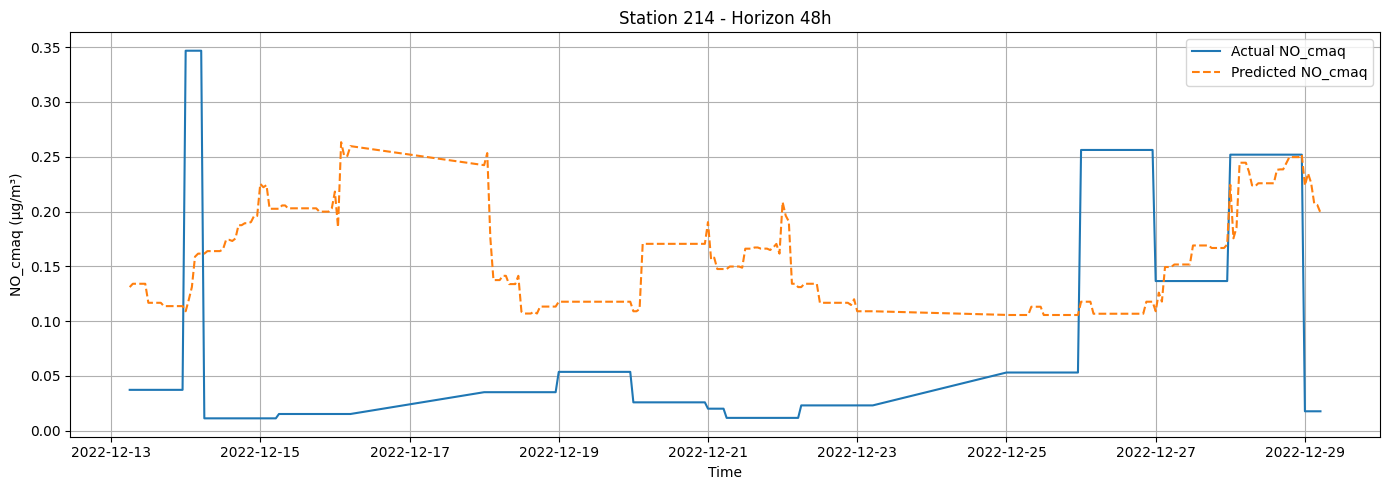

hour = 72


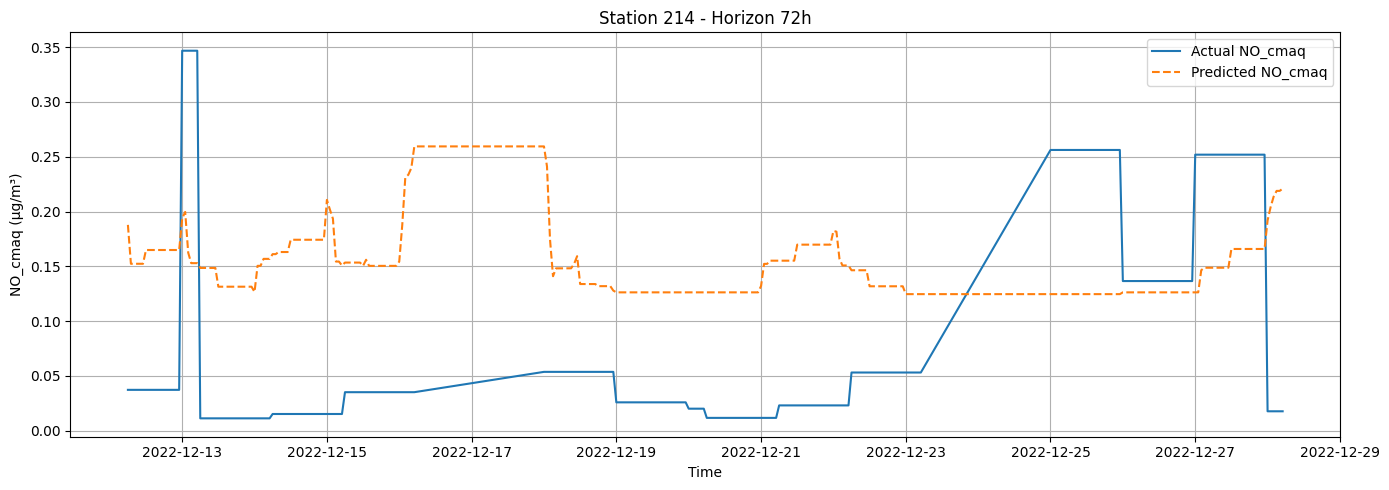

station_id = 215
hour = 1


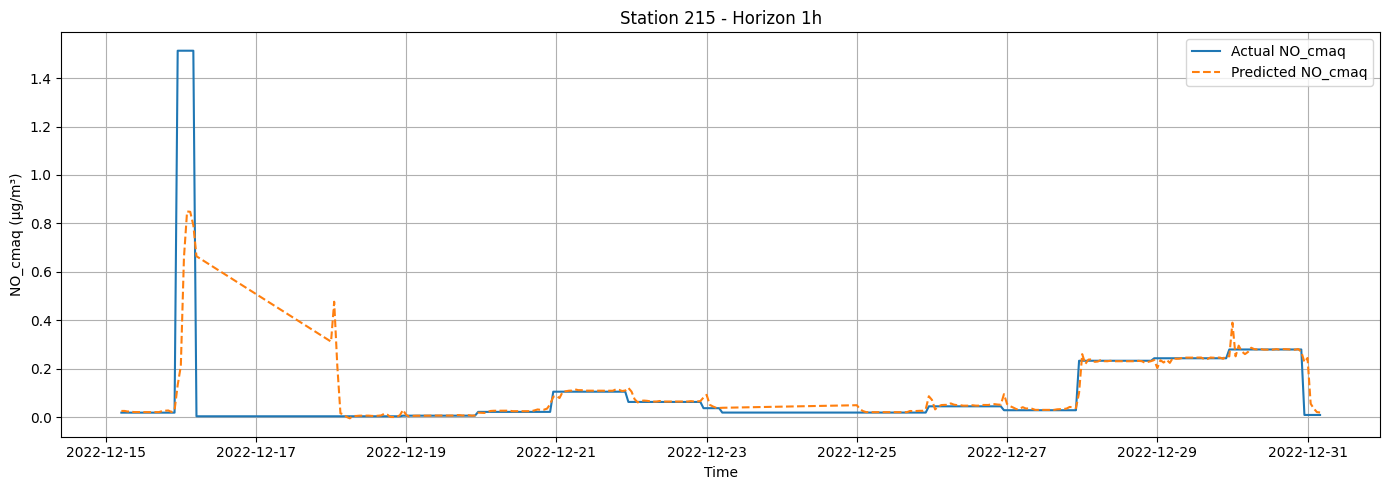

hour = 24


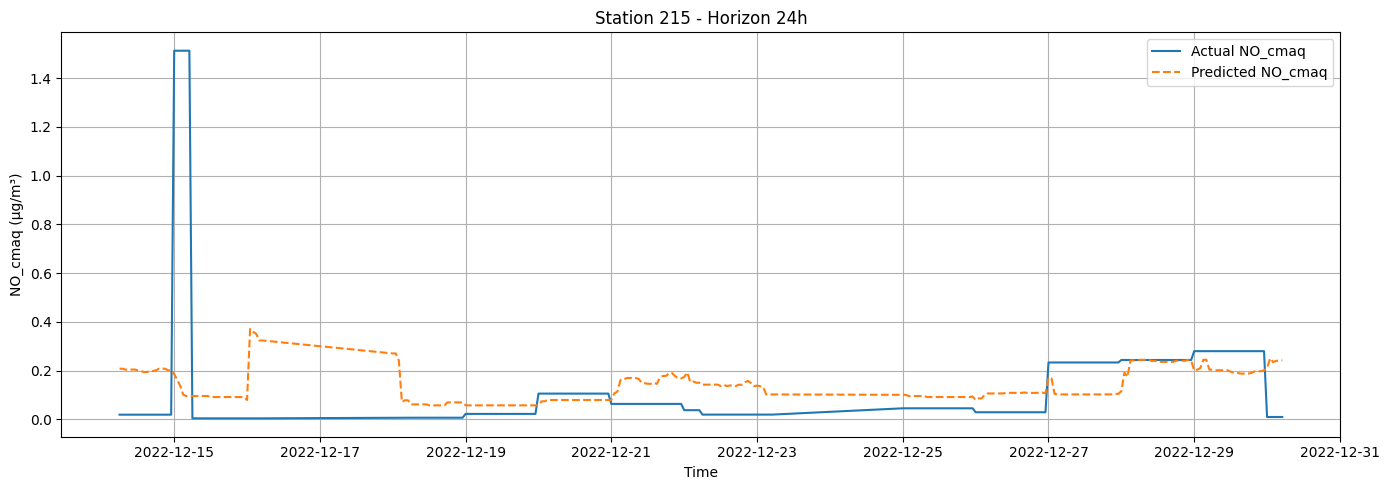

hour = 48


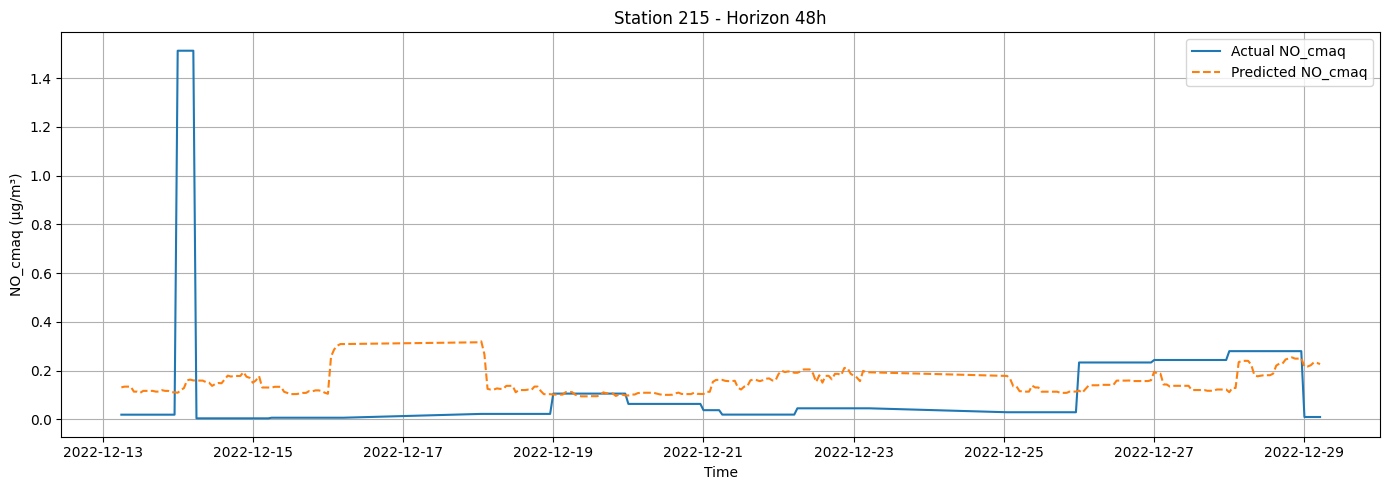

hour = 72


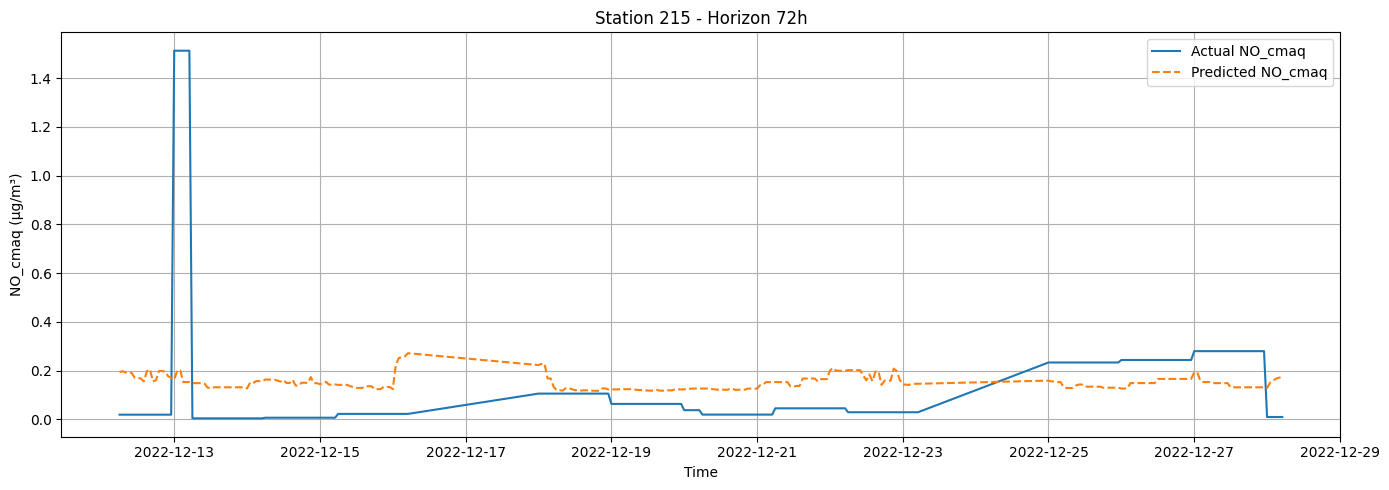

station_id = 216
hour = 1


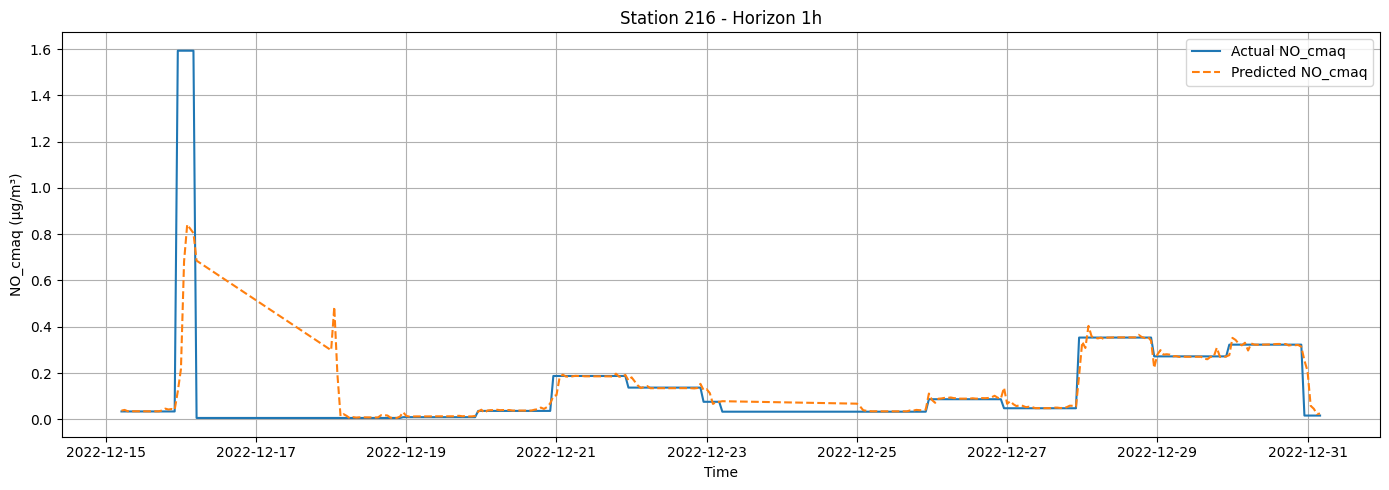

hour = 24


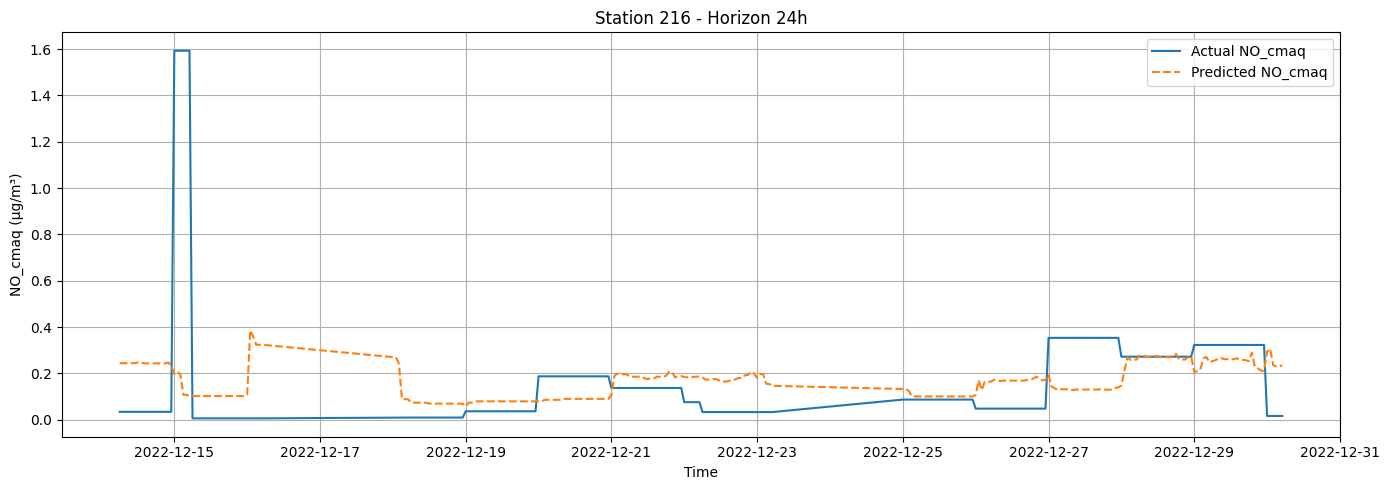

hour = 48


hour = 72


In [17]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in HORIZONS:
        print(f"hour = {hour}")
        plot_timeseries_example(df_no, no_models_by_h[hour], horizon_h=hour, station_id=station_id, target_col=label, LIGHTGBM_DIR=LIGHTGBM_DIR)